# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [328]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp
from sklearn.svm import SVR

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
from mltools import regression_tools as RT
import warnings
from sklearn.svm import SVC

---
## 1. Read the dataset

In [329]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285
...             ...
2023-06-01  2688842
2023-07-01  2677874
2023-08-01  2702700
2023-09-01  2722468
2023-10-01  2759404

[274 rows x 1 columns]

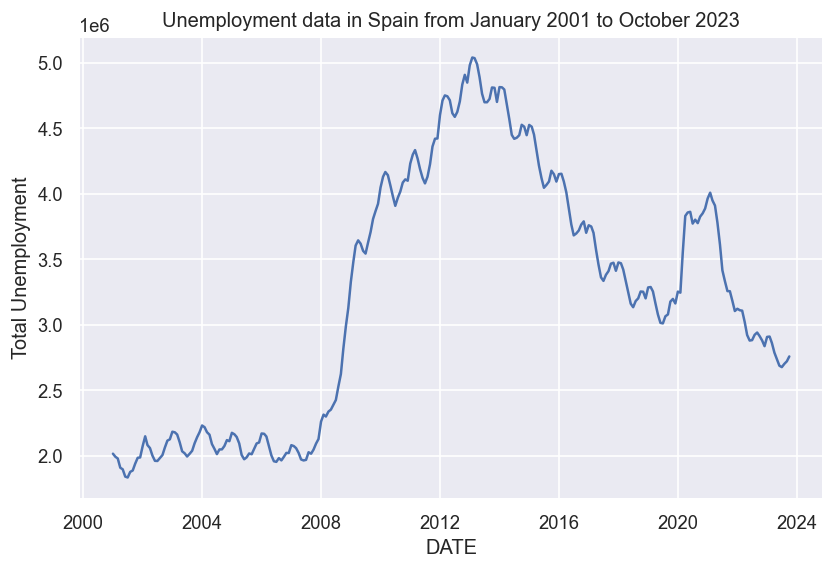

In [330]:
# Plotting a time series
fig, ax = plt.subplots()

ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2023', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [331]:
y = df
prop_train=0.88

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

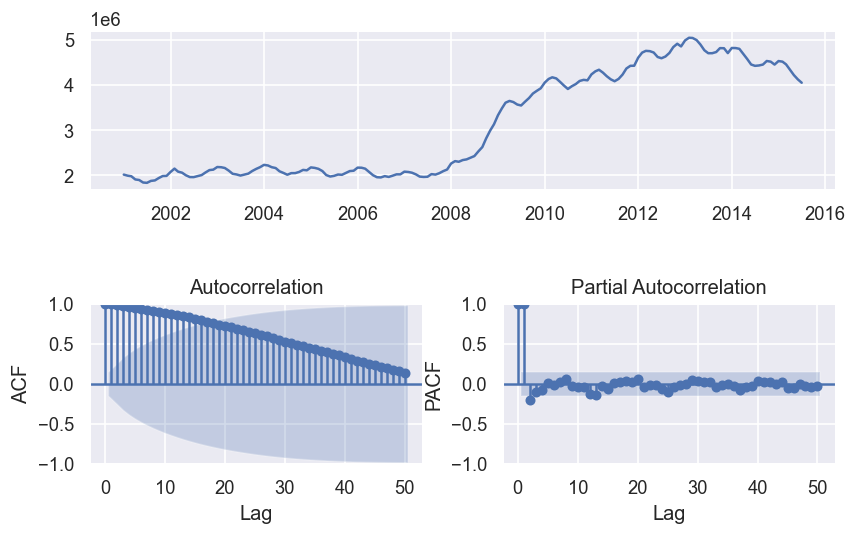

In [332]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

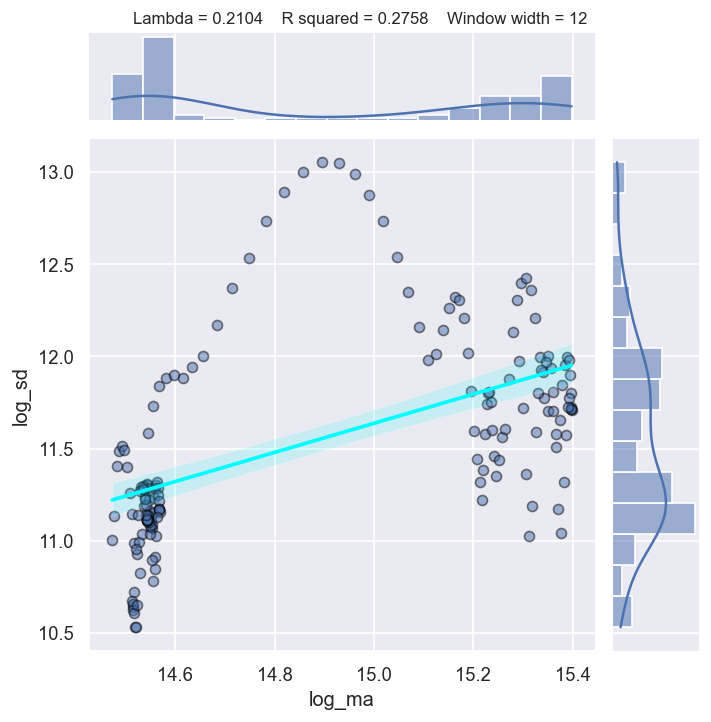

In [333]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

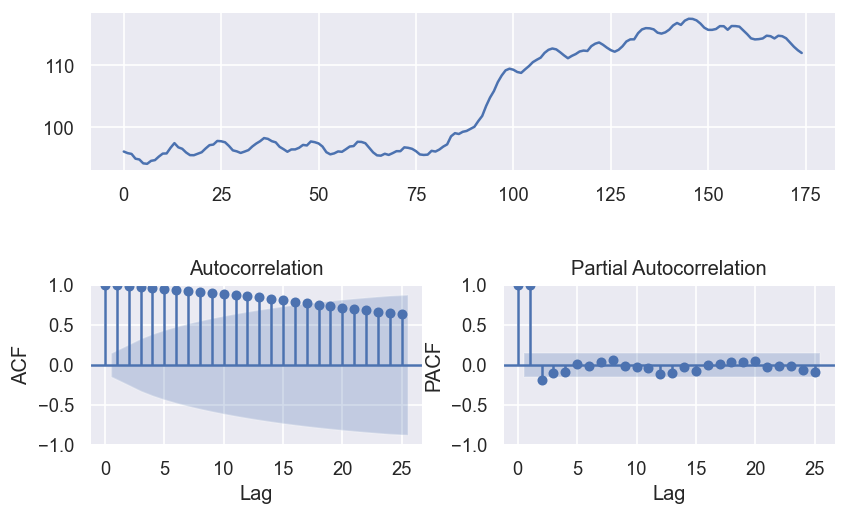

In [334]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

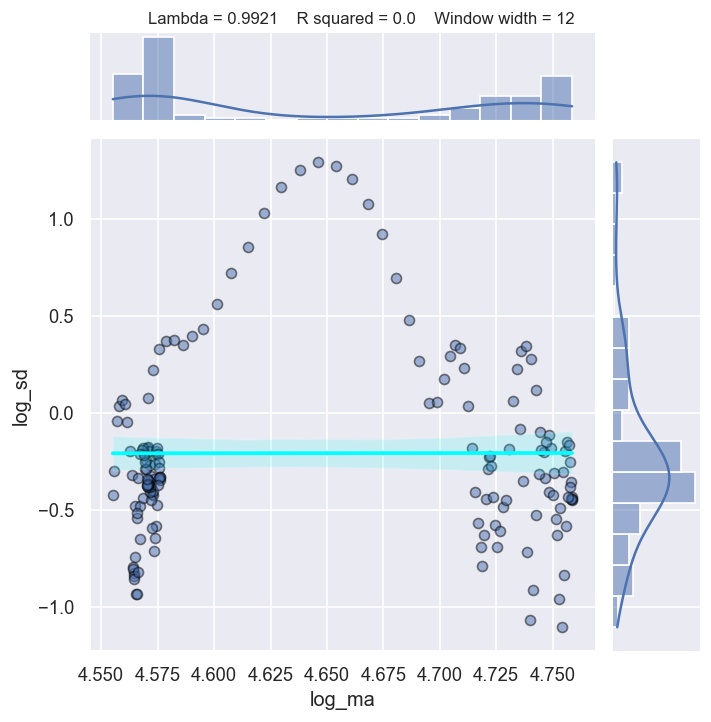

0.9921306069970893

In [335]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [336]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


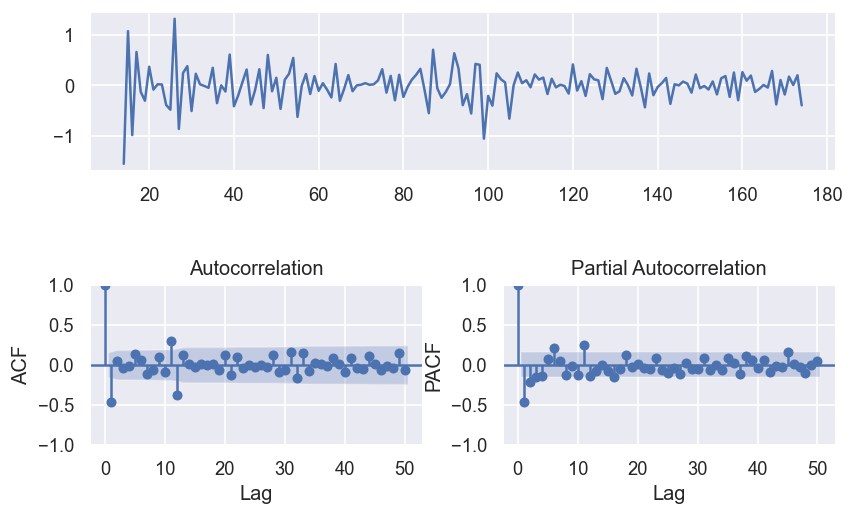

In [337]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

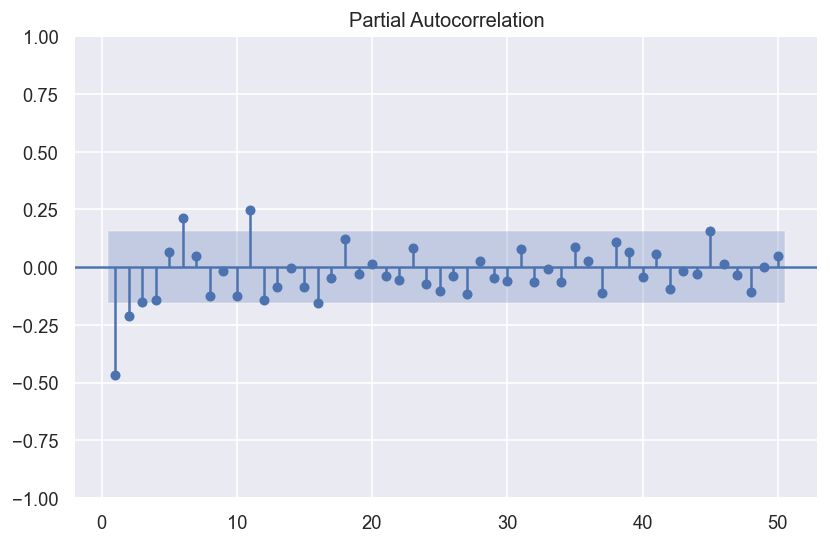

<Figure size 960x600 with 0 Axes>

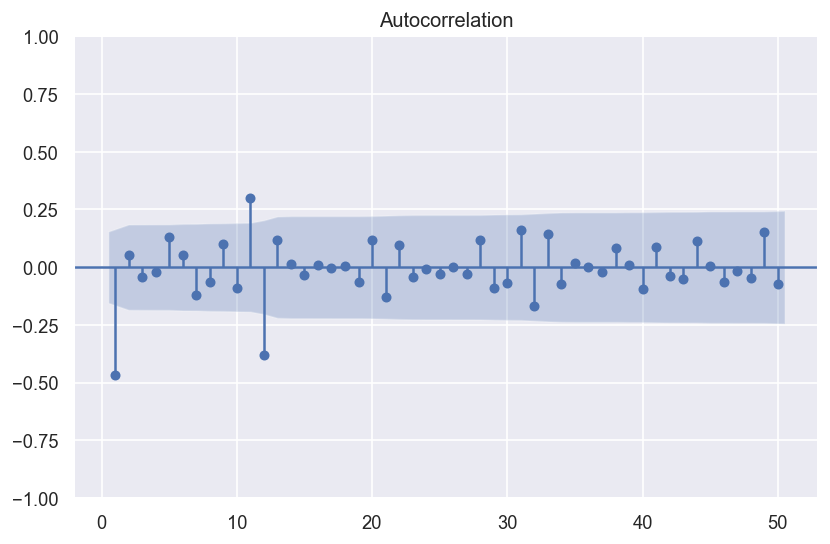

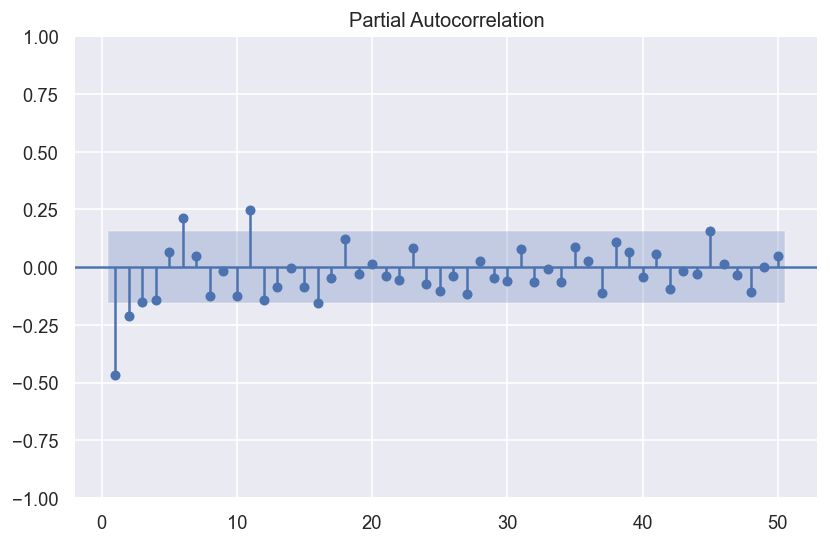

In [338]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [339]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96781D-02    |proj g|=  3.02762D-01


 This problem is unconstrained.



At iterate    5    f=  2.23011D-02    |proj g|=  1.45201D-02

At iterate   10    f=  2.16961D-02    |proj g|=  6.89094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   4.666D-04   2.170D-02
  F =   2.1695984602812586E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  175
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.797
Date:                     

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  31.821279   0.163249


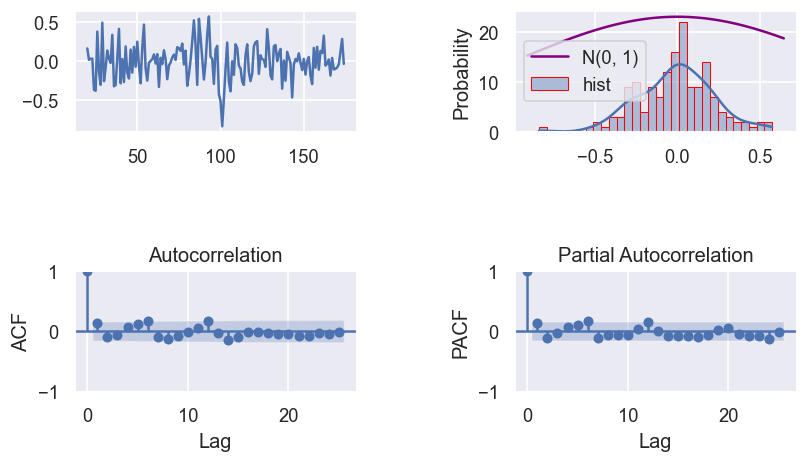

In [340]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [341]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56040D-02    |proj g|=  2.14281D-01


 This problem is unconstrained.



At iterate    5    f= -2.75878D-03    |proj g|=  1.87792D-02

At iterate   10    f= -4.13943D-03    |proj g|=  2.77801D-03

At iterate   15    f= -4.14326D-03    |proj g|=  4.01438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     24      1     0     0   1.491D-04  -4.143D-03
  F =  -4.1432576371934820E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  175
Model:             SARIMAX(6, 2, 0)x(0, 1, [1], 12)

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.334214   0.827878


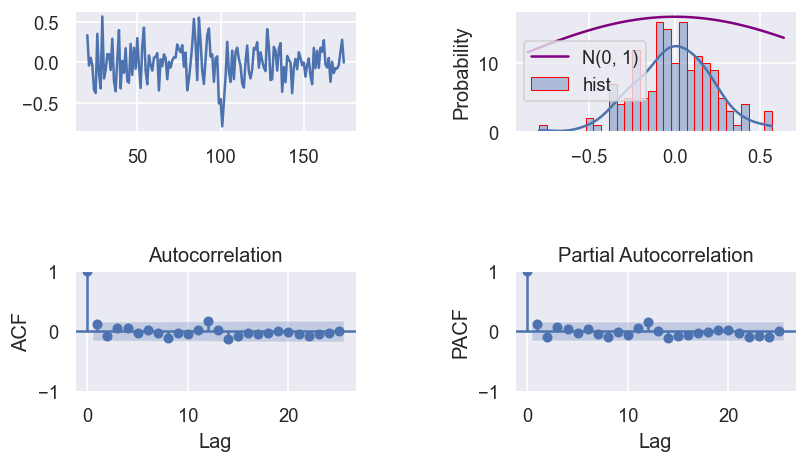

In [342]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

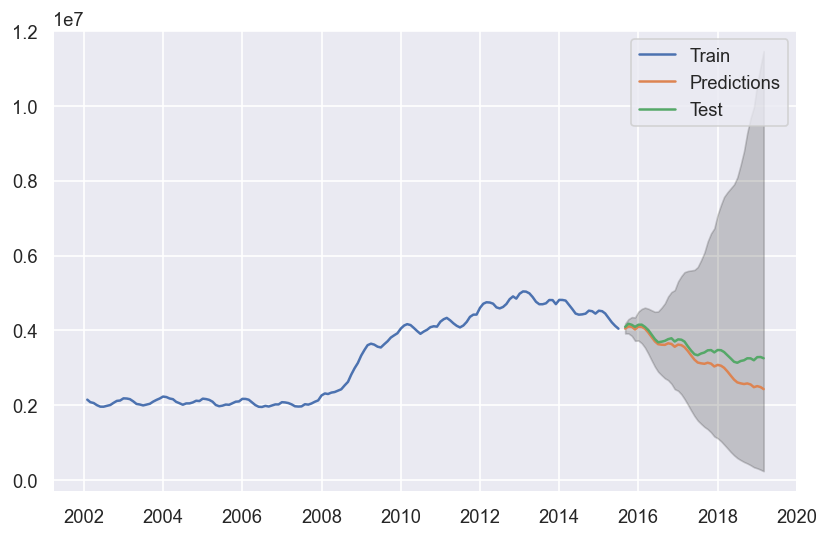

In [343]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

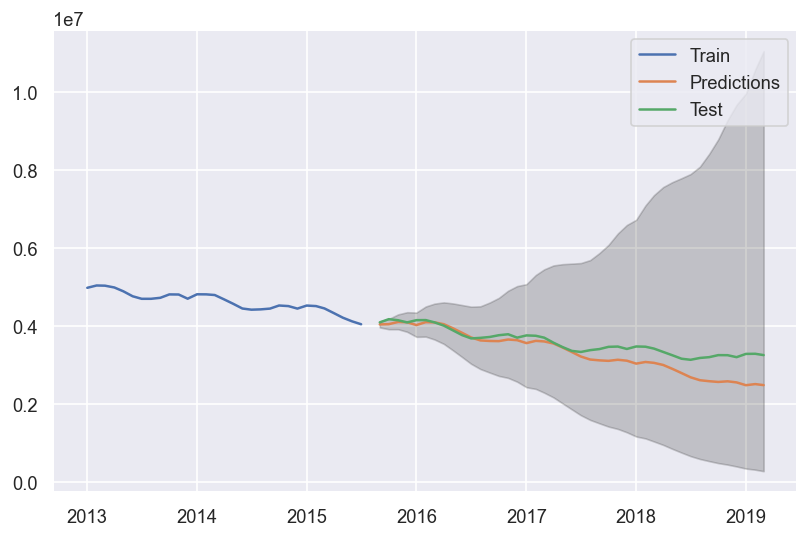

In [344]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [345]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266711.98550756724
Test RMSE SARIMA 1 d = 2: 360965.2032924141


In [346]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66354D-02    |proj g|=  3.19505D-01


 This problem is unconstrained.



At iterate    5    f=  1.03942D-02    |proj g|=  2.64534D-02

At iterate   10    f=  7.04179D-03    |proj g|=  1.92878D-02

At iterate   15    f=  5.55684D-03    |proj g|=  9.19188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   5.786D-04   5.557D-03
  F =   5.5565166031774993E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test MAE SARIMA 1 d = 1: 210196.1379714429
Test RMSE SARIMA 1 d = 1: 240055.36278097206


In [347]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 234966.39563792147
Test RMSE SARIMA 2: 320135.67674780625


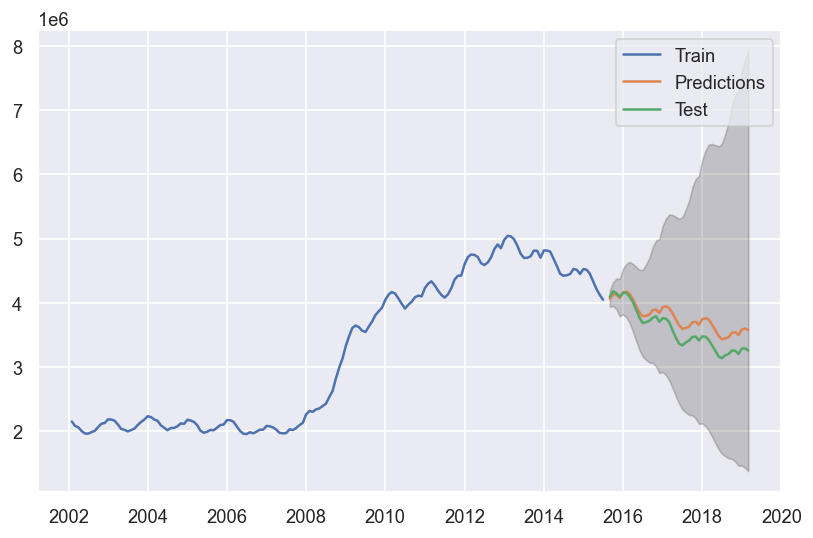

In [348]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

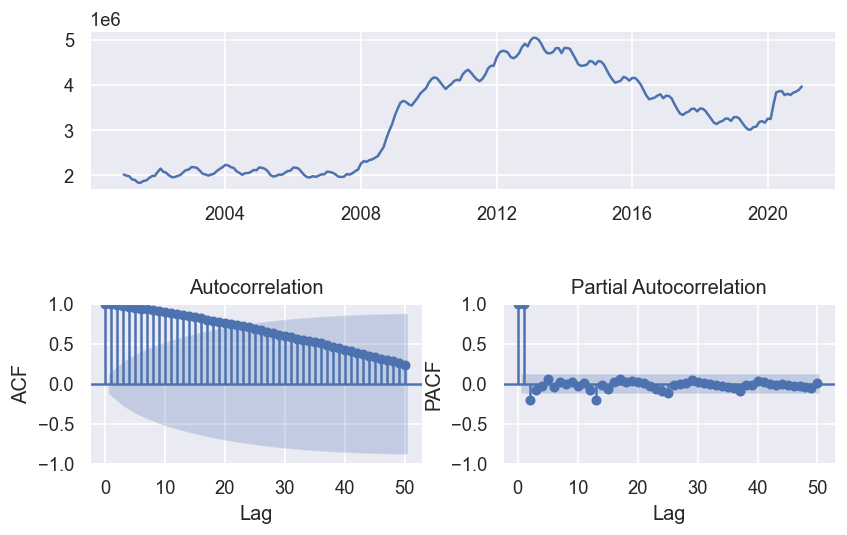

In [349]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

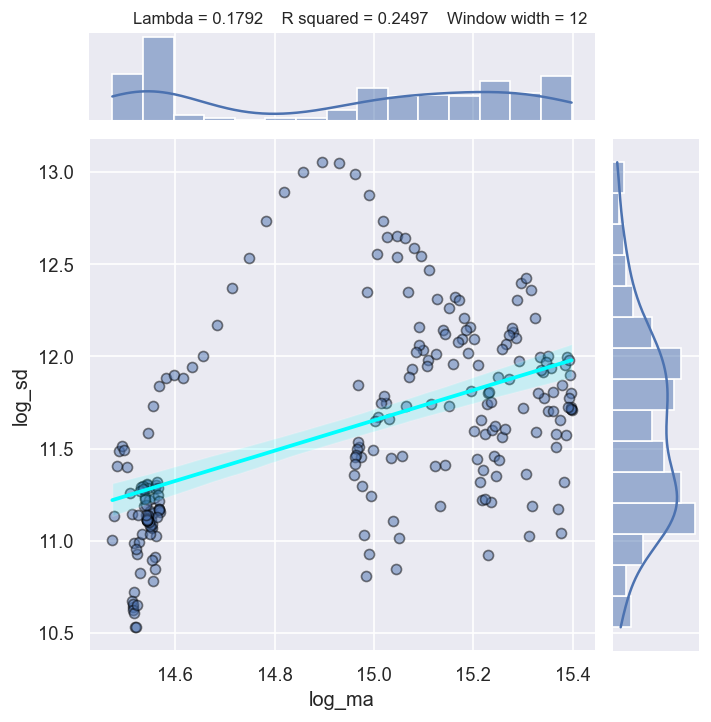

In [350]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

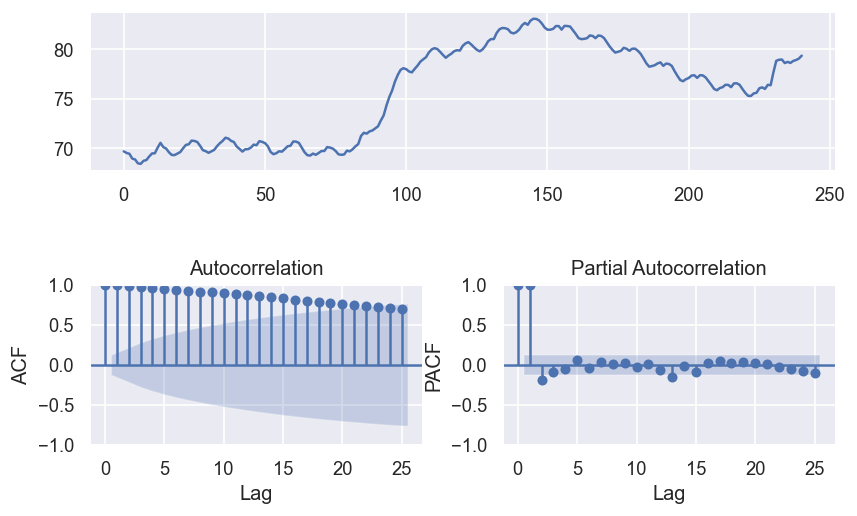

In [351]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

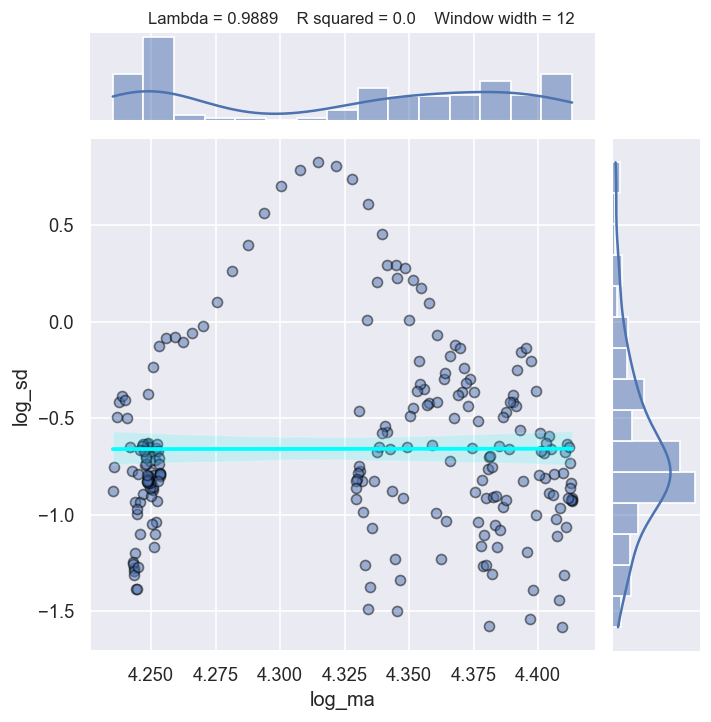

0.9889334090138504

In [352]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [353]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.593455
p-value: 0.486880
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


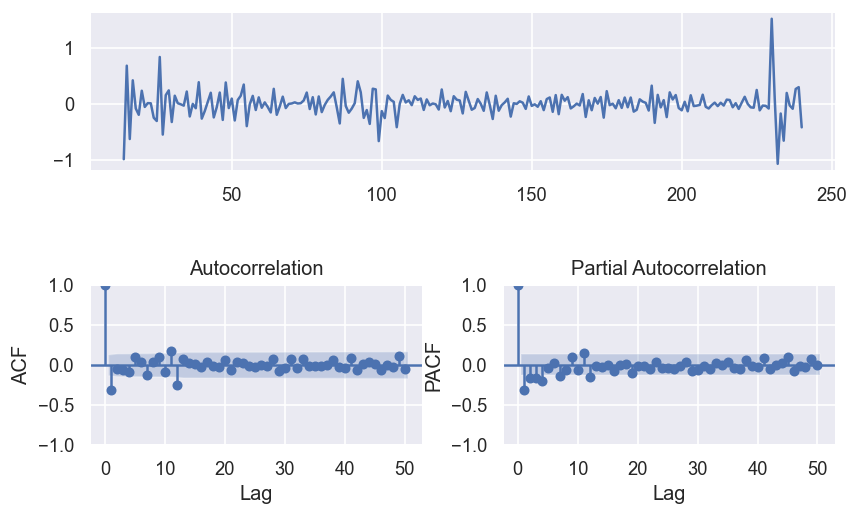

In [354]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [355]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93995D-01    |proj g|=  4.34538D-01

At iterate    5    f= -2.13073D-01    |proj g|=  1.56355D-01

At iterate   10    f= -2.19584D-01    |proj g|=  4.35490D-01

At iterate   15    f= -2.25959D-01    |proj g|=  7.67286D-03

At iterate   20    f= -2.26892D-01    |proj g|=  2.44331D-02

At iterate   25    f= -2.27217D-01    |proj g|=  1.64591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  9.946319   0.996794


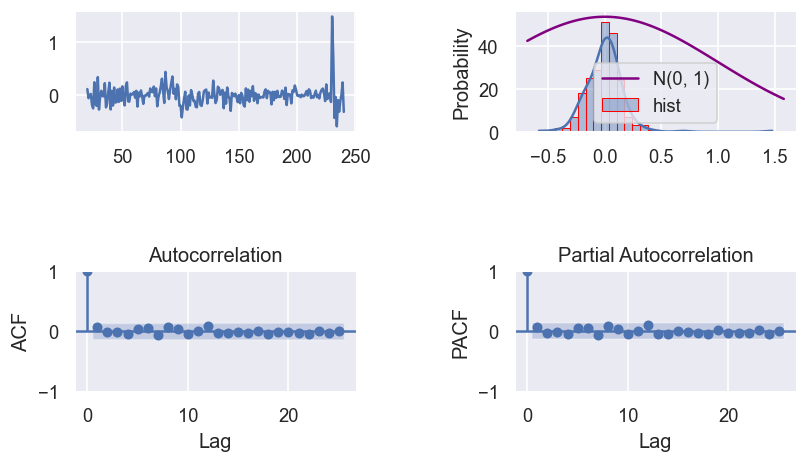

In [356]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

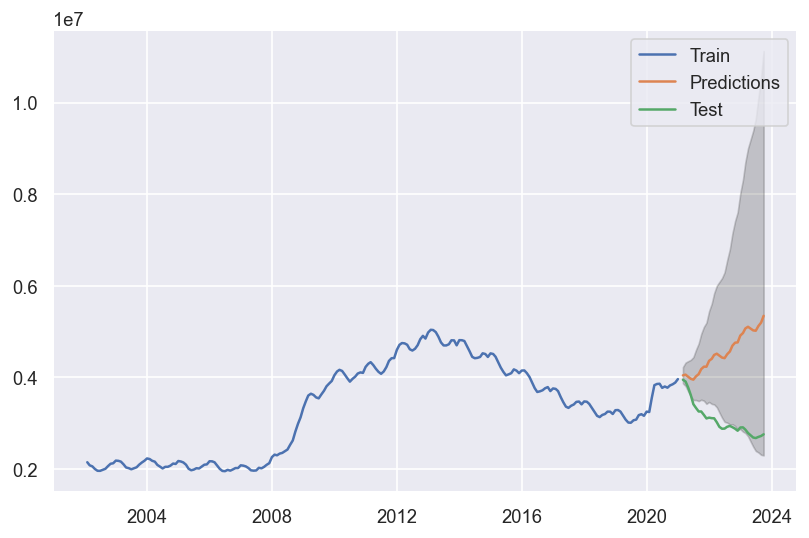

In [357]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [358]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1497247.6631776781
Test RMSE SARIMA 1 d = 2: 1663251.3686611715


In [359]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88543D-01    |proj g|=  1.44166D-01


 This problem is unconstrained.



At iterate    5    f= -2.32282D-01    |proj g|=  2.27931D-02

At iterate   10    f= -2.33557D-01    |proj g|=  3.13827D-03

At iterate   15    f= -2.33641D-01    |proj g|=  1.83527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   5.812D-04  -2.336D-01
  F = -0.23364088519840137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  15.480245    0.92943


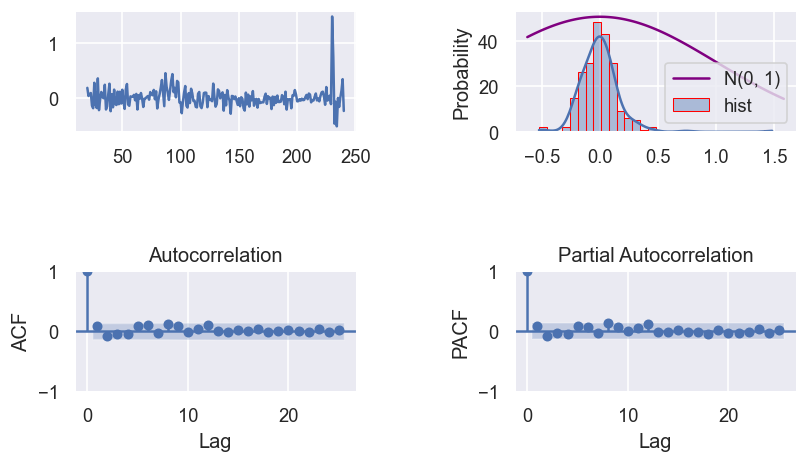

In [360]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

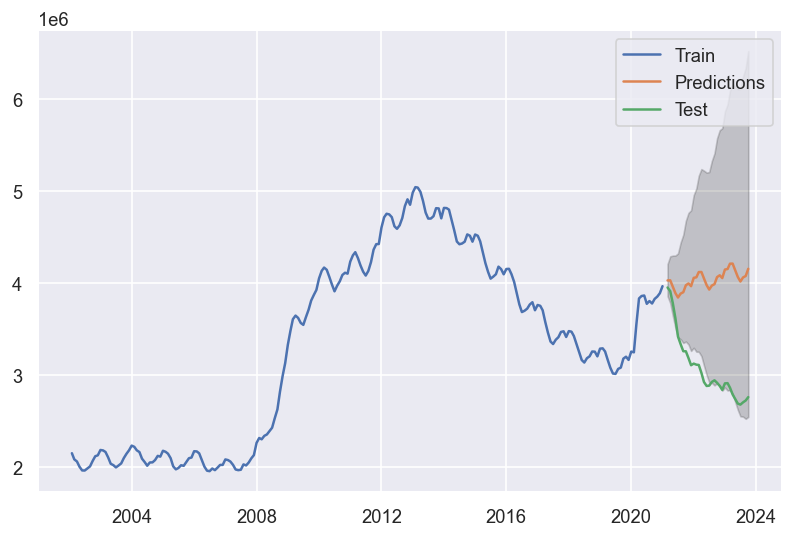

In [361]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [362]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 1: 969152.2836484313
Test RMSE SARIMA 1 d = 1: 1046467.7978979676


Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores (aún así, su intervalo de confianza es menor, lo cual es bueno). De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [363]:
#df['COVID_Desc']=0
#df['COVID_Asc']=0
df['COVID']=0
df['CRISIS']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia ascendente en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia descendente en nuestra serie
periodo_zapatero_inicio= pd.to_datetime('2007-08-01')
periodo_zapatero_fin=pd.to_datetime('2013-01-01')


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_zapatero_inicio:periodo_zapatero_fin, 'CRISIS'] =1
#df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID_Asc'] =1

prop_train=0.88#Proporción de datos usada para entrenamiento


print(df['COVID'].value_counts())
df['CRISIS'].value_counts()

COVID
0    257
1     17
Name: count, dtype: int64


CRISIS
0    208
1     66
Name: count, dtype: int64

In [364]:
INPUTS_SARMAX = ['COVID','CRISIS']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

X_train2

COVID  CRISIS
DATE                     
2001-01-01      0       0
2001-02-01      0       0
2001-03-01      0       0
2001-04-01      0       0
2001-05-01      0       0
...           ...     ...
2020-09-01      1       0
2020-10-01      1       0
2020-11-01      1       0
2020-12-01      1       0
2021-01-01      1       0

[241 rows x 2 columns]

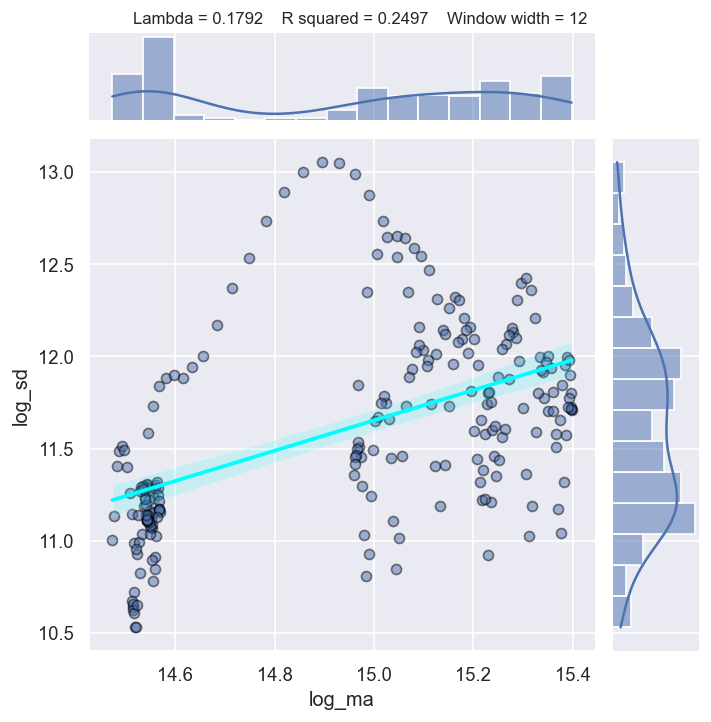

In [365]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

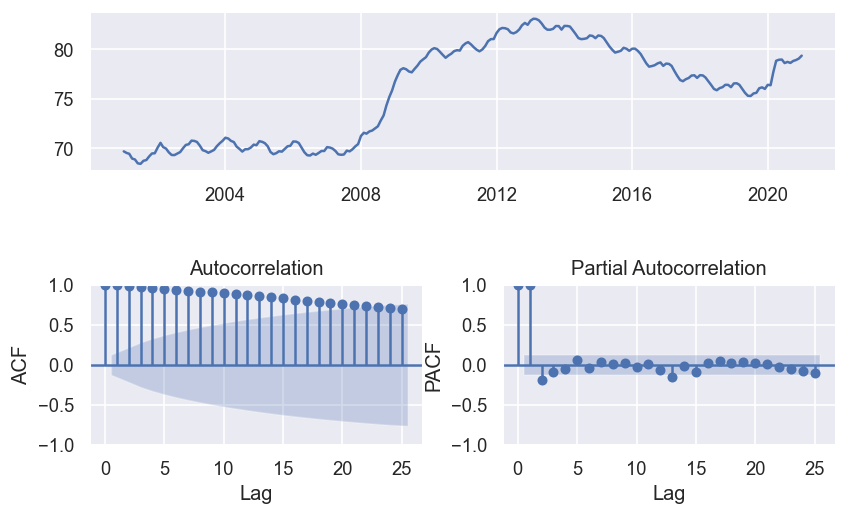

In [366]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [367]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37451D-01    |proj g|=  1.46411D-01

At iterate    5    f= -2.88117D-01    |proj g|=  1.36628D-01

At iterate   10    f= -3.04041D-01    |proj g|=  8.26603D-03

At iterate   15    f= -3.04213D-01    |proj g|=  2.21409D-03

At iterate   20    f= -3.04326D-01    |proj g|=  8.78194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     31      1     0     0   3.377D-04  -3.044D-01
  F = -0.30435169861429467     

CONVERG

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  35.366788   0.941598


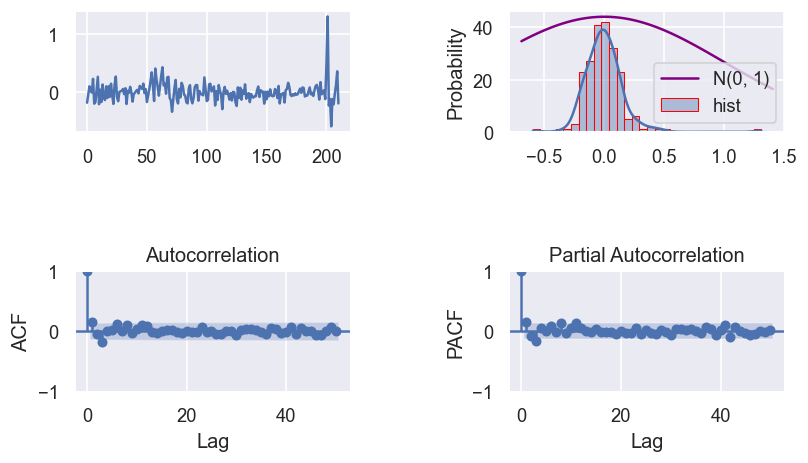

In [368]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)
 

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

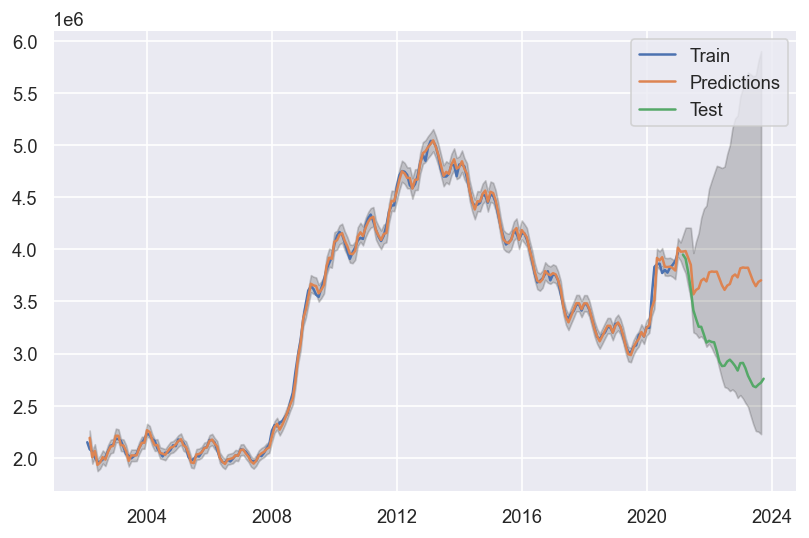

In [369]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [370]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY:',math.sqrt(mean_squared_error(y_test2, yhat)))
 

Test MAE SARIMAX DUMMY: 669033.8179296773
Test RMSE SARIMAX DUMMY: 734434.5330556028


# SARIMAX DUMMY 1/-1

In [371]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2020-03-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2020-03-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =-1


df['COVID'].astype('category')

df['COVID'].value_counts()#únicamente el COVID afecta a un 11% de nuestras observaciones

COVID
 0    273
-1      1
Name: count, dtype: int64

In [372]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]


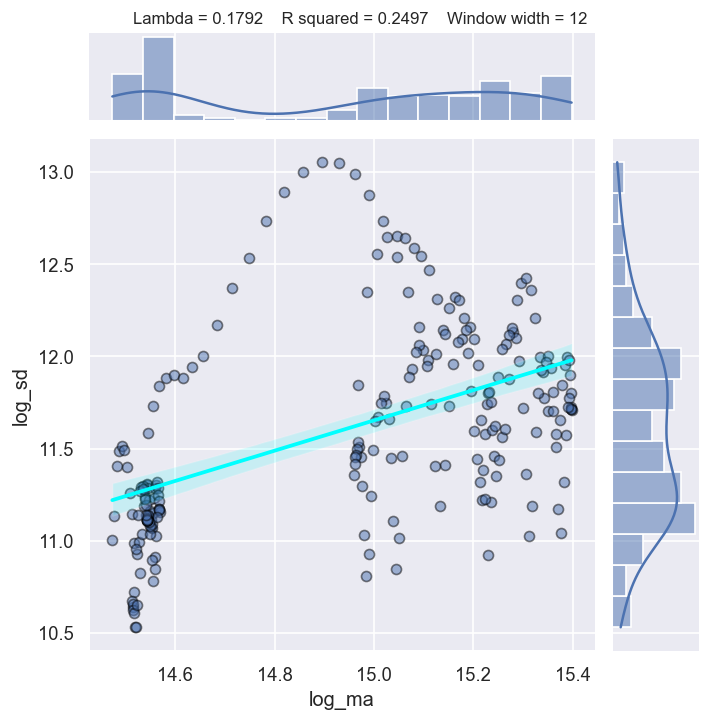

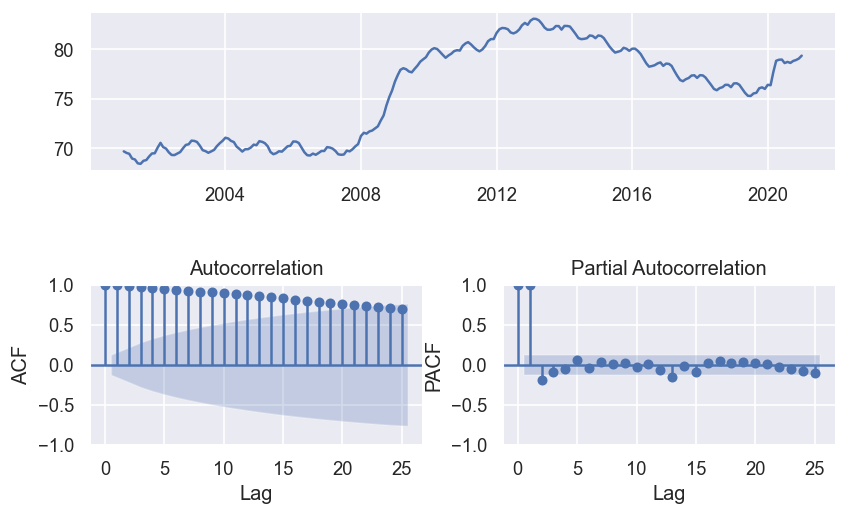

In [373]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)



In [374]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87983D-01    |proj g|=  1.42954D-01

At iterate    5    f= -2.32062D-01    |proj g|=  2.14053D-02

At iterate   10    f= -2.33895D-01    |proj g|=  2.33126D-03

At iterate   15    f= -2.33944D-01    |proj g|=  2.50717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   6.326D-05  -2.339D-01
  F = -0.23394419639271102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  27.160204   0.996538


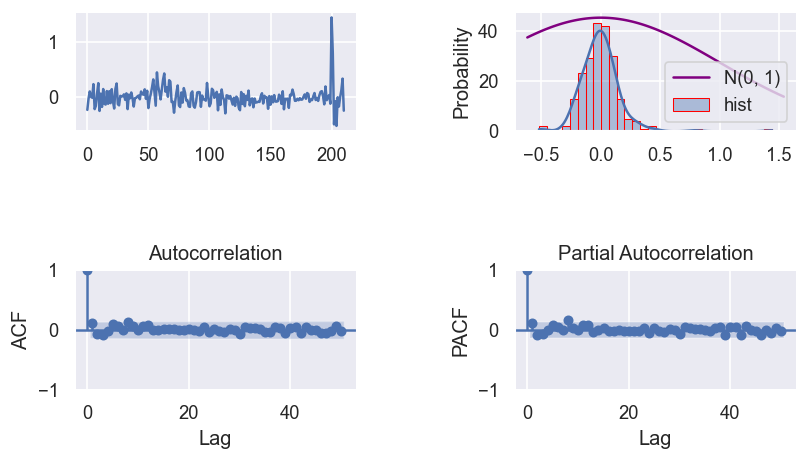

In [375]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

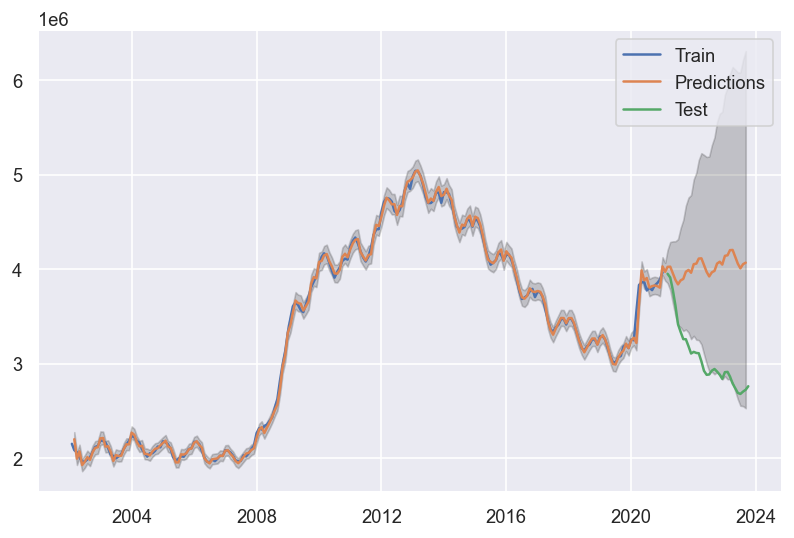

In [376]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [377]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY -1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY -1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX DUMMY -1: 950162.3597120374
Test RMSE SARIMAX DUMMY -1: 1027913.5707742994


# SARIMAX TIME VARYING COEFS.

In [378]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
#df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =-1


prop_train=0.88#Proporción de datos usada para entrenamiento o test

df['COVID'].describe() 

count    274.000000
mean       0.062044
std        0.241676
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COVID, dtype: float64

In [379]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

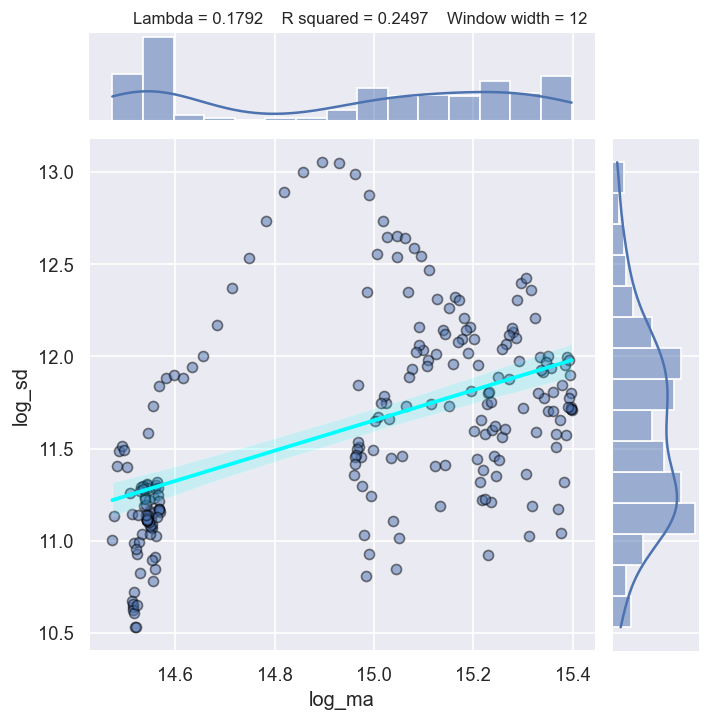

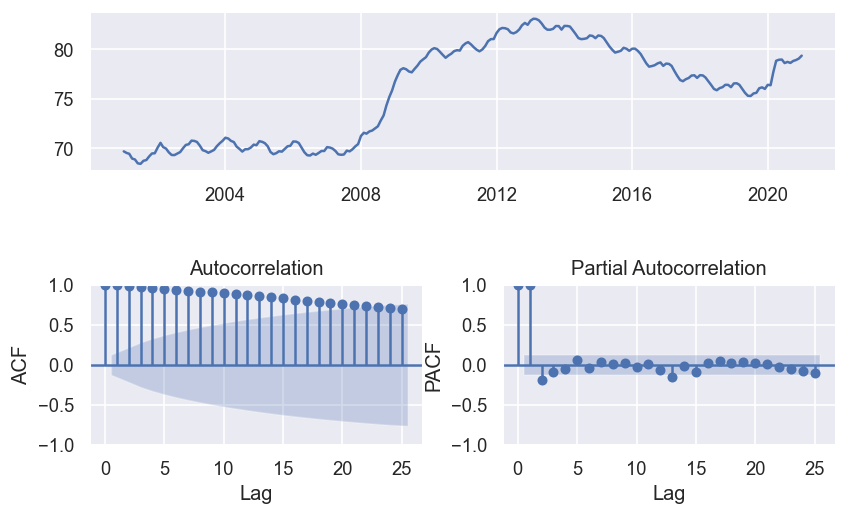

In [380]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [381]:
#time_varying_regression
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=True,
                            mle_regression=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.43465D-02    |proj g|=  2.14882D+00

At iterate    5    f= -3.46412D-01    |proj g|=  3.18376D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     44      1     0     0   3.318D+00  -3.466D-01
  F = -0.34662894744690059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                           


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  39.071752   0.867878


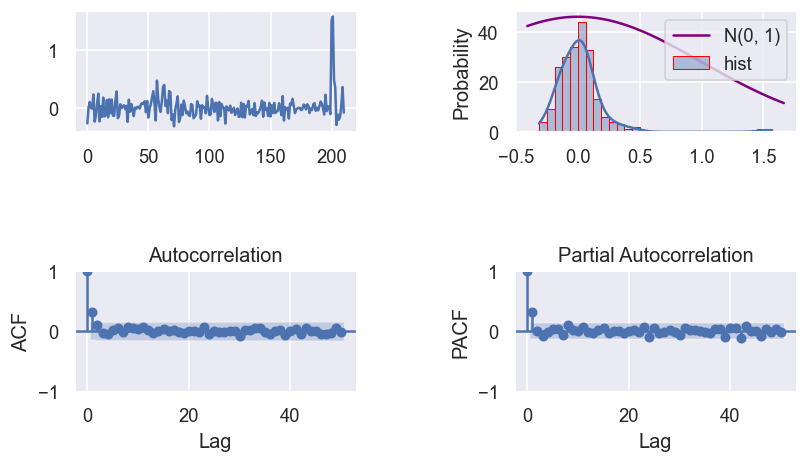

In [382]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

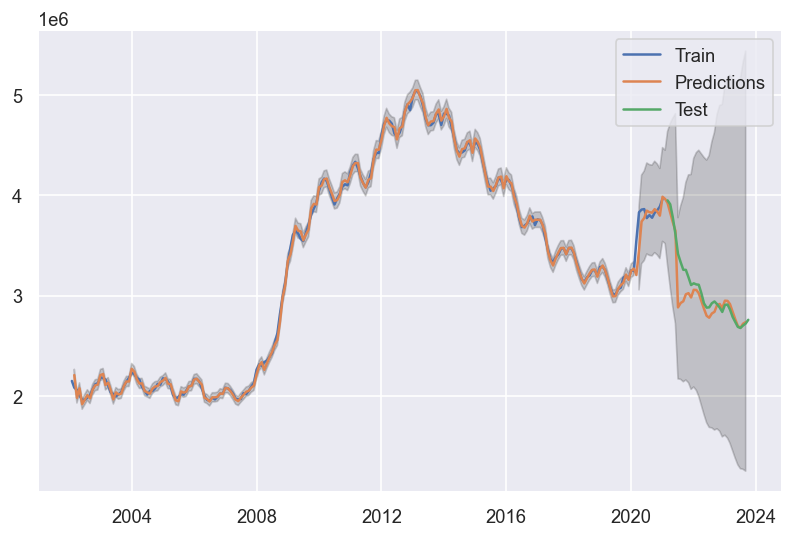

In [383]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [384]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX TVC:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA TVC:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX TVC: 97730.53631493384
Test RMSE SARIMA TVC: 153815.96455589557


# MLP_SIN_COVID

In [385]:
# Assuming 'DATE' is the index in your DataFrame
df.index = pd.to_datetime(df.index)

# Extract year and month
df['YEAR'] = df.index.year.astype('category')
df['MONTH'] = df.index.month.astype('category')


In [386]:
df

TOTAL  COVID  CRISIS  YEAR MONTH
DATE                                          
2001-01-01  2017389      0       0  2001     1
2001-02-01  1993273      0       0  2001     2
2001-03-01  1981006      0       0  2001     3
2001-04-01  1910453      0       0  2001     4
2001-05-01  1898285      0       0  2001     5
...             ...    ...     ...   ...   ...
2023-06-01  2688842      0       0  2023     6
2023-07-01  2677874      0       0  2023     7
2023-08-01  2702700      0       0  2023     8
2023-09-01  2722468      0       0  2023     9
2023-10-01  2759404      0       0  2023    10

[274 rows x 5 columns]

In [422]:
###Include lagged variables
dfT = df[['TOTAL']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
#dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL  TOTAL_lag1
DATE                           
2001-01-01  2017389         NaN
2001-02-01  1993273         NaN
2001-03-01  1981006   2017389.0
2001-04-01  1910453   1993273.0
2001-05-01  1898285   1981006.0

In [423]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL  TOTAL_lag1
DATE                           
2001-03-01  1981006   2017389.0
2001-04-01  1910453   1993273.0
2001-05-01  1898285   1981006.0
2001-06-01  1842556   1910453.0
2001-07-01  1835738   1898285.0

In [424]:
# Define input and output matrices
INPUTS= ['TOTAL_lag1']
#INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','MONTH','YEAR']

OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.64*y.shape[0])]
X_test = X.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity

X_train.head()

TOTAL_lag1
DATE                  
2001-03-01   2017389.0
2001-04-01   1993273.0
2001-05-01   1981006.0
2001-06-01   1910453.0
2001-07-01   1898285.0

In [425]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1']
INPUTS_MLP_CAT=[]
#INPUTS_MLP_CAT = ['MONTH','YEAR'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.0001,0.001,0.01,0.1,1], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(15,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01539D+12    |proj g|=  3.27319D+06

At iterate    1    f=  6.01530D+12    |proj g|=  6.21574D+06

At iterate    2    f=  3.82351D+12    |proj g|=  2.51595D+06

At iterate    3    f=  7.35688D+11    |proj g|=  3.92865D+05

At iterate    4    f=  6.58516D+11    |proj g|=  6.53461D-01

At iterate    5    f=  6.58516D+11    |proj g|=  1.78888D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98282D+12    |proj g|=  3.25717D+06

At iterate    1    f=  5.98273D+12    |proj g|=  6.18764D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


|=  6.51494D-01

At iterate    6    f=  6.58515D+11    |proj g|=  7.42217D-01

At iterate    7    f=  6.58515D+11    |proj g|=  6.25442D-01

At iterate    5    f=  6.78257D+11    |proj g|=  1.80355D+00

At iterate    5    f=  6.75024D+11    |proj g|=  1.80107D+00

At iterate    6    f=  6.78257D+11    |proj g|=  1.00277D+00

At iterate    6    f=  6.75024D+11    |proj g|=  1.00163D+00

At iterate    7    f=  6.78257D+11    |proj g|=  7.39574D-01

At iterate    7    f=  6.75024D+11    |proj g|=  6.54772D-01

At iterate    8    f=  6.58515D+11    |proj g|=  5.10115D+01

At iterate    9    f=  6.58515D+11    |proj g|=  4.82172D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99666D+12    |proj g|=  3.26380D+06

At iterate   10    f=  6.58515D+11    |proj g|=  1.66115D+00

At iterate   11    f=  6.58515D+11    |proj g|=  1.04599D+00

At iterate

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction 

roj g|=  2.88749D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     10     59      2     0     0   2.887D-01   1.042D+11
  F =   104207098910.00914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    7    f=  1.03453D+11    |proj g|=  3.46463D-01

At iterate    8    f=  1.03452D+11    |proj g|=  2.96754D-01

At iterate    8    f=  6.45345D+11    |proj g|=  6.39998D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = numbe

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart

int  Skip  Nact     Projg        F
   61      7     53      2     0     0   1.061D-01   6.264D+11
  F =   626382194553.16345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           76     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98282D+12    |proj g|=  3.25717D+06

At iterate    1    f=  5.98213D+12    |proj g|=  1.39311D+07

At iterate    8    f=  7.28650D+11    |proj g|=  9.01497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      8     62      2     0   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs me

   f=  6.26385D+11    |proj g|=  5.01453D+00

At iterate   11    f=  1.00206D+11    |proj g|=  1.59186D+08
  ys=-5.584E+10  -gs= 1.455E+04 BFGS update SKIPPED

At iterate  133    f=  1.01655D+10    |proj g|=  2.16345D+07
  ys=-8.025E+05  -gs= 5.137E+05 BFGS update SKIPPED

At iterate  134    f=  1.01653D+10    |proj g|=  1.87513D+07

At iterate    9    f=  6.45348D+11    |proj g|=  6.12091D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16      9     62      2     0     0   6.121D+00   6.453D+11
  F =   645347539803.34399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    8    f=  6.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


rate  174    f=  9.43580D+09    |proj g|=  2.76467D+06

At iterate  175    f=  9.43572D+09    |proj g|=  5.03382D+05

At iterate  176    f=  9.43571D+09    |proj g|=  2.67460D+05

At iterate    9    f=  1.04945D+11    |proj g|=  2.79291D+00

At iterate  177    f=  9.43571D+09    |proj g|=  7.92970D+05

At iterate   11    f=  1.03750D+11    |proj g|=  9.04499D+08

At iterate  178    f=  9.43570D+09    |proj g|=  1.27321D+06

At iterate  179    f=  9.43569D+09    |proj g|=  1.45278D+06

At iterate  180    f=  9.43568D+09    |proj g|=  9.84695D+05

At iterate  181    f=  9.43568D+09    |proj g|=  2.38203D+05

At iterate   12    f=  1.03503D+11    |proj g|=  5.93978D+07


At iterate   13    f=  1.03487D+11    |proj g|=  2.41664D+07
At iterate  182    f=  9.43567D+09    |proj g|=  8.78122D+04

At iterate   14    f=  1.03486D+11    |proj g|=  4.49155D+06

At iterate  183    f=  9.43567D+09    |proj g|=  1.09840D+05

At iterate   15    f=  1.03486D+11    |proj g|=  8.72369D+06

At iterate  18


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


y searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


At iterate    5    f=  4.87990D+11    |proj g|=  4.11629D+05
           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     35    114      1     1     0   1.854D+03   1.040D+11
  F =   104008118661.40479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  210    f=  9.39745D+09    |proj g|=  2.41696D+06

At iterate    6    f=  3.82264D+11    |proj g|=  3.50501D+05

At iterate  211    f=  9.39743D+09    |proj g|=  1.89380D+06

At iterate    7    f=  1.03472D+11    |proj g|=  3.46450D+00

At iterate  212    f=  9.39742D+09    |proj g|=  4.20679D+05

At iterate  213    f=  9.39742D+09    |proj g|=  6.87674D+04

At iterate  214    f=  9.39742D+09    |proj g|=  4.18729D+04

At iterate  215    f=  9.39742D+09    |proj g|=  5.70330D+04

At iterate  216  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


unds

At iterate    0    f=  4.92932D+12    |proj g|=  2.95366D+06

At iterate    4    f=  9.72898D+11    |proj g|=  8.32485D+05

At iterate    1    f=  4.40794D+12    |proj g|=  1.22830D+10

At iterate    2    f=  5.67383D+11    |proj g|=  1.56238D+04

At iterate    3    f=  5.67268D+11    |proj g|=  6.09670D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01538D+12    |proj g|=  3.27318D+06

At iterate    4    f=  4.11093D+11    |proj g|=  3.93794D+05

At iterate    5    f=  4.11076D+11    |proj g|=  3.91350D+05

At iterate    6    f=  2.95111D+11    |proj g|=  3.22332D+05

At iterate    7    f=  5.05063D+10    |proj g|=  5.08875D+00

At iterate    1    f=  3.41849D+12    |proj g|=  2.34946D+06

At iterate    5    f=  6.28605D+11    |proj g|=  6.66632D+04

At iterate    2    f=  6.58518D+11    |proj g|=  2.00671D+00

At iterate    6    f=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  6.44543D+10    |proj g|=  4.08136D+00

At iterate   29    f=  6.44543D+10    |proj g|=  2.03711D+01

At iterate    7    f=  6.78257D+11    |proj g|=  3.38083D-01

At iterate    8    f=  6.75024D+11    |proj g|=  9.14097D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point


Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      8     61      2     0     0   9.141D-01   6.750D+11
  F =   675024068576.82947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
At iterate   30    f=  6.44543D+10    |proj g|=  2.83801D+01
At iterate    8    f=  6.78257D+11    |proj g|=  9.44127D-01

           * * *

Tit   = total number of iteratio


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


=  3.14513D+04

At iterate   13    f=  6.78437D+10    |proj g|=  9.65247D+03

At iterate    1    f=  5.27890D+12    |proj g|=  1.29462D+07

At iterate   14    f=  6.66244D+10    |proj g|=  4.58500D+03

At iterate   15    f=  6.64466D+10    |proj g|=  1.66385D+03

At iterate    2    f=  2.80886D+12    |proj g|=  2.06169D+06

At iterate   16    f=  6.64257D+10    |proj g|=  5.74749D+02

At iterate    3    f=  1.08485D+12    |proj g|=  2.92369D+09

At iterate    4    f=  1.06021D+12    |proj g|=  2.06800D+08

At iterate    5    f=  7.06988D+11    |proj g|=  2.16374D+05

At iterate    6    f=  6.83609D+11    |proj g|=  7.70622D+03

At iterate    7    f=  6.83579D+11    |proj g|=  2.44029D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           76     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56386D+12    |proj g|=  3.10973D+06

At iterate   17    f=  6.64249D+10    |proj g|=  4.90849D+02
RUNNING THE 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  0     0   5.232D+01   6.751D+11
  F =   675053348877.07141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    1    f=  5.98273D+12    |proj g|=  6.18764D+06

At iterate   10    f=  6.45347D+11    |proj g|=  9.03244D+00

At iterate   42    f=  5.70106D+10    |proj g|=  4.28605D+06

At iterate    2    f=  3.81118D+12    |proj g|=  2.50316D+06

At iterate   43    f=  5.69856D+10    |proj g|=  5.40425D+06

At iterate    3    f=  7.52504D+11    |proj g|=  3.85071D+05

At iterate    4    f=  6.78363D+11    |proj g|=  6.51024D+01

At iterate   44    f=  5.68781D+10    |proj g|=  4.17554D+07

At iterate   45    f=  5.67164D+10    |proj g|=  1.75042D+06

At iterate   46    f=  5.66391D+10    |proj g|=  7.79031D+06

At iterate   47    f=  5.66263D+10    |proj g|=  1.37769D+06

At iterate    5    f=  6.78344D+11    |proj g|=  1.10063D+02

At iterate   48    f=  5.66247D+10    |proj g|=  4.90435D+05

At iterate   49    f=  5.66184D+10    |proj g|=  4.03496D+05

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


ate   11    f=  6.83185D+11    |proj g|=  1.11135D+04

At iterate   84    f=  4.19355D+10    |proj g|=  1.13579D+06

At iterate   12    f=  6.83185D+11    |proj g|=  1.11135D+04


           * * *

Tit   = total number of iterations
At iterate    9    f=  6.83600D+11    |proj g|=  4.40735D+01
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point


Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
At iterate   85    f=  4.19261D+10    |proj g|=  1.15499D+06
   16     12     62      1     0     0   1.111D+04   6.832D+11
  F =   683184608439.29639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


|proj g|=  2.98979D+06

At iterate    0    f=  6.01538D+12    |proj g|=  3.27318D+06

At iterate  126    f=  2.03172D+10    |proj g|=  4.04669D+06


At iterate   21    f=  4.91183D+10    |proj g|=  7.43202D+07
At iterate    1    f=  5.09572D+12    |proj g|=  5.68340D+06

At iterate   22    f=  4.50542D+10    |proj g|=  2.69867D+07

At iterate   23    f=  4.41711D+10    |proj g|=  5.30647D+06

At iterate  127    f=  2.02950D+10    |proj g|=  2.31829D+06

At iterate   24    f=  4.38994D+10    |proj g|=  5.28959D+06


At iterate   25    f=  4.38994D+10    |proj g|=  1.93470D+06
At iterate  128    f=  2.02902D+10    |proj g|=  1.93754D+07

At iterate    1    f=  5.43573D+12    |proj g|=  1.36654D+10


At iterate    2    f=  3.12074D+12    |proj g|=  2.23354D+06
At iterate    2    f=  6.72525D+11    |proj g|=  1.67109D+05

At iterate   26    f=  4.38994D+10    |proj g|=  7.98100D+05

At iterate  129    f=  2.02759D+10    |proj g|=  1.89670D+06

At iterate    3    f=  6.85932D+11    |proj g|

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


  3.64689D+10    |proj g|=  2.09054D+07

At iterate   61    f=  3.64685D+10    |proj g|=  4.54518D+05

At iterate  162    f=  1.96706D+10    |proj g|=  7.01171D+05

At iterate   62    f=  3.64685D+10    |proj g|=  2.10054D+05

At iterate  163    f=  1.96706D+10    |proj g|=  1.29234D+06

At iterate   63    f=  3.64685D+10    |proj g|=  8.38983D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches


At iterate  164    f=  1.96706D+10    |proj g|=  2.16753D+06
At iterate    1    f=  5.41175D+12    |proj g|=  1.36073D+10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
Skip  = number of BFGS updates skipped
 N =           46     M =           10
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

At X0         0 variables are exactly at the bound


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


t     Tnf  Tnint  Skip  Nact     Projg        F
   46     17    116      4     1     0   3.753D+03   1.037D+11
  F =   103666416232.26514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  210    f=  1.81310D+10    |proj g|=  5.59391D+07

At iterate    5    f=  4.99555D+11    |proj g|=  4.17124D+05

At iterate  211    f=  1.80714D+10    |proj g|=  3.11975D+07

At iterate    6    f=  3.91116D+11    |proj g|=  3.55310D+05

At iterate  212    f=  1.80483D+10    |proj g|=  1.08016D+07

At iterate    7    f=  1.04420D+11    |proj g|=  3.48696D+01

At iterate  213    f=  1.80458D+10    |proj g|=  5.22115D+05

At iterate  214    f=  1.80456D+10    |proj g|=  8.57491D+05

At iterate  215    f=  1.80448D+10    |proj g|=  4.05299D+06

At iterate    8    f=  1.04408D+11    |proj g|=  3.29270D+01

At iterate  216    f=  1.79487D+10    |proj g|=  3.89930D+07

At iterate    9    f=  1.04390D+11    |proj g|=  2.87921D+01

At iterate  217    f=  1.79483D+10    |proj g|=  4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


roj g|=  2.49465D+03

At iterate    4    f=  4.85426D+11    |proj g|=  2.24481D+07
  ys=-5.076E+08  -gs= 9.910E+05 BFGS update SKIPPED

At iterate   14    f=  2.49752D+10    |proj g|=  5.36668D+02

At iterate   20    f=  1.02698D+11    |proj g|=  1.62196D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     20     98      2     0     0   1.622D+02   1.027D+11
  F =   102697947955.79373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f=  2.49740D+10    |proj g|=  9.48188D+02

At iterate    5    f=  4.59316D+11    |proj g|=  3.98105D+05

At iterate   16    f=  2.49695D+10    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 |proj g|=  9.02328D+06

At iterate   25    f=  2.43178D+10    |proj g|=  5.41438D+06

At iterate  282    f=  1.45763D+10    |proj g|=  2.06027D+07

At iterate   26    f=  2.43096D+10    |proj g|=  2.99541D+06

At iterate  283    f=  1.45727D+10    |proj g|=  4.14507D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01538D+12    |proj g|=  3.27318D+06

At iterate   27    f=  2.43096D+10    |proj g|=  5.27081D+05

At iterate  284    f=  1.45629D+10    |proj g|=  7.72113D+07

At iterate   28    f=  2.43096D+10    |proj g|=  2.28889D+03

At iterate  285    f=  1.45361D+10    |proj g|=  1.34318D+08

At iterate   10    f=  5.06668D+10    |proj g|=  4.07450D+01

At iterate  286    f=  1.44647D+10    |proj g|=  2.03010D+08

At iterate   29    f=  2.43096D+10    |proj g|=  1.45155D+05

At iterate  287    f=  1.43060D+10    |proj g|=  2.42918D+08

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


2    f=  1.29414D+10    |proj g|=  8.08892D+07

At iterate  323    f=  1.28772D+10    |proj g|=  1.46782D+08

At iterate   23    f=  5.06657D+10    |proj g|=  5.92664D+01

At iterate  324    f=  1.27359D+10    |proj g|=  1.96185D+08

At iterate  325    f=  1.25681D+10    |proj g|=  1.29440D+09

At iterate  326    f=  1.24039D+10    |proj g|=  9.21910D+08

At iterate  327    f=  1.22276D+10    |proj g|=  6.33025D+08

At iterate  328    f=  1.20843D+10    |proj g|=  5.61727D+07

At iterate    1    f=  3.40102D+12    |proj g|=  2.33356D+06

At iterate    1    f=  3.40438D+12    |proj g|=  2.33639D+06

At iterate  329    f=  1.18116D+10    |proj g|=  2.32379D+08

At iterate    2    f=  6.78290D+11    |proj g|=  1.99452D+01

At iterate  330    f=  1.14242D+10    |proj g|=  6.58433D+08

At iterate    2    f=  6.75057D+11    |proj g|=  1.99669D+01

At iterate  331    f=  1.08407D+10    |proj g|=  1.13999D+08

At iterate  332    f=  1.07371D+10    |proj g|=  1.95751D+08

At iterate  333    f= 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


+11    |proj g|=  4.11588D+05
At iterate    8    f=  6.70475D+11    |proj g|=  2.83638D+00

At iterate    6    f=  3.49896D+11    |proj g|=  3.78209D+05

At iterate    7    f=  6.54434D+10    |proj g|=  3.38151D+04

At iterate    9    f=  6.70473D+11    |proj g|=  1.90756D-02

At iterate   10    f=  6.70473D+11    |proj g|=  4.57632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     10     57      1     0     0   4.576D-02   6.705D+11
  F =   670473004136.88855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
At iterate    8    f=  6.47409D+10    |proj g|=  5.13137D+03

At iterate    9    f=

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


709E+10  -gs= 1.006E+06 BFGS update SKIPPED

At iterate    8    f=  5.75297D+11    |proj g|=  4.94355D+06

At iterate   12    f=  6.12537D+11    |proj g|=  5.87944D+08

At iterate    9    f=  5.75297D+11    |proj g|=  4.95457D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point


RUNNING THE L-BFGS-B CODE

Projg = norm of the final projected gradient
F     = final function value
At iterate   13    f=  6.12468D+11    |proj g|=  4.17478D+08

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   76      9     54      1     0     0   4.955D+06   5.753D+11
  F =   575296875981.55188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   14    f=  5.82455D+11    |proj g|=  3.68677D+05

At iterate   15    f=  5.62939D+11    |p


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unco

407D+11    |proj g|=  1.18659D+02

At iterate    3    f=  1.00204D+12    |proj g|=  2.15072D+09

At iterate   15    f=  1.43361D+11    |proj g|=  8.63791D+04

At iterate   16    f=  1.37272D+11    |proj g|=  6.44411D+04

At iterate   17    f=  1.37099D+11    |proj g|=  7.67128D+04

At iterate    4    f=  9.98443D+11    |proj g|=  7.34505D+05

At iterate   18    f=  1.37053D+11    |proj g|=  7.84276D+04

At iterate    5    f=  7.31392D+11    |proj g|=  7.35558D+04


At iterate   19    f=  1.35786D+11    |proj g|=  8.87329D+04


At iterate    6    f=  7.28689D+11    |proj g|=  2.48997D+01
At iterate    9    f=  6.26405D+11    |proj g|=  1.03339D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           76     M =           10
At iterate   20    f=  1.28202D+11    |proj g|=  1.24570D+05

At X0         0 variables are exactly at the bounds

At iterate   21    f=  1.15546D+11    |proj g|=  1.50011D+05

At iterate    0    f=  5.98282D+12    |proj g|=  3.257

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


   f=  3.81123D+12    |proj g|=  2.50316D+06

At iterate   16    f=  1.81681D+11    |proj g|=  7.82312D+08

At iterate    3    f=  7.53455D+11    |proj g|=  3.85016D+05

At iterate   17    f=  1.80890D+11    |proj g|=  1.81196D+04

At iterate   18    f=  1.79971D+11    |proj g|=  2.70779D+03


At iterate    4    f=  6.79321D+11    |proj g|=  6.50803D+02
At iterate   19    f=  1.79843D+11    |proj g|=  1.95767D+03

At iterate   20    f=  1.79807D+11    |proj g|=  1.89580D+03




At iterate    5    f=  6.78911D+11    |proj g|=  1.77359D+03
At iterate   15    f=  2.28310D+11    |proj g|=  3.48634D+05
At iterate   21    f=  1.55052D+11    |proj g|=  2.76803D+09
  ys=-6.789E+11  -gs= 8.492E+07 BFGS update SKIPPED
At iterate   23    f=  8.60925D+10    |proj g|=  1.30263D+04

At iterate    6    f=  6.78596D+11    |proj g|=  7.61628D+02

At iterate   22    f=  1.50872D+11    |proj g|=  9.88102D+08

At iterate    7    f=  6.78576D+11    |proj g|=  6.37205D+02

At iterate   23    f=  1.49842D+11


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


08

At iterate   59    f=  1.82294D+10    |proj g|=  3.36986D+08

At iterate   60    f=  1.82258D+10    |proj g|=  4.53148D+08

At iterate   61    f=  1.82237D+10    |proj g|=  2.78312D+08

At iterate   62    f=  1.82230D+10    |proj g|=  7.50431D+07

At iterate   63    f=  1.82230D+10    |proj g|=  2.89740D+07

At iterate   64    f=  1.82230D+10    |proj g|=  6.90206D+06

At iterate   65    f=  1.82230D+10    |proj g|=  2.70104D+04

At iterate   66    f=  1.82230D+10    |proj g|=  1.89571D+04


           * * *

Tit   = total number of iterations
At iterate   20    f=  4.61034D+11    |proj g|=  2.23728D+10
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
RUNNING THE L-BFGS-B CODE
Projg = norm of the final projected gradient
F     = final function value


           * * *
           * * *


   N    Tit     Tnf  Tnint  Skip

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


roj g|=  5.67431D+05

At iterate   49    f=  3.98447D+11    |proj g|=  1.84876D+08

At iterate   15    f=  5.58710D+11    |proj g|=  1.30187D+06

At iterate   13    f=  2.54586D+11    |proj g|=  4.50096D+05

At iterate   50    f=  2.10046D+11    |proj g|=  3.37053D+05

At iterate   51    f=  2.06213D+11    |proj g|=  3.68703D+05

At iterate   14    f=  1.97708D+11    |proj g|=  3.44767D+05

At iterate   52    f=  5.95868D+10    |proj g|=  3.06695D+04

At iterate   53    f=  5.83780D+10    |proj g|=  2.13696D+02

At iterate   15    f=  1.88135D+11    |proj g|=  3.05666D+05

At iterate   54    f=  5.83715D+10    |proj g|=  2.91660D+02

At iterate   16    f=  1.87845D+11    |proj g|=  2.61922D+05

At iterate   16    f=  5.10673D+11    |proj g|=  8.40833D+08
  ys=-2.006E+11  -gs= 2.480E+08 BFGS update SKIPPED

At iterate   13    f=  1.06260D+11    |proj g|=  1.39209D+05

At iterate   17    f=  1.86799D+11    |proj g|=  2.35951D+05

At iterate   14    f=  5.87895D+10    |proj g|=  5.74704D+

 This problem is unconstrained.

 Bad direction in the line search;


|proj g|=  2.46202D+07

At iterate   45    f=  4.05746D+10    |proj g|=  2.02044D+06

At iterate   46    f=  4.05729D+10    |proj g|=  1.32336D+07

At iterate    9    f=  1.06003D+11    |proj g|=  2.87677D+02

At iterate   11    f=  1.02146D+11    |proj g|=  3.06920D+02

At iterate   47    f=  4.05682D+10    |proj g|=  3.04453D+07

At iterate   48    f=  4.05682D+10    |proj g|=  2.92845D+07

At iterate   49    f=  4.05681D+10    |proj g|=  2.18578D+07

At iterate   11    f=  1.06191D+11    |proj g|=  2.59331D+02




At iterate   50    f=  4.05670D+10    |proj g|=  9.32433D+06
At iterate   10    f=  1.06003D+11    |proj g|=  2.87616D+02

At iterate   51    f=  4.05667D+10    |proj g|=  3.16492D+05

At iterate   52    f=  4.05667D+10    |proj g|=  2.97401D+05
At iterate   12    f=  1.06191D+11    |proj g|=  3.56680D+02
At iterate   12    f=  1.01292D+11    |proj g|=  3.90416D+08

At iterate   53    f=  4.05665D+10    |proj g|=  8.03147D+05

At iterate   54    f=  4.05650D+10    |proj g|

   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


s
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     32    127      3     0     0   9.207D+02   1.053D+11
  F =   105258866135.94174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


At iterate   15    f=  1.05094D+11    |proj g|=  2.59432D+07
At iterate   81    f=  3.87363D+10    |proj g|=  8.30357D+05

At iterate   82    f=  3.87363D+10    |proj g|=  1.73280D+06

At iterate   16    f=  1.05092D+11    |proj g|=  1.02417D+07

At iterate   17    f=  1.05092D+11    |proj g|=  2.20637D+06

At iterate   18    f=  1.05092D+11    |proj g|=  1.62219D+04

At iterate   19    f=  1.05092D+11    |proj g|=  1.96610D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     18    125      3     1     0   1.880D+04   1.058D+11
  F =   105805623953.34116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


At iterate   13    f=  1.04314D+11    |proj g|=  2.50744D+06
At iterate   22    f=  2.87647D+10    |proj g|=  1.66600D+03

At iterate   14    f=  1.04314D+11    |proj g|=  6.97853D+05

At iterate   23    f=  2.87461D+10    |proj g|=  1.65955D+03

At iterate   15    f=  1.04314D+11    |proj g|=  9.20174D+04

At iterate   24    f=  2.87376D+10    |proj g|=  2.76513D+03

At iterate   16    f=  1.04314D+11    |proj g|=  2.08802D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of act

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh t

7008D+06

At iterate    1    f=  5.98273D+12    |proj g|=  6.18764D+06

At iterate  226    f=  1.21049D+10    |proj g|=  2.84771D+08

At iterate  163    f=  1.24077D+10    |proj g|=  3.85425D+06

At iterate  227    f=  1.20893D+10    |proj g|=  2.40556D+07

At iterate  228    f=  1.20886D+10    |proj g|=  1.97467D+07

At iterate  164    f=  1.23975D+10    |proj g|=  2.08909D+07

At iterate  229    f=  1.20877D+10    |proj g|=  5.35103D+07

At iterate  230    f=  1.20850D+10    |proj g|=  1.16086D+08

At iterate    2    f=  3.81176D+12    |proj g|=  2.50316D+06

At iterate    3    f=  7.62945D+11    |proj g|=  3.84459D+05

At iterate  231    f=  1.20778D+10    |proj g|=  2.18296D+08

At iterate    4    f=  6.88850D+11    |proj g|=  6.48595D+03

At iterate  232    f=  1.20557D+10    |proj g|=  4.05963D+08

At iterate  165    f=  1.23950D+10    |proj g|=  2.38523D+07

At iterate    5    f=  6.86157D+11    |proj g|=  1.34134D+04

At iterate  233    f=  1.18602D+10    |proj g|=  7.84729D+08


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


+12    |proj g|=  2.50853D+06

At iterate   14    f=  1.09188D+11    |proj g|=  2.42562D+04

At iterate    3    f=  7.56412D+11    |proj g|=  3.87602D+05

At iterate   15    f=  1.07727D+11    |proj g|=  2.14501D+04

At iterate    4    f=  6.81104D+11    |proj g|=  6.49605D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27955D+12    |proj g|=  3.03182D+06

At iterate   16    f=  1.05514D+11    |proj g|=  2.59456D+04

At iterate   28    f=  4.02783D+11    |proj g|=  2.19871D+08

At iterate    1    f=  5.27946D+12    |proj g|=  5.76686D+06

At iterate    5    f=  6.78403D+11    |proj g|=  1.33832D+04

At iterate   17    f=  1.04010D+11    |proj g|=  2.50242D+04

At iterate    6    f=  6.74065D+11    |proj g|=  7.97884D+03

At iterate    2    f=  3.28582D+12    |proj g|=  2.28108D+06

At iterate   18    f=  1.03590D+11    |proj g|=  3.00442D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


erations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     53    125      1     1     0   3.512D+04   1.185D+11
  F =   118509721460.11206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


At iterate   12    f=  3.00969D+11    |proj g|=  5.17687D+05
At iterate   22    f=  1.20282D+11    |proj g|=  4.38538D+07

At iterate    8    f=  1.23175D+11    |proj g|=  3.08876D+03

At iterate   13    f=  2.74568D+11    |proj g|=  4.91308D+05

At iterate   14    f=  1.12955D+11    |proj g|=  1.49818D+05

At iterate   23    f=  1.20282D+11    |proj g|=  4.62333D+07

At iterate   24    f=  1.20237D+11    |proj g|=  2.65749D+07

At iterate   15    f=  1.09490D+1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


08

At iterate    2    f=  6.90253D+11    |proj g|=  6.85198D+04

At iterate   32    f=  6.91329D+10    |proj g|=  6.26362D+08

At iterate    3    f=  6.88233D+11    |proj g|=  5.16769D+04

At iterate   33    f=  6.85088D+10    |proj g|=  1.77954D+08

At iterate   34    f=  6.84943D+10    |proj g|=  3.73815D+07

At iterate   12    f=  1.20252D+11    |proj g|=  2.04433D+08

At iterate   35    f=  6.84940D+10    |proj g|=  9.72505D+06

At iterate   13    f=  1.20227D+11    |proj g|=  9.35911D+07

At iterate   36    f=  6.84940D+10    |proj g|=  1.38388D+06

At iterate   14    f=  1.20222D+11    |proj g|=  2.94963D+07

At iterate   37    f=  6.84940D+10    |proj g|=  4.15768D+06

At iterate   15    f=  1.20222D+11    |proj g|=  2.49282D+06

At iterate   38    f=  6.84940D+10    |proj g|=  1.37980D+07

At iterate   16    f=  1.20222D+11    |proj g|=  5.60481D+03

At iterate   39    f=  6.84940D+10    |proj g|=  2.69180D+07

At iterate    1    f=  5.01486D+12    |proj g|=  1.29584D+10

At i

 This problem is unconstrained.


roj g|=  3.62758D+03

At iterate   12    f=  6.58721D+11    |proj g|=  1.43849D+05

At iterate    4    f=  6.76157D+11    |proj g|=  7.71398D+02

At iterate    5    f=  6.76008D+11    |proj g|=  6.64858D+02

At iterate   13    f=  6.58719D+11    |proj g|=  5.72383D+04

At iterate    6    f=  6.75242D+11    |proj g|=  3.64519D+02

At iterate   14    f=  6.58717D+11    |proj g|=  3.15240D+02

At iterate   16    f=  7.81708D+10    |proj g|=  6.40408D+05
  ys=-1.022E+09  -gs= 2.422E+07 BFGS update SKIPPED

At iterate   15    f=  6.58717D+11    |proj g|=  3.20146D+02

At iterate   42    f=  6.20095D+10    |proj g|=  1.21617D+08

At iterate   43    f=  6.19987D+10    |proj g|=  7.69251D+07

At iterate   44    f=  6.19746D+10    |proj g|=  1.14577D+08

At iterate   16    f=  6.58717D+11    |proj g|=  1.63504D+04

At iterate   17    f=  6.58717D+11    |proj g|=  7.63575D+04

At iterate   18    f=  6.58717D+11    |proj g|=  1.60422D+03

At iterate   19    f=  6.58717D+11    |proj g|=  3.06168D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


    * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      9     43      1     0     0   2.598D+01   6.836D+11
  F =   683575783944.60229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   83    f=  3.53869D+11    |proj g|=  1.06964D+07

At iterate   84    f=  3.53860D+11    |proj g|=  9.79517D+06

At iterate   85    f=  3.53808D+11    |proj g|=  6.91000D+06

At iterate    6    f=  5.67611D+11    |proj g|=  3.79612D+02

At iterate   86    f=  3.53671D+11    |proj g|=  1.07079D+07

At iterate   32    f=  6.70676D+11    |proj g|=  3.10471D+04

At iterate   87    f=  3.53214D+11    |proj g|=  1.85567D+07

At iterate   33    f=  6.70676D+11    |proj g|=  2.80546D+04

At iterate   34    f=  6.70676D+11    |proj g|=  2.71376D+04

At iterate   35    f=  6.70676D+11    |proj g|=  8.72554D+03

At iterate   88    f=  3.53207D+11    |proj g|=  1.85988D+07

At iterate   89    f=  3.53135D+11    |proj g|=  1.85312D+07

At iterate    7    f=  5.6753

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


roj g|=  5.22147D+07

At iterate  177    f=  1.99668D+11    |proj g|=  4.13998D+07

At iterate  108    f=  8.03585D+10    |proj g|=  2.56772D+10

At iterate  178    f=  1.99619D+11    |proj g|=  5.46237D+07

At iterate  109    f=  6.37641D+10    |proj g|=  2.37812D+09

At iterate  110    f=  6.32708D+10    |proj g|=  5.53781D+08

At iterate  179    f=  1.99508D+11    |proj g|=  5.04717D+07

At iterate   14    f=  1.06583D+11    |proj g|=  1.38266D+05

At iterate  111    f=  6.31106D+10    |proj g|=  5.10322D+08

At iterate  112    f=  6.21862D+10    |proj g|=  3.53021D+08

At iterate  180    f=  1.99435D+11    |proj g|=  6.14366D+07

At iterate  113    f=  6.19319D+10    |proj g|=  4.95854D+08

At iterate  114    f=  6.18514D+10    |proj g|=  3.97630D+08

At iterate  115    f=  6.16590D+10    |proj g|=  6.85926D+08

At iterate  181    f=  1.99338D+11    |proj g|=  7.30671D+07

At iterate   20    f=  3.64436D+11    |proj g|=  3.41010D+05

At iterate  116    f=  6.16175D+10    |proj g|= 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate  343    f=  2.56415D+10    |proj g|=  1.12472D+06

At iterate  344    f=  2.56414D+10    |proj g|=  8.13017D+05

At iterate  307    f=  1.54620D+10    |proj g|=  3.34826D+06

At iterate  345    f=  2.56414D+10    |proj g|=  9.23772D+05

At iterate  308    f=  1.54612D+10    |proj g|=  3.24821D+06

At iterate  309    f=  1.54610D+10    |proj g|=  9.93078D+05

At iterate  346    f=  2.56413D+10    |proj g|=  1.77825D+06

At iterate  310    f=  1.54609D+10    |proj g|=  3.80491D+05

At iterate   99    f=  9.63357D+10    |proj g|=  5.03959D+06

At iterate  311    f=  1.54607D+10    |proj g|=  1.07495D+06

At iterate  347    f=  2.56410D+10    |proj g|=  2.38595D+06

At iterate  312    f=  1.54607D+10    |proj g|=  8.96042D+05

At iterate  313    f=  1.54607D+10    |proj g|=  5.62987D+05

At iterate  100    f=  9.63287D+10    |proj g|=  9.76793D+06

At iterate  348    f=  2.56409D+10    |proj g|=  5.13179D+06

At iterate  314    f=  1.54606D+10    |proj g|=  9.51575D+04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   76     25     78      1     1     0   1.992D+03   7.018D+10
  F =   70182774923.297424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


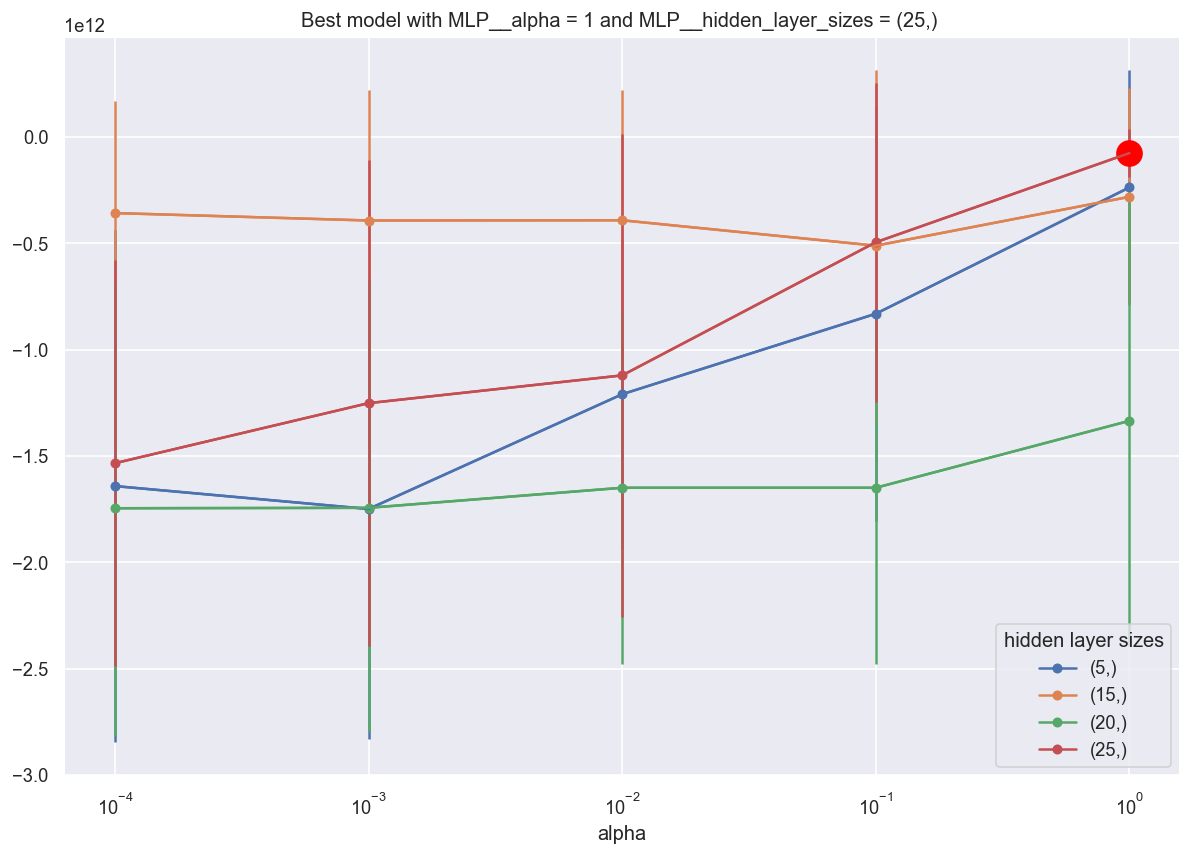

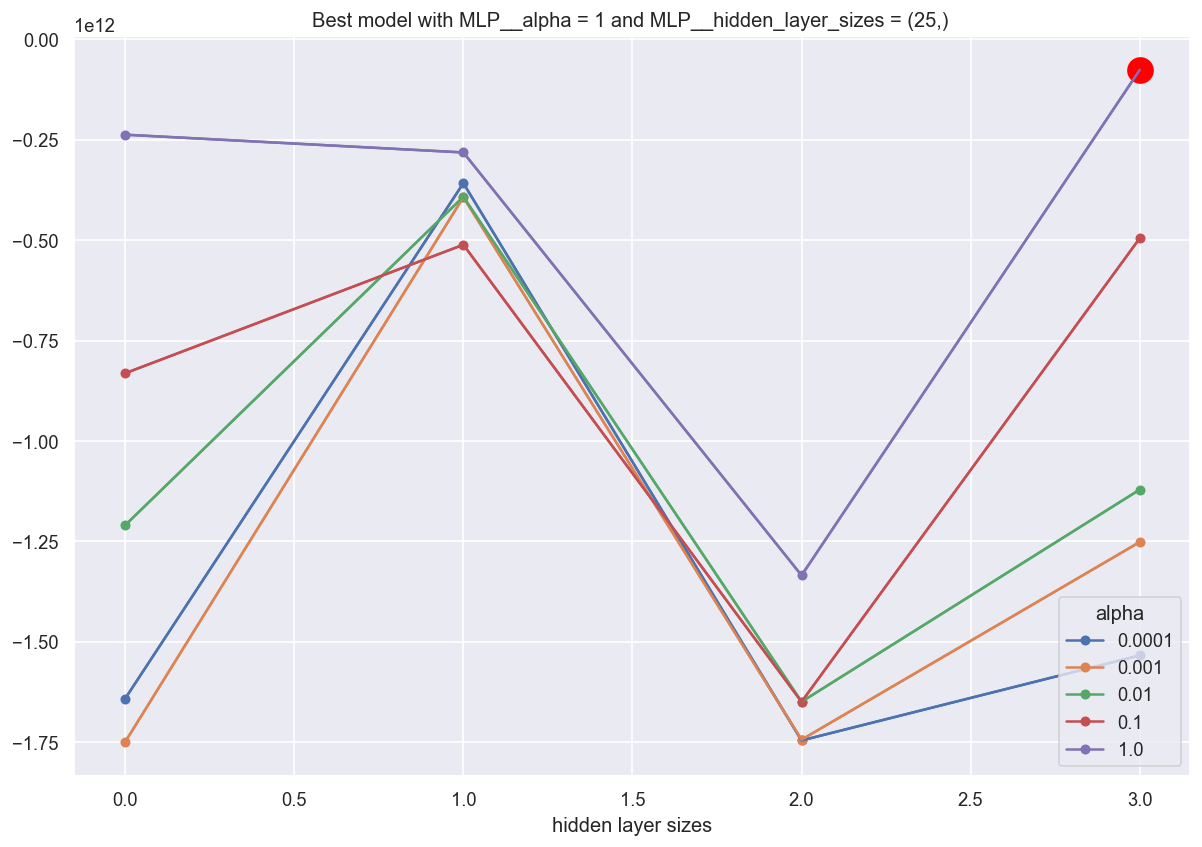

In [426]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [427]:
X

TOTAL_lag1
DATE                  
2001-03-01   2017389.0
2001-04-01   1993273.0
2001-05-01   1981006.0
2001-06-01   1910453.0
2001-07-01   1898285.0
...                ...
2023-06-01   2788370.0
2023-07-01   2739110.0
2023-08-01   2688842.0
2023-09-01   2677874.0
2023-10-01   2702700.0

[272 rows x 1 columns]

In [428]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)

#X = pd.DataFrame(X.toarray(), columns=coefnames)
y = pd.DataFrame(y_train, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [1, 25, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                          mean           std  mean_squared
num__TOTAL_lag1  662046.844088  8.707866e+06  8.732997e+06


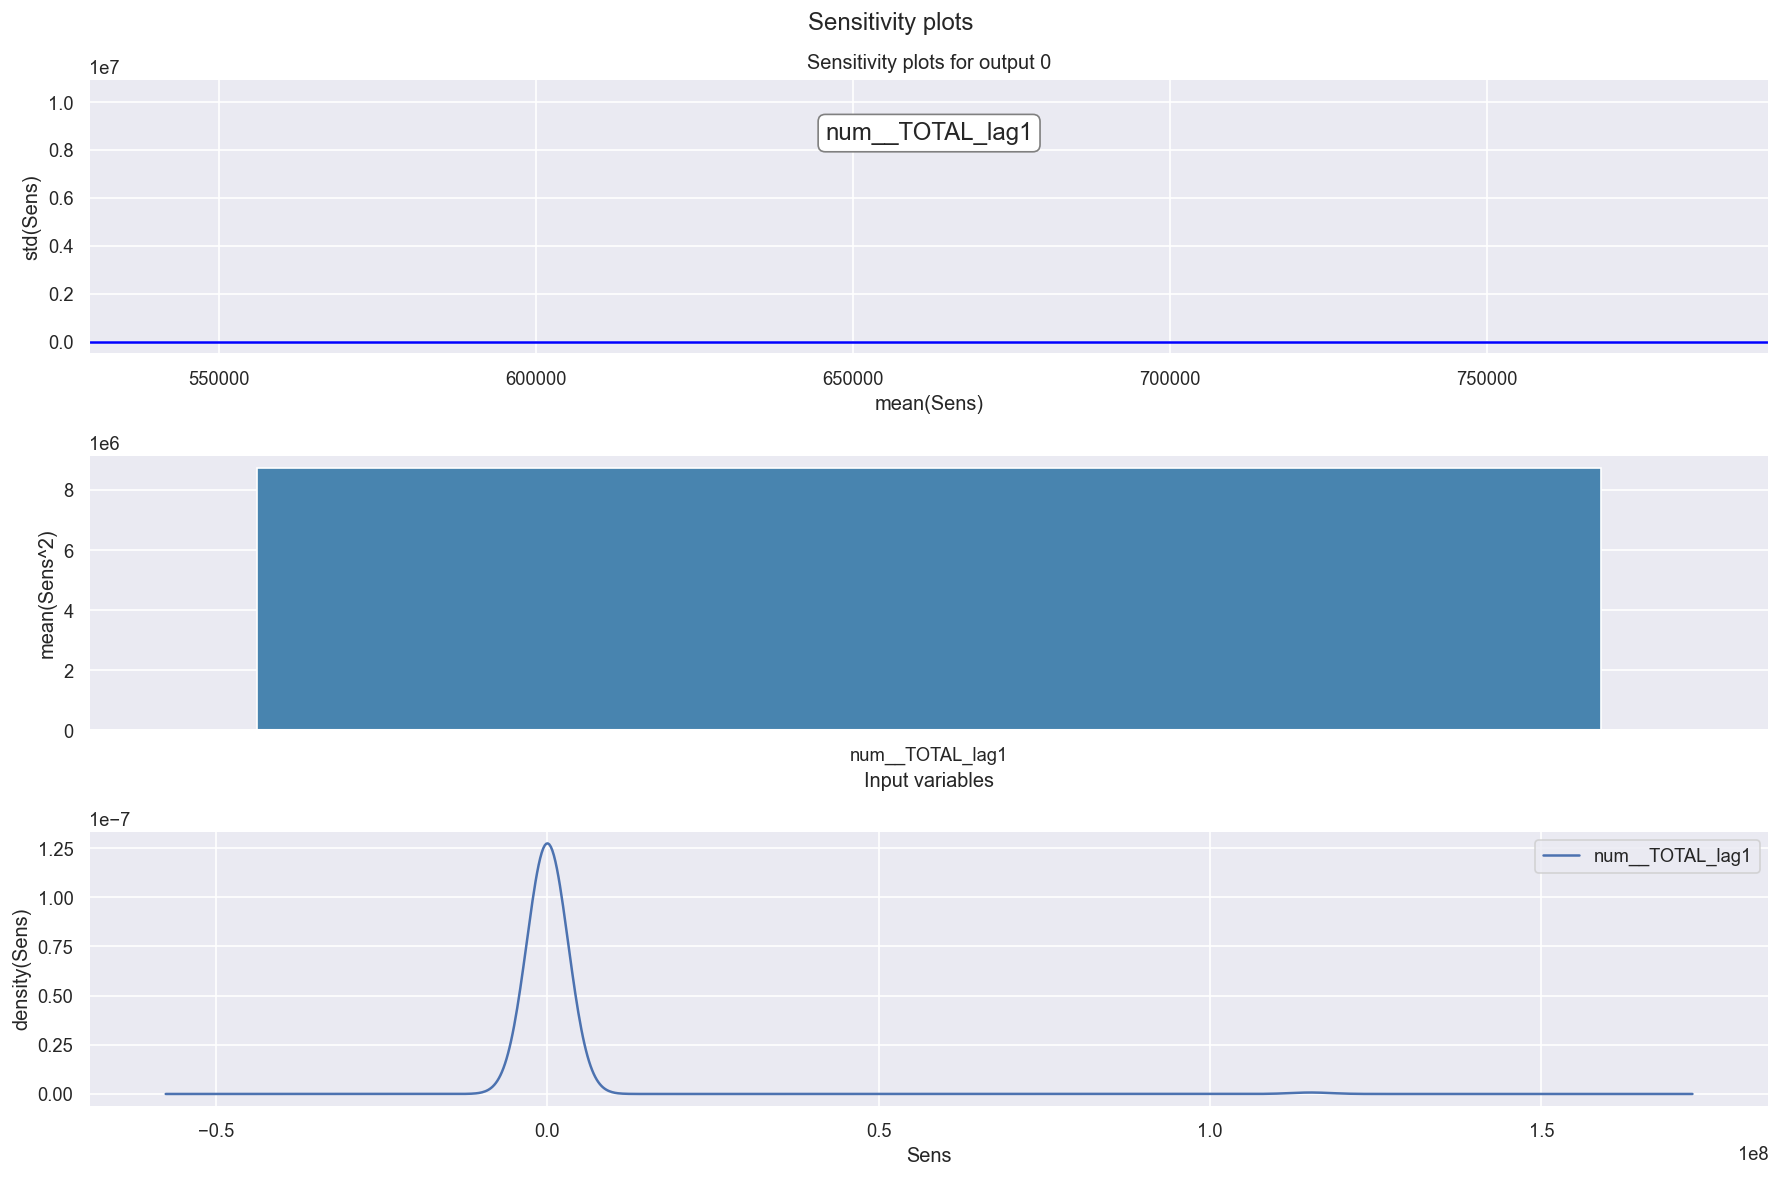

In [429]:
sensmlp.plot()

In [430]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 231555.38095506953
Test MAE: 720614.2738203569
Training RMSE: 328042.43379729724
Test RMSE: 787226.5038883616
Training R2: 0.9196569356020206
Test R2: -5.170068094211533


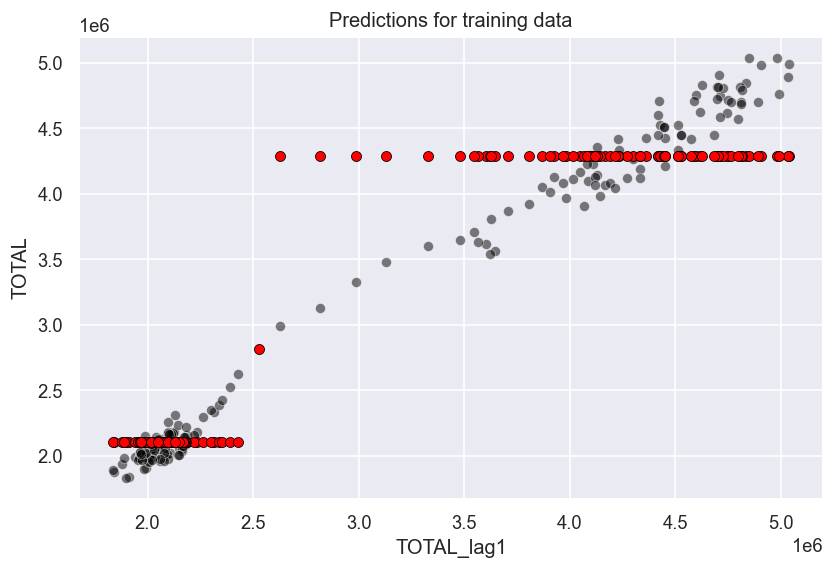

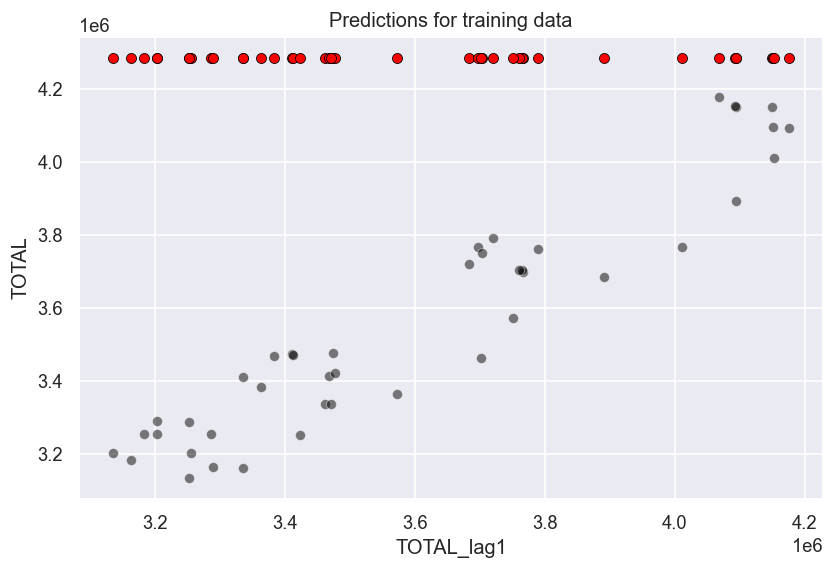

In [431]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


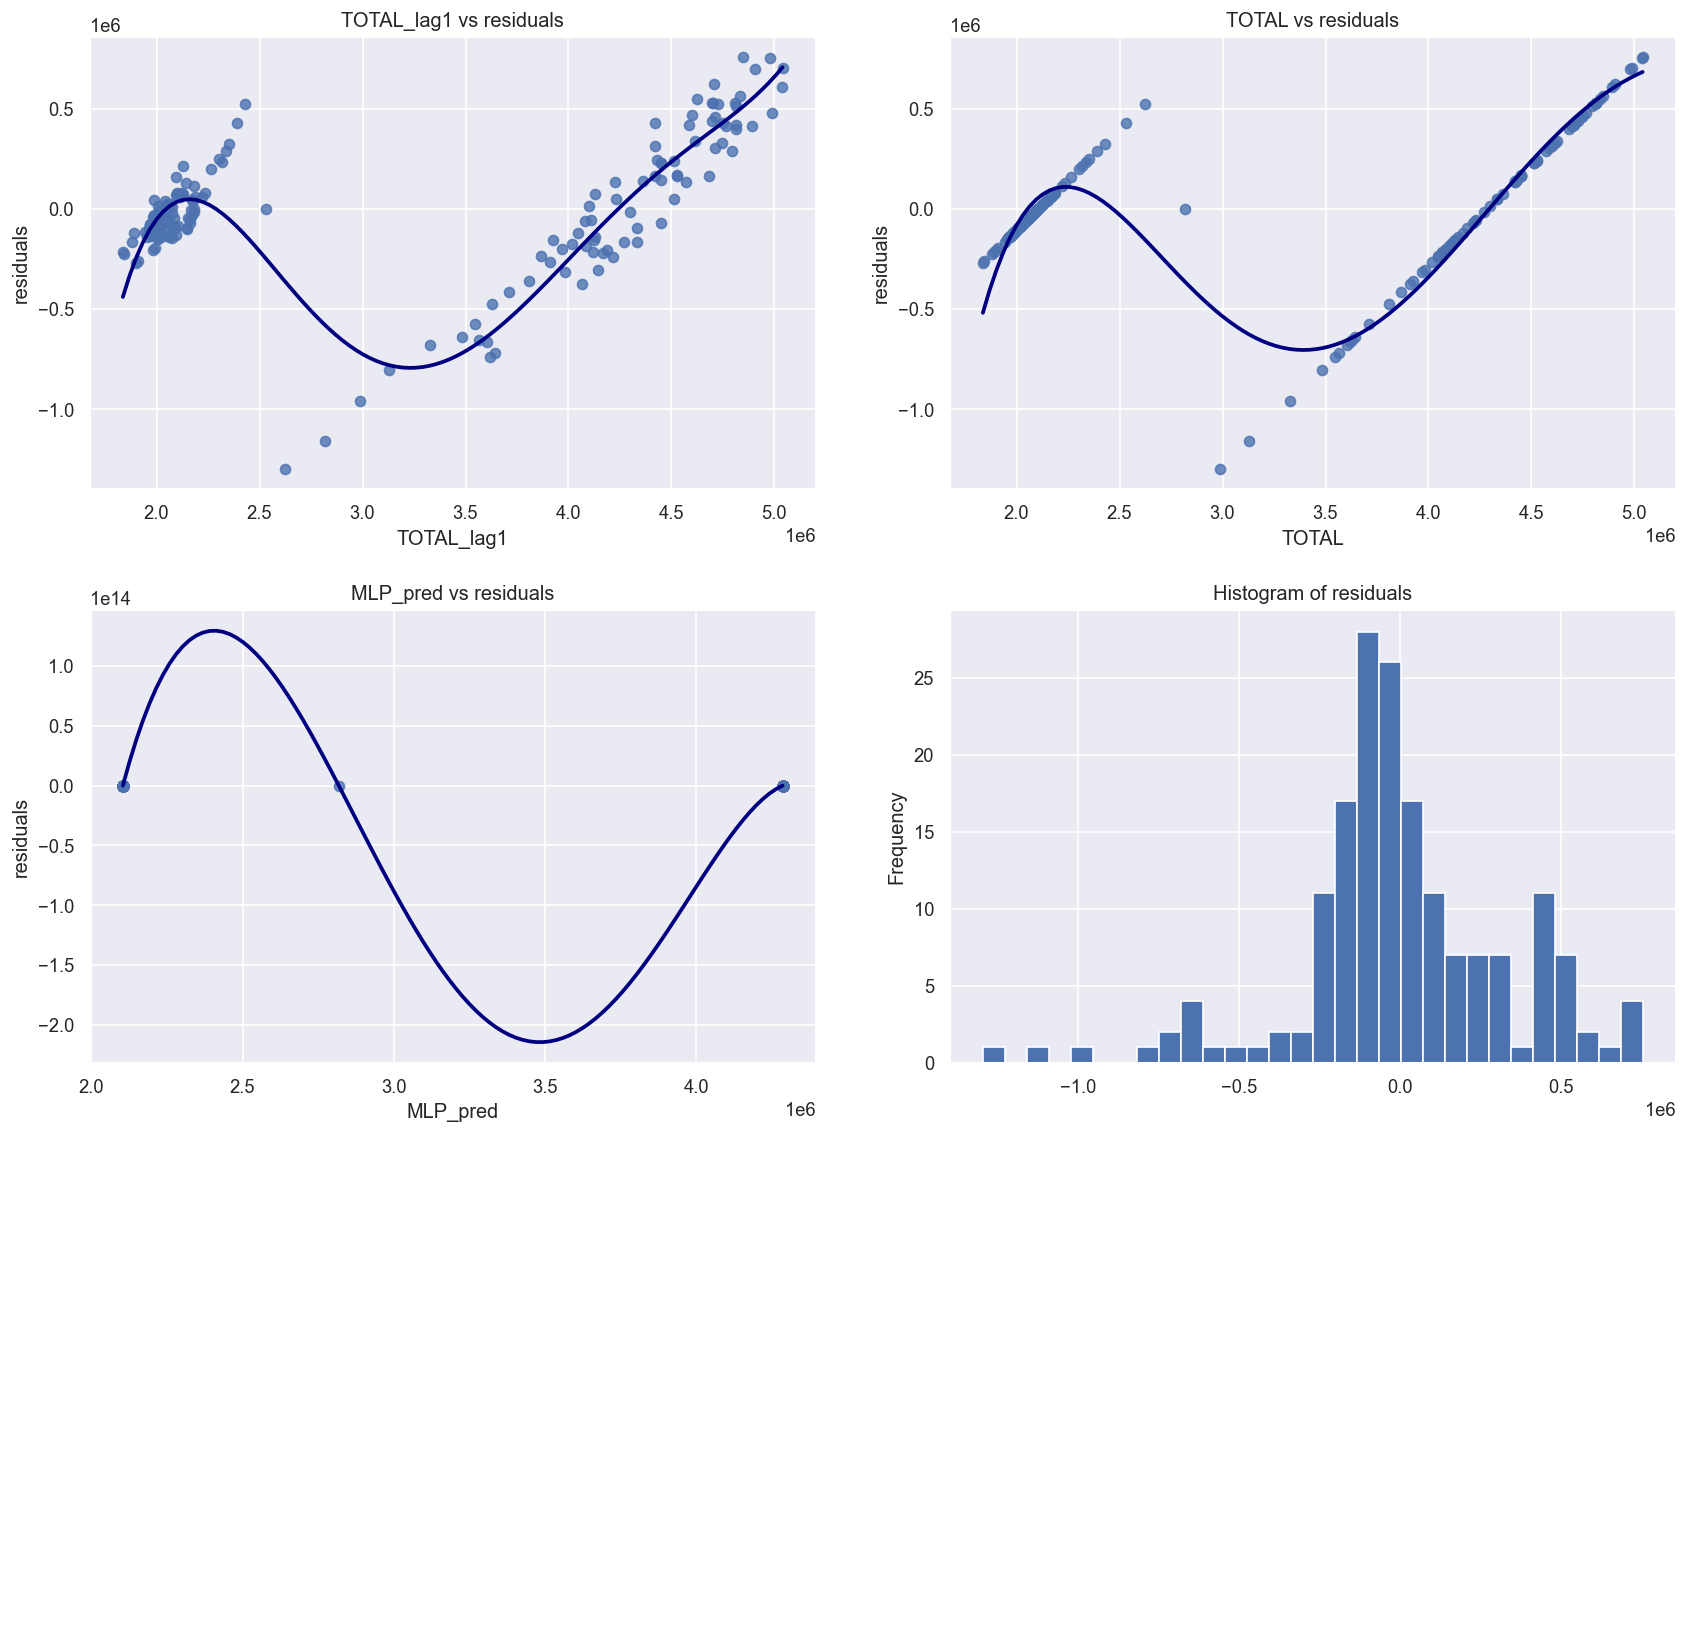

In [432]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

# MLP_Con_Covid

In [433]:
# Extract year and month
df['COVID'] = df.COVID.astype('category')

In [482]:
###Include lagged variables
dfT = df[['TOTAL','COVID']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
#dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL COVID  TOTAL_lag1
DATE                                 
2001-01-01  2017389     0         NaN
2001-02-01  1993273     0         NaN
2001-03-01  1981006     0   2017389.0
2001-04-01  1910453     0   1993273.0
2001-05-01  1898285     0   1981006.0

In [483]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL COVID  TOTAL_lag1
DATE                                 
2001-03-01  1981006     0   2017389.0
2001-04-01  1910453     0   1993273.0
2001-05-01  1898285     0   1981006.0
2001-06-01  1842556     0   1910453.0
2001-07-01  1835738     0   1898285.0

In [484]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2.head()

TOTAL_lag1 COVID
DATE                        
2001-03-01   2017389.0     0
2001-04-01   1993273.0     0
2001-05-01   1981006.0     0
2001-06-01   1910453.0     0
2001-07-01   1898285.0     0

In [493]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1']
INPUTS_MLP_CAT = ['COVID'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.001, 0.01,0.1,1,10], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(3,), (5,),(5,5),(10,),(10,10),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train2[INPUTS_MLP], y_train2) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22275D+12    |proj g|=  3.38877D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20019D+12    |proj g|=  3.37764D+06

At iterate    1    f=  4.61957D+12    |proj g|=  2.87705D+06

At iterate    2    f=  4.80876D+11    |proj g|=  3.67856D+00

At iterate    3    f=  4.80873D+11    |proj g|=  2.42137D+00

At iterate    4    f=  4.80871D+11    |proj g|=  1.10220D+00

At iterate    5    f=  4.80871D+11    |proj g|=  9.08961D-01

At iterate    6    f=  4.80870D+11    |proj g|=  4.67486D-01

At iterate    7    f=  4.80870D+11    |proj g|=  1.58080D-01

At iterate    1    f=  4.60219D+12    |proj g|=  2.86574D+06

At iterate    2    f=  4.95964D+11    |proj g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem i


At iterate    6    f=  4.95958D+11    |proj g|=  4.56939D-01

At iterate    8    f=  4.80870D+11    |proj g|=  3.59628D-04

At iterate    1    f=  4.61251D+12    |proj g|=  2.87224D+06

At iterate    2    f=  4.87620D+11    |proj g|=  3.66914D+00

At iterate    9    f=  4.80870D+11    |proj g|=  1.72462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      9     38      1     0     0   1.725D-03   4.809D+11
  F =   480870422605.72668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mber of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      8     46      1     0     0   2.597D-01   5.412D+11
  F =   541242862954.83807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    1    f=  4.28872D+12    |proj g|=  2.72500D+06

At iterate    2    f=  5.75907D+11    |proj g|=  3.42641D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21350D+12    |proj g|=  3.38405D+06

At iterate    3    f=  5.75904D+11    |proj g|=  2.31257D+00

At iterate    4    f=  5.75902D+11    |proj g|=  1.07676D+00

At iterate    5    f=  5.75902D+11    |proj g|=  8.84697D-01

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


   0    f=  5.28724D+12    |proj g|=  3.10454D+06

At iterate    4    f=  4.95962D+11    |proj g|=  4.59985D+00

At iterate    5    f=  4.95959D+11    |proj g|=  8.45547D-01

At iterate    6    f=  4.95959D+11    |proj g|=  8.01290D-01

At iterate    7    f=  4.95958D+11    |proj g|=  8.95145D-04

At iterate    8    f=  4.95958D+11    |proj g|=  1.20032D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21      8     26      1     0     0   1.200D-06   4.960D+11
  F =   495958294113.10358     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate    1    f=  4.92761D+12    |proj g|=  2.98645D+06




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


roj g|=  2.19261D+05

At iterate    2    f=  4.14570D+12    |proj g|=  2.70733D+06

At iterate    4    f=  4.87796D+11    |proj g|=  1.85531D+04

At iterate    5    f=  4.87624D+11    |proj g|=  4.43710D+00

At iterate    3    f=  5.04879D+11    |proj g|=  2.19089D+05

At iterate    4    f=  4.81051D+11    |proj g|=  1.85090D+04

At iterate    5    f=  4.80879D+11    |proj g|=  4.44400D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55775D+12    |proj g|=  3.16749D+06

At iterate    6    f=  4.87622D+11    |proj g|=  9.39959D+01

At iterate    6    f=  4.80878D+11    |proj g|=  9.45046D+01

At iterate    1    f=  5.19102D+12    |proj g|=  3.04952D+06

At iterate    2    f=  9.22502D+11    |proj g|=  8.73219D+05

At iterate    3    f=  5.41249D+11    |proj g|=  3.69863D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.2

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    7    f=  4.95966D+11    |proj g|=  3.91551D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28724D+12    |proj g|=  3.10454D+06

At iterate    7    f=  5.22167D+11    |proj g|=  3.87358D+00

At iterate    1    f=  5.28722D+12    |proj g|=  3.10453D+06

At iterate    8    f=  4.95964D+11    |proj g|=  3.38362D+00

At iterate    9    f=  4.95959D+11    |proj g|=  9.18244D-01

At iterate   10    f=  4.95958D+11    |proj g|=  4.19130D-01

At iterate   11    f=  4.95958D+11    |proj g|=  6.66982D-03

At iterate   12    f=  4.95958D+11    |proj g|=  1.55007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


g|=  1.05575D+00

At iterate    6    f=  4.50770D+11    |proj g|=  1.21318D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   51      6     36      2     0     0   1.213D+01   4.508D+11
  F =   450770378523.09747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11547D+12    |proj g|=  3.34464D+06

At iterate    1    f=  6.11500D+12    |proj g|=  1.88933D+07

At iterate    2    f=  1.82189D+12    |proj g|=  1.6

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


7D+11    |proj g|=  1.01114D+07

At iterate   33    f=  1.66746D+11    |proj g|=  7.28075D+06

At iterate   14    f=  2.59755D+11    |proj g|=  3.51595D+05

At iterate   34    f=  1.66744D+11    |proj g|=  5.21375D+06

At iterate   18    f=  4.51286D+10    |proj g|=  1.36904D+07

At iterate   19    f=  4.46094D+10    |proj g|=  3.13168D+08

At iterate   35    f=  1.66744D+11    |proj g|=  1.07616D+06

At iterate   36    f=  1.66744D+11    |proj g|=  1.87184D+06

At iterate   37    f=  1.66744D+11    |proj g|=  1.17577D+06

At iterate   20    f=  4.45576D+10    |proj g|=  3.47974D+08

At iterate   38    f=  1.66743D+11    |proj g|=  3.57837D+06

At iterate   21    f=  4.44414D+10    |proj g|=  1.95015D+08

At iterate   39    f=  1.66743D+11    |proj g|=  3.70357D+06

At iterate   40    f=  1.66741D+11    |proj g|=  4.08492D+06

At iterate   41    f=  1.66736D+11    |proj g|=  4.77490D+06

At iterate   42    f=  1.66728D+11    |proj g|=  5.71517D+06

At iterate   43    f=  1.66694D+11   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   68    f=  9.64853D+10    |proj g|=  1.77514D+08

At iterate  202    f=  3.59558D+10    |proj g|=  4.66861D+07

At iterate   69    f=  8.73960D+10    |proj g|=  7.88468D+07

At iterate  203    f=  3.59381D+10    |proj g|=  1.09517D+08

At iterate  204    f=  3.58885D+10    |proj g|=  2.05900D+08

At iterate   70    f=  7.35329D+10    |proj g|=  1.39938D+08

At iterate   10    f=  5.46576D+11    |proj g|=  4.37735D+03

At iterate   71    f=  6.40152D+10    |proj g|=  1.04526D+08

At iterate  205    f=  3.37777D+10    |proj g|=  1.93156D+09
  ys=-7.208E+09  -gs= 4.623E+08 BFGS update SKIPPED

At iterate  206    f=  3.37413D+10    |proj g|=  1.96877D+09

At iterate   72    f=  6.25490D+10    |proj g|=  1.75417D+08

At iterate  207    f=  3.36589D+10    |proj g|=  1.63205D+09

At iterate   73    f=  5.98900D+10    |proj g|=  1.91305D+08

At iterate  208    f=  3.21562D+10    |proj g|=  1.21038D+09

At iterate  182    f=  3.48465D+10    |proj g|=  3.77560D+08

At iterate   74  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


 f=  3.90526D+11    |proj g|=  1.55098D+08

At iterate  170    f=  5.91700D+10    |proj g|=  9.70448D+05

At iterate  395    f=  1.08618D+10    |proj g|=  1.04201D+09

At iterate   12    f=  3.90144D+11    |proj g|=  4.41834D+07

At iterate  171    f=  5.91700D+10    |proj g|=  1.08284D+06

At iterate  396    f=  1.07069D+10    |proj g|=  6.39392D+08

At iterate   13    f=  3.88868D+11    |proj g|=  1.85592D+08

At iterate  172    f=  5.91699D+10    |proj g|=  7.07787D+05

At iterate  397    f=  1.06856D+10    |proj g|=  1.18735D+08

At iterate  173    f=  5.91699D+10    |proj g|=  1.24619D+06

At iterate  398    f=  1.06815D+10    |proj g|=  9.67651D+07

At iterate  174    f=  5.91699D+10    |proj g|=  2.11187D+06

At iterate  399    f=  1.06785D+10    |proj g|=  9.85798D+07

At iterate  175    f=  5.91698D+10    |proj g|=  3.87558D+06

At iterate  400    f=  1.06688D+10    |proj g|=  1.68253D+08

At iterate  176    f=  5.91696D+10    |proj g|=  5.30787D+06

At iterate  401    f=  1.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;

    |proj g|=  8.28724D+06

At iterate  409    f=  1.06532D+10    |proj g|=  1.19576D+07

At iterate  184    f=  5.91659D+10    |proj g|=  1.82445D+07

At iterate  410    f=  1.06530D+10    |proj g|=  2.74080D+07

At iterate  185    f=  5.91622D+10    |proj g|=  1.85879D+07

At iterate  411    f=  1.06527D+10    |proj g|=  5.62028D+07

At iterate  186    f=  5.91591D+10    |proj g|=  3.85103D+07

At iterate  412    f=  1.06520D+10    |proj g|=  7.03913D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          101     M =           10

At X0         0 variables are exactly at the bounds

At iterate  187    f=  5.91447D+10    |proj g|=  3.57365D+07

At iterate    0    f=  6.11547D+12    |proj g|=  3.34464D+06

At iterate  413    f=  1.06515D+10    |proj g|=  1.33822D+08

At iterate  188    f=  5.90916D+10    |proj g|=  4.59575D+07

At iterate  414    f=  1.06511D+10    |proj g|=  6.57516D+07

At iterate  415    f=  1.06508D+10    |proj g|=  1.86283D+07


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=  2.60885D+08

At iterate   43    f=  3.67267D+11    |proj g|=  1.21668D+08

At iterate   44    f=  3.66933D+11    |proj g|=  3.34019D+07

At iterate   45    f=  3.66924D+11    |proj g|=  2.45952D+07

At iterate   46    f=  3.66871D+11    |proj g|=  1.11330D+07

At iterate   47    f=  3.66738D+11    |proj g|=  6.60803D+07

At iterate   14    f=  3.97071D+11    |proj g|=  4.12268D+06

At iterate   48    f=  3.66733D+11    |proj g|=  3.47621D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55776D+12    |proj g|=  3.16750D+06

At iterate   49    f=  3.66696D+11    |proj g|=  3.32084D+07

At iterate    1    f=  5.55716D+12    |proj g|=  1.53012D+07

At iterate  217    f=  2.17565D+10    |proj g|=  2.22242D+08

At iterate  218    f=  2.15512D+10    |proj g|=  1.74403D+08

At iterate  219    f=  2.14959D+10    |proj g|=  1.40175D+08

At iterate 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


2    |proj g|=  3.23810D+06

At iterate   80    f=  3.41068D+11    |proj g|=  1.47587D+07

At iterate   81    f=  3.40761D+11    |proj g|=  1.10330D+08

At iterate    1    f=  5.81787D+12    |proj g|=  1.41516D+07

At iterate  265    f=  1.46278D+10    |proj g|=  8.06561D+08

At iterate    2    f=  3.00207D+12    |proj g|=  2.20280D+06

At iterate   82    f=  3.40480D+11    |proj g|=  2.51481D+07

At iterate   83    f=  3.39687D+11    |proj g|=  2.93970D+07

At iterate    3    f=  5.98482D+11    |proj g|=  2.12490D+05

At iterate   84    f=  3.39565D+11    |proj g|=  2.58402D+06

At iterate    4    f=  5.75987D+11    |proj g|=  1.27506D+04

At iterate    5    f=  5.75906D+11    |proj g|=  2.23505D+00

At iterate   85    f=  3.39131D+11    |proj g|=  3.33528D+07

At iterate    6    f=  5.75904D+11    |proj g|=  1.19109D+02

At iterate    5    f=  5.75904D+11    |proj g|=  1.57044D+00

At iterate    7    f=  5.75904D+11    |proj g|=  9.24501D+01

At iterate   86    f=  3.38910D+11    |pr


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unco

 17    f=  4.63308D+11    |proj g|=  1.87681D+08

At iterate  251    f=  2.98157D+10    |proj g|=  8.99397D+05

At iterate  252    f=  2.98157D+10    |proj g|=  1.54093D+06

At iterate   18    f=  4.63183D+11    |proj g|=  1.07725D+08

At iterate  253    f=  2.98156D+10    |proj g|=  2.57874D+06


At iterate  254    f=  2.98155D+10    |proj g|=  4.29442D+06
At iterate   19    f=  4.63083D+11    |proj g|=  2.30186D+07

At iterate  255    f=  2.98151D+10    |proj g|=  7.17505D+06

At iterate   20    f=  4.62999D+11    |proj g|=  6.26751D+07

At iterate   11    f=  3.65250D+11    |proj g|=  7.82012D+07

At iterate  256    f=  2.98141D+10    |proj g|=  1.26930D+07

At iterate   21    f=  4.62919D+11    |proj g|=  9.86587D+07

At iterate   22    f=  4.62465D+11    |proj g|=  8.14194D+07

At iterate   23    f=  4.60969D+11    |proj g|=  5.63311D+07

At iterate   12    f=  3.65201D+11    |proj g|=  2.44068D+07

At iterate   13    f=  3.52804D+11    |proj g|=  4.23738D+05

At iterate   14    f

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ne precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81855D+12    |proj g|=  3.23810D+06

At iterate    1    f=  4.28872D+12    |proj g|=  2.72500D+06

At iterate    2    f=  5.75952D+11    |proj g|=  3.42637D+01

At iterate   10    f=  5.41245D+11    |proj g|=  1.11828D+00

At iterate   52    f=  5.28941D+10    |proj g|=  1.00753D+05
  ys=-4.360E+08  -gs= 3.396E+05 BFGS update SKIPPED

At iterate    3    f=  5.75937D+11    |proj g|=  2.62070D+01

At iterate    4    f=  5.75905D+11    |proj g|=  1.07670D+01

At iterate    5    f=  5.75903D+11    |proj g|=  8.80965D+00

At iterate    6    f=  5.75902D+11    |proj g|=  3.22417D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22274D+12    |proj g|=  3.38877D+06

At iterate    7    f=  5.75901D+11    |proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


f=  5.81855D+12    |proj g|=  3.23810D+06

At iterate    0    f=  6.20019D+12    |proj g|=  3.37764D+06

At iterate    6    f=  4.87616D+11    |proj g|=  7.82737D+00

At iterate    5    f=  5.46576D+11    |proj g|=  7.88142D+00

At iterate    7    f=  4.87615D+11    |proj g|=  1.72460D-03

At iterate    6    f=  5.46575D+11    |proj g|=  7.27882D+00

At iterate    7    f=  5.46574D+11    |proj g|=  1.52923D-03

At iterate    8    f=  4.87615D+11    |proj g|=  7.37082D-07

           * * *

Tit   = total number of iterations



Tnf   = total number of function evaluations
At iterate    8    f=  5.46574D+11    |proj g|=  6.51836D-07
At iterate    1    f=  5.44355D+12    |proj g|=  3.12014D+06
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


50315D+01

At iterate   16    f=  5.46619D+11    |proj g|=  1.43931D+05

At iterate    7    f=  5.46603D+11    |proj g|=  4.91686D+01

At iterate   17    f=  5.46619D+11    |proj g|=  1.29523D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   51     17    113      2     0     0   1.295D+03   5.466D+11
  F =   546619334613.61359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    5    f=  4.87658D+11    |proj g|=  6.63117D+01

At iterate    8    f=  5.46600D+11    |proj g|=  4.32349D+01

At iterate   38    f=  1.08534D+11    |proj g|=  2.83064D+08
  ys=-1.518E+10  -gs= 1.364E+06 BFGS upda

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


    3    f=  2.12900D+12    |proj g|=  1.83204D+06

At iterate    4    f=  4.50813D+11    |proj g|=  3.22088D+01

At iterate   13    f=  5.75905D+11    |proj g|=  5.97241D+01

At iterate    5    f=  4.50799D+11    |proj g|=  3.56799D+01

At iterate    6    f=  4.50785D+11    |proj g|=  2.48711D+01

At iterate    7    f=  4.50781D+11    |proj g|=  2.05871D+01

At iterate   22    f=  7.54279D+10    |proj g|=  1.67214D+08

At iterate   23    f=  7.32855D+10    |proj g|=  5.64609D+08

At iterate    8    f=  4.50778D+11    |proj g|=  1.79489D+01

At iterate   14    f=  5.75905D+11    |proj g|=  8.76932D+00

At iterate    9    f=  4.50778D+11    |proj g|=  2.40236D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


roj g|=  1.88026D+07

At iterate   47    f=  4.97749D+10    |proj g|=  4.94934D+08
  ys=-2.209E+10  -gs= 2.027E+08 BFGS update SKIPPED

At iterate   46    f=  4.94567D+10    |proj g|=  1.25235D+07

At iterate   48    f=  4.92583D+10    |proj g|=  5.04688D+08

At iterate    6    f=  4.06070D+11    |proj g|=  1.28441D+09
  ys=-9.046E+11  -gs= 2.184E+06 BFGS update SKIPPED

At iterate   49    f=  4.92117D+10    |proj g|=  2.80520D+08

At iterate   50    f=  4.91469D+10    |proj g|=  2.27329D+08

At iterate   51    f=  4.91046D+10    |proj g|=  1.06005D+08

At iterate   52    f=  4.90883D+10    |proj g|=  8.97221D+07

At iterate   53    f=  4.90847D+10    |proj g|=  3.28684D+07

At iterate   54    f=  4.90836D+10    |proj g|=  4.17829D+07

At iterate   55    f=  4.90822D+10    |proj g|=  1.92032D+07

At iterate   56    f=  4.90808D+10    |proj g|=  1.95465D+07

At iterate   57    f=  4.90784D+10    |proj g|=  1.70302D+07

At iterate   58    f=  4.90753D+10    |proj g|=  1.49219D+07

At ite

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iterat


At iterate   43    f=  2.58646D+11    |proj g|=  1.97531D+08

At iterate  116    f=  3.67413D+10    |proj g|=  8.67281D+06

At iterate    6    f=  4.50795D+11    |proj g|=  7.47347D+02

At iterate   44    f=  2.51880D+11    |proj g|=  8.76936D+06

At iterate    7    f=  4.50790D+11    |proj g|=  7.56549D+02

At iterate  117    f=  3.67402D+10    |proj g|=  1.07149D+07


At iterate  118    f=  3.67392D+10    |proj g|=  2.31774D+06
At iterate   45    f=  2.51095D+11    |proj g|=  1.31045D+07

At iterate    8    f=  4.50786D+11    |proj g|=  6.21074D+02

At iterate  119    f=  3.67387D+10    |proj g|=  3.73589D+06

At iterate   85    f=  8.94386D+09    |proj g|=  2.29613D+07

At iterate  120    f=  3.67384D+10    |proj g|=  1.45682D+07

At iterate   86    f=  8.94386D+09    |proj g|=  2.09816D+07

At iterate  121    f=  3.67369D+10    |proj g|=  5.99721D+06

At iterate   87    f=  8.94386D+09    |proj g|=  2.09645D+07

At iterate  122    f=  3.67310D+10    |proj g|=  1.31952D+07

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.



At iterate  299    f=  4.78567D+10    |proj g|=  8.52831D+08

At iterate  226    f=  7.07144D+10    |proj g|=  6.95777D+07

At iterate  227    f=  6.93939D+10    |proj g|=  9.72524D+07

At iterate  228    f=  6.83587D+10    |proj g|=  4.48117D+07

At iterate  229    f=  6.83438D+10    |proj g|=  6.81949D+06

At iterate  230    f=  6.83156D+10    |proj g|=  2.62603D+07

At iterate  218    f=  2.62603D+11    |proj g|=  9.78819D+07

At iterate  300    f=  4.78182D+10    |proj g|=  9.74142D+08

At iterate  219    f=  2.62590D+11    |proj g|=  9.21888D+07

At iterate  220    f=  2.61605D+11    |proj g|=  2.79198D+05

At iterate  301    f=  4.78140D+10    |proj g|=  1.46123D+09

At iterate  302    f=  4.74742D+10    |proj g|=  3.58682D+08

At iterate  303    f=  4.70688D+10    |proj g|=  6.91965D+08

At iterate  221    f=  2.61299D+11    |proj g|=  1.38125D+07

At iterate  304    f=  4.68493D+10    |proj g|=  2.03463D+09

At iterate  231    f=  6.83148D+10    |proj g|=  2.36704D+07

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase t

  6.34707D+10    |proj g|=  4.20021D+06

At iterate  354    f=  5.39479D+10    |proj g|=  1.45957D+07

At iterate  413    f=  6.34701D+10    |proj g|=  7.25312D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55776D+12    |proj g|=  3.16750D+06

At iterate  414    f=  6.34694D+10    |proj g|=  6.25293D+06

At iterate  415    f=  6.34689D+10    |proj g|=  4.02032D+06

At iterate  355    f=  5.39470D+10    |proj g|=  1.36366D+07

At iterate  416    f=  6.34688D+10    |proj g|=  2.34740D+06

At iterate    1    f=  4.28874D+12    |proj g|=  2.72500D+06

At iterate  417    f=  6.34687D+10    |proj g|=  1.08288D+06

At iterate  356    f=  5.39463D+10    |proj g|=  1.54653D+07

At iterate    2    f=  5.76412D+11    |proj g|=  3.42596D+02

At iterate  418    f=  6.34687D+10    |proj g|=  1.21732D+06

At iterate  419    f=  6.34686D+10    |proj g|= 


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21      8     22      1     0     0   2.647D-05   5.759D+11
  F =   575901437045.79150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate    1    f=  5.77200D+12    |proj g|=  6.12086D+06

At iterate    1    f=  5.19102D+12    |proj g|=  3.04952D+06

At iterate    2    f=  9.22888D+11    |proj g|=  8.73312D+05

At iterate    3    f=  5.41830D+11    |proj g|=  3.69788D+02

At iterate    2    f=  4.14572D+12    |proj g|=  2.70733D+06

At iterate    2    f=  3.59364D+12    |proj g|=  2.46084D+06

At iterate    3    f=  6.49611D+11    |proj g|=  4.07715D+05


At iterate    4    f=  5.41704D+11    |proj g|=  2.70192D+02
At iterate    3    f=  5.05802D+11    |proj g|=  2.19615D+05

At iterate    4    f=  5.66485D+11    |proj g|=  4.63070D+02

At iterate    5    f=  5.41268D+11    |proj g|=  8.03005D+01

At iterate    4    f=  4.81935D+11    |proj g


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained

At iterate  119    f=  8.89841D+10    |proj g|=  1.29061D+09

At iterate  120    f=  8.89012D+10    |proj g|=  9.41416D+08

At iterate  121    f=  8.88467D+10    |proj g|=  3.60641D+08

At iterate  122    f=  8.88086D+10    |proj g|=  2.87218D+08

At iterate  123    f=  8.87881D+10    |proj g|=  1.50886D+08

At iterate  124    f=  8.87771D+10    |proj g|=  3.87841D+07

At iterate  171    f=  1.29036D+11    |proj g|=  6.63232D+07

At iterate  172    f=  1.29027D+11    |proj g|=  1.69917D+07


At iterate  125    f=  8.87760D+10    |proj g|=  7.88606D+07
At iterate   35    f=  1.87789D+11    |proj g|=  1.57008D+08

At iterate  126    f=  8.87743D+10    |proj g|=  3.51370D+07
At iterate  152    f=  6.77532D+10    |proj g|=  1.03176D+10

At iterate  153    f=  6.15221D+10    |proj g|=  5.17436D+09

At iterate   36    f=  1.87750D+11    |proj g|=  1.45063D+08

At iterate  154    f=  5.46654D+10    |proj g|=  1.27144D+10

At iterate   37    f=  1.87471D+11    |proj g|=  1.79376D+07

At iterat

 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate    7    f=  5.65735D+11    |proj g|=  4.88493D-01

At iterate    8    f=  5.65735D+11    |proj g|=  1.38960D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  141      8     33      1     0     0   1.390D+00   5.657D+11
  F =   565734524823.02734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22275D+12    |proj g|=  3.38877D+06

At iterate    1    f=  6.22211D+12    |proj g|=  1.63240D+07

At iter

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    4    f=  4.87867D+11    |proj g|=  1.73284D+02

At iterate    5    f=  4.87845D+11    |proj g|=  1.62959D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11547D+12    |proj g|=  3.34464D+06

At iterate    4    f=  4.96210D+11    |proj g|=  1.72944D+02

At iterate    5    f=  4.96184D+11    |proj g|=  1.60730D+02

At iterate    5    f=  4.81097D+11    |proj g|=  1.61109D+02

At iterate    6    f=  4.96178D+11    |proj g|=  1.57970D+02

At iterate    6    f=  4.87834D+11    |proj g|=  1.57700D+02

At iterate    1    f=  6.11485D+12    |proj g|=  1.61387D+07

At iterate    2    f=  4.17986D+12    |proj g|=  2.70469D+06

At iterate    3    f=  5.22508D+11    |proj g|=  2.08304D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  4.81097D+11    |proj g|=  1.42375D+02

At iterate    4    f=  5.22406D+11    |proj g|=  1.71208D+02

At iterate    7    f=  4.87833D+11    |proj g|=  7.97368D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  5.22384D+11    |proj g|=  1.60955D+02

At iterate    7    f=  4.81072D+11    |proj g|=  1.19736D+02

At iterate    8    f=  4.81004D+11    |proj g|=  9.96721D+01

At iterate    9    f=  4.80992D+11    |proj g|=  1.03113D+02

At iterate   10    f=  4.80903D+11    |proj g|=  8.08943D+01

At iterate   11    f=  4.80874D+11    |proj g|=  2.86599D+01

At iterate   12    f=  4.80870D+11    |proj g|=  3.51219D+00

At iterate   13    f=  4.80870D+11    |proj g|=  2.38994D-01

At iterate   14    f=  4.80870D+11    |proj g|=  1.41923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   81     14     59   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and

-1.413E+05  -gs= 3.174E+09 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58532D+12    |proj g|=  3.17451D+06

At iterate    1    f=  5.58473D+12    |proj g|=  1.53377D+07

At iterate    2    f=  3.74867D+12    |proj g|=  2.53065D+06
At iterate    9    f=  5.22280D+11    |proj g|=  1.02054D+02

At iterate   10    f=  5.22191D+11    |proj g|=  7.91420D+01

At iterate   11    f=  5.22164D+11    |proj g|=  2.75808D+01

At iterate   12    f=  5.22160D+11    |proj g|=  3.30950D+00

At iterate   13    f=  5.22160D+11    |proj g|=  2.21164D-01

At iterate   14    f=  5.22160D+11    |proj g|=  1.30746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active b


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


    f=  3.44947D+12    |proj g|=  2.44896D+06

At iterate    3    f=  4.51061D+11    |proj g|=  1.92394D+02

At iterate    7    f=  5.46766D+11    |proj g|=  4.24083D+03

At iterate   24    f=  6.85310D+10    |proj g|=  1.30334D+04

At iterate    4    f=  4.50973D+11    |proj g|=  1.58158D+02

At iterate   25    f=  6.23440D+10    |proj g|=  1.46906D+04

At iterate    5    f=  4.50958D+11    |proj g|=  1.50220D+02

At iterate    6    f=  4.68357D+11    |proj g|=  1.47370D+02

At iterate   26    f=  6.23304D+10    |proj g|=  1.96011D+05

At iterate   27    f=  6.22973D+10    |proj g|=  1.61788D+04

At iterate   28    f=  6.22335D+10    |proj g|=  1.90290D+04

At iterate    8    f=  4.51127D+11    |proj g|=  9.02310D+08

At iterate    9    f=  4.51127D+11    |proj g|=  9.02221D+08

At iterate    7    f=  4.68355D+11    |proj g|=  1.47608D+05

At iterate   10    f=  4.50135D+11    |proj g|=  2.98142D+06

At iterate   11    f=  4.48924D+11    |proj g|=  2.20738D+06

At iterate   12    f=  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


2.73018D+04

At iterate   82    f=  5.88937D+10    |proj g|=  1.18521D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   81     82    255      2     5     0   1.185D+03   5.889D+10
  F =   58893661998.754654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   17    f=  2.30486D+11    |proj g|=  3.22783D+07

At iterate   20    f=  8.36395D+10    |proj g|=  2.35954D+04

At iterate   30    f=  2.87145D+11    |proj g|=  3.43069D+08

At iterate   18    f=  2.30467D+11    |proj g|=  3.19396D+07

At iterate   31    f=  2.87109D+11    |proj g|=  3.59341D+08

At iterate   21    f=  8.36359D+10    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


proj g|=  5.87191D+07

At iterate   54    f=  2.81459D+11    |proj g|=  7.58983D+07

At iterate   55    f=  2.81458D+11    |proj g|=  1.13988D+08

At iterate   56    f=  2.81454D+11    |proj g|=  1.14438D+07

At iterate   57    f=  2.81453D+11    |proj g|=  1.14207D+07

At iterate   58    f=  2.81448D+11    |proj g|=  9.28664D+07

At iterate   59    f=  2.81443D+11    |proj g|=  1.40967D+08

At iterate   60    f=  2.81439D+11    |proj g|=  9.96848D+07

At iterate    4    f=  5.41464D+11    |proj g|=  1.62019D+02

At iterate   61    f=  2.81434D+11    |proj g|=  4.75632D+07

At iterate   62    f=  2.81433D+11    |proj g|=  5.88352D+07

At iterate   23    f=  8.30779D+10    |proj g|=  3.97802D+07

At iterate   24    f=  8.30765D+10    |proj g|=  1.22759D+07

At iterate   63    f=  2.81429D+11    |proj g|=  6.99899D+07

At iterate   25    f=  8.30764D+10    |proj g|=  6.90125D+05

At iterate   64    f=  2.81425D+11    |proj g|=  1.09511D+08

At iterate   65    f=  2.81390D+11    |proj g|=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


246D+08

At iterate   72    f=  1.42340D+11    |proj g|=  1.02268D+09

At iterate   17    f=  8.56306D+10    |proj g|=  8.54029D+08

At iterate   73    f=  1.41844D+11    |proj g|=  2.31134D+08

At iterate   74    f=  1.41693D+11    |proj g|=  1.73145D+08

At iterate   75    f=  1.41499D+11    |proj g|=  3.43313D+08

At iterate   76    f=  1.41453D+11    |proj g|=  2.49219D+08

At iterate   77    f=  1.41385D+11    |proj g|=  2.78591D+08

At iterate   78    f=  1.41308D+11    |proj g|=  2.35661D+08

At iterate   18    f=  8.49951D+10    |proj g|=  8.58304D+08

At iterate   79    f=  1.41139D+11    |proj g|=  2.86672D+08

At iterate   80    f=  1.40790D+11    |proj g|=  7.58481D+08

At iterate   93    f=  1.92676D+11    |proj g|=  2.86141D+09

At iterate   19    f=  7.42244D+10    |proj g|=  1.08444D+09

At iterate   81    f=  1.40620D+11    |proj g|=  4.13498D+08

At iterate   94    f=  1.91827D+11    |proj g|=  1.70921D+08

At iterate   82    f=  1.40491D+11    |proj g|=  9.11276D+08


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   81     14     64      2     0     0   1.362D-02   5.759D+11
  F =   575901437047.02307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   28    f=  6.06480D+10    |proj g|=  1.62639D+08

At iterate   29    f=  6.06356D+10    |proj g|=  1.72519D+08

At iterate   30    f=  6.05602D+10    |proj g|=  9.00925D+07

At iterate   31    f=  6.05260D+10    |proj g|=  1.38785D+08

At iterate   32    f=  6.04664D+10    |proj g|=  1.26597D+08

At iterate  114    f=  1.87370D+11    |proj g|=  2.72144D+08

At iterate   93    f=  1.37046D+11    |proj g|=  1.77598D+08

At iterate   94    f=  1.37040D+11    |proj g|=  8.49172D+07

At iterate  115    f=  1.84771D+11    |proj g|=  7.20634D+08

At iterate  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


   f=  1.83302D+11    |proj g|=  1.46994D+08
At iterate  121    f=  9.23152D+10    |proj g|=  3.24562D+09

At iterate   62    f=  5.25409D+10    |proj g|=  5.27864D+07

At iterate  122    f=  9.17290D+10    |proj g|=  2.04593D+09

At iterate  149    f=  1.83292D+11    |proj g|=  3.35368D+07

At iterate  123    f=  8.96950D+10    |proj g|=  3.11266D+09

At iterate   63    f=  5.25366D+10    |proj g|=  4.18777D+07

At iterate  150    f=  1.83288D+11    |proj g|=  3.19539D+07

At iterate  151    f=  1.83282D+11    |proj g|=  1.12526D+08

At iterate   64    f=  5.25315D+10    |proj g|=  6.08197D+07

At iterate  152    f=  1.83271D+11    |proj g|=  1.75322D+08

At iterate  124    f=  8.95932D+10    |proj g|=  3.81714D+09

At iterate   65    f=  5.25233D+10    |proj g|=  8.87500D+07

At iterate  125    f=  8.94275D+10    |proj g|=  3.98717D+09

At iterate   66    f=  5.25045D+10    |proj g|=  1.02371D+08

At iterate    7    f=  5.65752D+11    |proj g|=  2.17076D+01

At iterate  126    f=  8.

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


69D+09
RUNNING THE L-BFGS-B CODE

           * * *


At iterate  174    f=  1.80767D+11    |proj g|=  2.96615D+08
Machine precision = 2.220D-16

 N =          101     M =           10
At iterate  158    f=  8.14848D+10    |proj g|=  1.03871D+09

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22275D+12    |proj g|=  3.38877D+06


At iterate  175    f=  1.80669D+11    |proj g|=  1.59488D+08
At iterate   99    f=  1.90711D+10    |proj g|=  8.22031D+08

At iterate  159    f=  8.07072D+10    |proj g|=  1.46734D+09

At iterate  100    f=  1.87445D+10    |proj g|=  5.47337D+08

At iterate  176    f=  1.80599D+11    |proj g|=  4.25384D+08

At iterate  101    f=  1.86847D+10    |proj g|=  3.47211D+08

At iterate  160    f=  7.93387D+10    |proj g|=  3.41827D+09

At iterate  177    f=  1.80584D+11    |proj g|=  3.46341D+08

At iterate  102    f=  1.86656D+10    |proj g|=  3.62855D+08

At iterate  178    f=  1.80525D+11    |proj g|=  1.13659D+08

At iterate  161    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


07
At iterate  129    f=  1.51870D+10    |proj g|=  4.60252D+08

At iterate  199    f=  1.80026D+11    |proj g|=  2.79386D+08

At iterate  130    f=  1.51306D+10    |proj g|=  3.93509D+08

At iterate  188    f=  2.88307D+10    |proj g|=  6.20118D+06

At iterate  200    f=  1.79762D+11    |proj g|=  1.12752D+09

At iterate  131    f=  1.50825D+10    |proj g|=  4.04382D+08

At iterate  189    f=  2.88306D+10    |proj g|=  6.23523D+06

At iterate  132    f=  1.50535D+10    |proj g|=  2.28233D+08

At iterate  190    f=  2.88305D+10    |proj g|=  2.53099D+06

At iterate  133    f=  1.50385D+10    |proj g|=  3.95428D+08

At iterate  201    f=  1.79709D+11    |proj g|=  1.19745D+09

At iterate  134    f=  1.50273D+10    |proj g|=  2.96471D+08

At iterate  191    f=  2.88305D+10    |proj g|=  3.38199D+06

At iterate  202    f=  1.79647D+11    |proj g|=  1.17794D+09

At iterate  135    f=  1.50236D+10    |proj g|=  1.37764D+08


At iterate  136    f=  1.50169D+10    |proj g|=  8.44067D+07
At it

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


iterate   14    f=  3.78048D+11    |proj g|=  3.97481D+05

At iterate   15    f=  1.55360D+11    |proj g|=  1.94243D+05

At iterate  276    f=  1.50172D+11    |proj g|=  1.26846D+08

At iterate   21    f=  4.00300D+11    |proj g|=  3.01688D+08

At iterate   16    f=  1.40234D+11    |proj g|=  2.68573D+07

At iterate  277    f=  1.50158D+11    |proj g|=  8.57184D+07

At iterate  278    f=  1.50148D+11    |proj g|=  1.25434D+08

At iterate    6    f=  5.46974D+11    |proj g|=  1.08723D+03

At iterate   17    f=  1.34881D+11    |proj g|=  2.76823D+04


At iterate    7    f=  5.46851D+11    |proj g|=  7.21159D+03
At iterate  279    f=  1.50128D+11    |proj g|=  1.30803D+08

At iterate   18    f=  1.34102D+11    |proj g|=  2.56633D+04

At iterate  280    f=  1.50093D+11    |proj g|=  8.93981D+07

At iterate  281    f=  1.49596D+11    |proj g|=  3.66398D+08

At iterate   19    f=  1.34042D+11    |proj g|=  2.84932D+04

At iterate    8    f=  5.46824D+11    |proj g|=  7.13264D+03

At iterate 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


erate   47    f=  3.95203D+11    |proj g|=  6.71922D+05

At iterate   32    f=  4.25580D+11    |proj g|=  3.42666D+06

At iterate  325    f=  1.46411D+11    |proj g|=  5.10297D+07

At iterate   33    f=  4.25579D+11    |proj g|=  2.24455D+07

At iterate  326    f=  1.46405D+11    |proj g|=  9.34027D+07

At iterate   34    f=  4.25577D+11    |proj g|=  1.40805D+07

At iterate  327    f=  1.46401D+11    |proj g|=  1.40344D+08

At iterate   35    f=  4.25558D+11    |proj g|=  5.22699D+07




At iterate  328    f=  1.46381D+11    |proj g|=  3.05950D+08
At iterate   36    f=  4.25524D+11    |proj g|=  1.17501D+08
At iterate   42    f=  1.10877D+11    |proj g|=  9.58952D+05
At iterate   48    f=  3.95203D+11    |proj g|=  2.87370D+06
  ys=-2.519E+08  -gs= 1.330E+05 BFGS update SKIPPED


At iterate   37    f=  4.25409D+11    |proj g|=  2.06335D+08

At iterate  329    f=  1.46347D+11    |proj g|=  4.41716D+08
At iterate   49    f=  3.95201D+11    |proj g|=  8.57642D+06


At iterate  330    f= 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


ate   15    f=  4.19519D+11    |proj g|=  3.47414D+05

At iterate   98    f=  5.79197D+10    |proj g|=  5.94404D+07

At iterate   16    f=  4.18031D+11    |proj g|=  3.58031D+05

At iterate   99    f=  5.79185D+10    |proj g|=  9.75447D+07

At iterate   31    f=  4.18277D+10    |proj g|=  2.29807D+07

At iterate   32    f=  4.17354D+10    |proj g|=  3.39312D+06

At iterate  100    f=  5.79156D+10    |proj g|=  1.58323D+08

At iterate   33    f=  4.17050D+10    |proj g|=  3.75812D+06


At iterate  101    f=  5.79079D+10    |proj g|=  2.51270D+08
At iterate   34    f=  4.16427D+10    |proj g|=  6.92638D+06

At iterate   35    f=  4.16423D+10    |proj g|=  3.28354D+05

At iterate  102    f=  5.78901D+10    |proj g|=  4.45174D+08

At iterate   36    f=  4.16423D+10    |proj g|=  2.82298D+05

At iterate  103    f=  5.78644D+10    |proj g|=  1.26898D+09

At iterate   36    f=  7.60079D+10    |proj g|=  2.61664D+07

At iterate   37    f=  4.16423D+10    |proj g|=  6.53583D+05

At iterate  104

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unco

At iterate   13    f=  3.25176D+11    |proj g|=  2.72570D+06

At iterate   31    f=  1.59465D+11    |proj g|=  3.51582D+08

At iterate   14    f=  2.72696D+11    |proj g|=  3.13869D+05

At iterate   15    f=  2.59506D+11    |proj g|=  1.40177D+07

At iterate   32    f=  1.57583D+11    |proj g|=  4.92304D+08
  ys=-2.075E+09  -gs= 1.137E+09 BFGS update SKIPPED

At iterate    9    f=  5.76139D+11    |proj g|=  1.14903D+02

At iterate   16    f=  2.54980D+11    |proj g|=  2.23648D+08


RUNNING THE L-BFGS-B CODE

           * * *

  ys=-4.818E+08  -gs= 5.244E+08 BFGS update SKIPPED
At iterate   33    f=  1.57548D+11    |proj g|=  5.14084D+08
At iterate   10    f=  5.76104D+11    |proj g|=  1.12323D+02
Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20019D+12    |proj g|=  3.37764D+06

At iterate   11    f=  5.76009D+11    |proj g|=  9.02311D+01

At iterate   12    f=  5.75979D+11    |proj g|=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.


65D+00   4.682D+11
  F =   468167068629.29968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   36    f=  9.65379D+10    |proj g|=  2.85332D+08

At iterate    2    f=  4.55396D+11    |proj g|=  3.24303D+03

At iterate   37    f=  9.56382D+10    |proj g|=  2.91672D+06

At iterate   85    f=  1.04084D+11    |proj g|=  4.28786D+08

At iterate    3    f=  4.53362D+11    |proj g|=  2.22056D+03

At iterate   86    f=  1.03415D+11    |proj g|=  4.30185D+08



RUNNING THE L-BFGS-B CODE

           * * *

At iterate    4    f=  4.51094D+11    |proj g|=  1.03979D+03
At iterate   38    f=  9.55956D+10    |proj g|=  5.88208D+05
At iterate   87    f=  1.03305D+11    |proj g|=  3.47619D+08

At iterate    5    f=  4.50934D+11    |proj g|=  8.55954D+02
Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55776D+12    |proj g|=  3.16750D+06

At iterate    6    f=  4.50763D+11   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


* *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77209D+12    |proj g|=  3.22687D+06

At iterate   47    f=  9.52631D+10    |proj g|=  1.87182D+06

At iterate  107    f=  9.61898D+10    |proj g|=  2.36598D+08

At iterate   48    f=  9.52615D+10    |proj g|=  1.03376D+06

At iterate   49    f=  9.52603D+10    |proj g|=  5.15006D+05

At iterate  108    f=  9.57932D+10    |proj g|=  4.90015D+07

At iterate   50    f=  9.52591D+10    |proj g|=  1.59530D+05

At iterate  109    f=  9.52475D+10    |proj g|=  2.73808D+07

At iterate   51    f=  9.52573D+10    |proj g|=  9.51138D+04

At iterate  110    f=  9.48159D+10    |proj g|=  3.73372D+08

At iterate  111    f=  9.45527D+10    |proj g|=  3.89053D+08

At iterate    1    f=  4.20589D+12    |proj g|=  2.69816D+06

At iterate    2    f=  5.70556D+11    |proj g|=  2.97862D+03

At iterate  112    f=  9.43590D+10    |proj g|=  4.50457D+08

At i


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


8.18037D+10    |proj g|=  1.21455D+08

At iterate  162    f=  7.04386D+10    |proj g|=  4.43344D+06

At iterate  163    f=  6.72564D+10    |proj g|=  8.30072D+06

At iterate  164    f=  6.67138D+10    |proj g|=  2.66001D+07
  ys=-1.002E+08  -gs= 5.576E+08 BFGS update SKIPPED

At iterate   84    f=  5.50537D+10    |proj g|=  1.29623D+06
  ys=-3.131E+07  -gs= 1.299E+07 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10



RUNNING THE L-BFGS-B CODE

At X0         0 variables are exactly at the bounds
At iterate  165    f=  6.66867D+10    |proj g|=  3.26655D+07
At iterate   85    f=  5.50535D+10    |proj g|=  3.28108D+05

At iterate    0    f=  6.11547D+12    |proj g|=  3.34464D+06
           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58532D+12    |proj g|=  3.17451D+06

At iterate   86    f=  5.50

 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs me

.98537D+04

At iterate  255    f=  2.54079D+10    |proj g|=  3.49159D+04

At iterate    5    f=  4.96460D+11    |proj g|=  4.41402D+03

At iterate  256    f=  2.48390D+10    |proj g|=  1.26001D+04

At iterate  181    f=  3.49349D+10    |proj g|=  9.46362D+07

At iterate  257    f=  2.47318D+10    |proj g|=  1.39237D+04


At iterate    6    f=  4.96354D+11    |proj g|=  9.30262D+03
At iterate  182    f=  3.49087D+10    |proj g|=  1.27572D+07

At iterate  258    f=  2.45217D+10    |proj g|=  8.26940D+03



RUNNING THE L-BFGS-B CODE
At iterate  183    f=  3.48883D+10    |proj g|=  1.44704D+07
At iterate    7    f=  4.95856D+11    |proj g|=  2.31830D+04
At iterate  259    f=  2.41021D+10    |proj g|=  6.74466D+03

           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11547D+12    |proj g|=  3.34464D+06

At iterate  260    f=  2.35690D+10    |proj g|=  1.01221D+04

At iterate  261

 This problem is unconstrained.
 This problem is unconstrained.


                
           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58532D+12    |proj g|=  3.17451D+06

At iterate    1    f=  5.58530D+12    |proj g|=  3.17450D+06


At iterate  209    f=  3.31155D+10    |proj g|=  4.05184D+08
At iterate   10    f=  5.28118D+11    |proj g|=  3.31425D+03

At iterate   11    f=  5.22637D+11    |proj g|=  9.49137D+02

At iterate   12    f=  5.22282D+11    |proj g|=  4.55952D+02



At iterate   13    f=  5.22160D+11    |proj g|=  7.11680D+00
At iterate    2    f=  3.66136D+12    |proj g|=  2.49582D+06
At iterate  210    f=  3.29452D+10    |proj g|=  1.18480D+08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28724D+12    |proj g|=  3.10454D+06

At iterate   14    f=  5.22160D+11    |proj g|=  1.6732

 This problem is unconstrained.



At iterate   42    f=  2.04443D+11    |proj g|=  6.75501D+06

At iterate   24    f=  7.76755D+10    |proj g|=  1.98774D+05

At iterate   16    f=  2.07703D+11    |proj g|=  4.19922D+08


At iterate   43    f=  2.04443D+11    |proj g|=  9.45300D+06
At iterate   32    f=  8.47318D+10    |proj g|=  1.98460D+06

At iterate   33    f=  8.47251D+10    |proj g|=  1.35501D+06

At iterate   44    f=  2.04442D+11    |proj g|=  2.23421D+06

At iterate   17    f=  2.06063D+11    |proj g|=  1.43657D+08


At iterate   45    f=  2.04442D+11    |proj g|=  2.60037D+06
At iterate   34    f=  8.47250D+10    |proj g|=  6.36374D+06

At iterate   25    f=  7.73088D+10    |proj g|=  5.63256D+05


At iterate   35    f=  8.47247D+10    |proj g|=  3.96595D+06
At iterate   46    f=  2.04442D+11    |proj g|=  3.46669D+06

At iterate   18    f=  1.97320D+11    |proj g|=  2.84013D+07


At iterate   36    f=  8.47246D+10    |proj g|=  8.50700D+05
At iterate   47    f=  2.04442D+11    |proj g|=  3.67888D+06

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will

+10    |proj g|=  2.06102D+05

At iterate   62    f=  2.04432D+11    |proj g|=  2.66551D+07


At iterate   35    f=  7.67786D+10    |proj g|=  4.93076D+04
At iterate    2    f=  1.74667D+12    |proj g|=  1.52921D+06

At iterate   28    f=  1.67103D+11    |proj g|=  1.12187D+06

At iterate   36    f=  7.67786D+10    |proj g|=  6.04351D+04

At iterate    3    f=  6.87777D+11    |proj g|=  4.60422D+05

At iterate   37    f=  7.67786D+10    |proj g|=  1.39152D+04

At iterate    4    f=  5.81350D+11    |proj g|=  3.35765D+03




At iterate   38    f=  7.67786D+10    |proj g|=  6.48236D+03
At iterate    5    f=  5.80722D+11    |proj g|=  4.59085D+03

           * * *
At iterate   29    f=  1.29885D+11    |proj g|=  4.34968D+09
At iterate   63    f=  2.04424D+11    |proj g|=  3.49559D+07
  ys=-7.404E+11  -gs= 1.068E+08 BFGS update SKIPPED

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


roj g|=  3.25193D+03

At iterate    4    f=  4.85271D+11    |proj g|=  2.15875D+03

At iterate    5    f=  4.81653D+11    |proj g|=  1.05193D+03

At iterate  111    f=  2.04262D+11    |proj g|=  5.39733D+07

At iterate    6    f=  4.81425D+11    |proj g|=  9.75863D+02

At iterate    7    f=  4.80870D+11    |proj g|=  6.64521D+00

At iterate    8    f=  4.80870D+11    |proj g|=  7.25302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151      8     21      1     0     0   7.253D-02   4.809D+11
  F =   480870422605.69733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  112    f=  2.0426


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


proj g|=  3.24788D+09

At iterate   37    f=  7.61878D+10    |proj g|=  1.73555D+04

At iterate   38    f=  7.55551D+10    |proj g|=  1.07340D+04

At iterate   39    f=  7.47623D+10    |proj g|=  3.05509D+07
  ys=-1.229E+08  -gs= 9.338E+08 BFGS update SKIPPED

At iterate    4    f=  5.00330D+11    |proj g|=  2.15148D+03

At iterate    4    f=  4.92003D+11    |proj g|=  2.15567D+03

At iterate    5    f=  4.96736D+11    |proj g|=  1.05796D+03

At iterate    5    f=  4.88395D+11    |proj g|=  1.05447D+03

At iterate    6    f=  4.96509D+11    |proj g|=  9.76319D+02

At iterate    7    f=  4.95958D+11    |proj g|=  5.59776D+00

At iterate    6    f=  4.88168D+11    |proj g|=  9.76059D+02

At iterate   40    f=  7.47605D+10    |proj g|=  1.13039D+07

At iterate    8    f=  4.95958D+11    |proj g|=  6.23748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of 

 This problem is unconstrained.


1    |proj g|=  3.04590D+07

At iterate    1    f=  4.77121D+12    |proj g|=  2.93954D+06

At iterate    2    f=  5.46203D+11    |proj g|=  4.29035D+05

At iterate  199    f=  1.53479D+11    |proj g|=  5.02088D+07

At iterate    3    f=  4.55342D+11    |proj g|=  2.95352D+03

At iterate  200    f=  1.53479D+11    |proj g|=  4.96693D+07

At iterate  201    f=  1.53473D+11    |proj g|=  2.35056D+07

At iterate  202    f=  1.53471D+11    |proj g|=  1.78586D+07

At iterate    1    f=  5.33871D+12    |proj g|=  3.08636D+06

At iterate  203    f=  1.53470D+11    |proj g|=  8.23375D+06

At iterate    4    f=  4.54415D+11    |proj g|=  1.96139D+03

At iterate  204    f=  1.53470D+11    |proj g|=  6.70705D+06

At iterate    2    f=  7.20126D+11    |proj g|=  5.30462D+05

At iterate    5    f=  4.51415D+11    |proj g|=  1.38294D+03

At iterate  205    f=  1.53468D+11    |proj g|=  1.14963D+07

At iterate    3    f=  5.80936D+11    |proj g|=  3.10095D+03

At iterate    6    f=  4.51226D+11    |pr

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


   f=  1.31776D+11    |proj g|=  1.94572D+09

At iterate  228    f=  1.28447D+11    |proj g|=  2.44071D+09

At iterate  229    f=  1.28402D+11    |proj g|=  2.41417D+09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          141     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77209D+12    |proj g|=  3.22687D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22275D+12    |proj g|=  3.38877D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20019D+12    |proj g|=  3.37764D+06

At iterate    1    f=  6.22211D+12    |proj g|=  1.63240D+07

At iterate    2    f=  4.26179D+12    |proj g|=  2.74983D+06

At iterate    3    

 This problem is unconstrained.


7.40224D+06

At iterate   42    f=  3.44700D+10    |proj g|=  1.00665D+07

At iterate    1    f=  5.81794D+12    |proj g|=  1.56547D+07

At iterate    9    f=  4.44308D+11    |proj g|=  3.50828D+06

At iterate   10    f=  4.43913D+11    |proj g|=  1.82074D+07

At iterate    2    f=  3.94253D+12    |proj g|=  2.59480D+06

At iterate    3    f=  5.79162D+11    |proj g|=  2.01322D+03

At iterate   11    f=  4.43724D+11    |proj g|=  7.82218D+06

At iterate   12    f=  2.51864D+11    |proj g|=  3.15892D+05




At iterate    8    f=  3.65569D+11    |proj g|=  4.72159D+06
At iterate    4    f=  5.78519D+11    |proj g|=  1.78999D+03
At iterate   43    f=  3.32564D+10    |proj g|=  2.82534D+08
At iterate   13    f=  2.51168D+11    |proj g|=  6.95370D+07
  ys=-1.505E+09  -gs= 2.567E+07 BFGS update SKIPPED

At iterate   14    f=  2.39069D+11    |proj g|=  1.78183D+05

At iterate   15    f=  2.24407D+11    |proj g|=  3.21287D+08

At iterate    5    f=  5.77975D+11    |proj g|=  1.54633D+03

At it


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


51    f=  3.27700D+10    |proj g|=  4.61105D+07

At iterate   52    f=  3.27641D+10    |proj g|=  8.32890D+06

At iterate   11    f=  2.69274D+11    |proj g|=  1.86323D+08

At iterate   53    f=  3.27639D+10    |proj g|=  2.97593D+06

At iterate   22    f=  6.57589D+10    |proj g|=  9.67100D+05

At iterate   54    f=  3.27639D+10    |proj g|=  5.95493D+04

At iterate   55    f=  3.27639D+10    |proj g|=  7.31035D+04

At iterate   12    f=  2.32726D+11    |proj g|=  3.72095D+05



At iterate    7    f=  5.18567D+11    |proj g|=  2.73992D+06
At iterate   23    f=  6.57580D+10    |proj g|=  1.89396D+07

At iterate   13    f=  2.05964D+11    |proj g|=  2.96954D+05

At iterate    8    f=  3.36382D+11    |proj g|=  4.75981D+06

At iterate   24    f=  6.57548D+10    |proj g|=  2.12275D+06

At iterate    9    f=  2.03876D+11    |proj g|=  2.65682D+05
At iterate   56    f=  3.27639D+10    |proj g|=  3.63181D+05

At iterate   10    f=  2.02842D+11    |proj g|=  1.25256D+07

At iterate   25    f=

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


116D+10    |proj g|=  9.60507D+05

At iterate   28    f=  4.50901D+10    |proj g|=  1.03031D+07

At iterate   47    f=  5.82978D+10    |proj g|=  8.76861D+07


At iterate   42    f=  3.30116D+10    |proj g|=  7.33791D+04
At iterate   29    f=  4.50893D+10    |proj g|=  6.35807D+06

At iterate   48    f=  5.80888D+10    |proj g|=  2.10300D+08

At iterate   30    f=  4.50892D+10    |proj g|=  1.59782D+06

At iterate   43    f=  3.30116D+10    |proj g|=  2.04352D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


           * * *
At iterate   49    f=  5.71927D+10    |proj g|=  3.70720D+08

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   81     43    145      1     1     0   2.044D+04


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


6

At iterate   41    f=  4.00387D+10    |proj g|=  7.43036D+07

At iterate   65    f=  5.50904D+10    |proj g|=  1.46747D+05

At iterate  103    f=  3.16915D+10    |proj g|=  1.09786D+06

At iterate   42    f=  3.99566D+10    |proj g|=  4.39972D+07

At iterate    2    f=  5.68109D+11    |proj g|=  1.42212D+03

At iterate   43    f=  3.94288D+10    |proj g|=  3.34376D+08

At iterate  104    f=  3.16915D+10    |proj g|=  3.85198D+05

At iterate   66    f=  5.50894D+10    |proj g|=  4.69972D+06




At iterate   44    f=  3.88238D+10    |proj g|=  2.30522D+08
At iterate  105    f=  3.16915D+10    |proj g|=  3.12208D+05

At iterate   45    f=  3.65821D+10    |proj g|=  1.11459D+08

At iterate   46    f=  3.52731D+10    |proj g|=  1.96138D+08

At iterate  106    f=  3.16915D+10    |proj g|=  3.04063D+05

At iterate   47    f=  3.49610D+10    |proj g|=  6.93853D+07

At iterate  107    f=  3.16915D+10    |proj g|=  4.93701D+05

At iterate  108    f=  3.16915D+10    |proj g|=  9.18776D+05

At 

 This problem is unconstrained.


    f=  3.82677D+10    |proj g|=  7.40897D+06

At iterate  100    f=  3.82262D+10    |proj g|=  3.11141D+07

At iterate  101    f=  3.82036D+10    |proj g|=  1.02634D+07

At iterate   10    f=  4.98930D+11    |proj g|=  2.23385D+05

At iterate  102    f=  3.82015D+10    |proj g|=  4.63376D+06

At iterate   10    f=  4.83863D+11    |proj g|=  3.26627D+04

At iterate  103    f=  3.82010D+10    |proj g|=  1.16910D+06

At iterate   11    f=  4.98917D+11    |proj g|=  5.15022D+06

At iterate  104    f=  3.82010D+10    |proj g|=  1.36341D+04

At iterate  105    f=  3.82010D+10    |proj g|=  8.31468D+03

At iterate  106    f=  3.82010D+10    |proj g|=  3.92190D+03

At iterate  152    f=  3.14949D+10    |proj g|=  5.48456D+07

At iterate  107    f=  3.82010D+10    |proj g|=  1.18456D+04

At iterate  108    f=  3.82010D+10    |proj g|=  2.42565D+04

At iterate  109    f=  3.82010D+10    |proj g|=  4.76500D+04

At iterate  153    f=  3.14896D+10    |proj g|=  5.48627D+07

At iterate  110    f=  

 This problem is unconstrained.


ate   91    f=  3.67983D+11    |proj g|=  3.05903D+07

At iterate    7    f=  4.92034D+11    |proj g|=  1.24563D+04

At iterate    8    f=  4.91590D+11    |proj g|=  2.39321D+04

At iterate    9    f=  4.90751D+11    |proj g|=  3.33393D+04

At iterate  270    f=  2.56820D+10    |proj g|=  2.22337D+06

At iterate  271    f=  2.56817D+10    |proj g|=  4.31466D+06

At iterate  272    f=  2.56813D+10    |proj g|=  6.62764D+06

At iterate  273    f=  2.56800D+10    |proj g|=  9.91500D+06

At iterate  274    f=  2.56778D+10    |proj g|=  1.23028D+07

At iterate  275    f=  2.56767D+10    |proj g|=  2.55146D+07

At iterate  276    f=  2.56730D+10    |proj g|=  1.43817D+07

At iterate  277    f=  2.56682D+10    |proj g|=  7.61803D+06

At iterate  278    f=  2.56661D+10    |proj g|=  1.18840D+07

At iterate  279    f=  2.56648D+10    |proj g|=  1.27825D+07

At iterate  280    f=  2.56632D+10    |proj g|=  1.36596D+07

At iterate  281    f=  2.56608D+10    |proj g|=  1.43854D+07

At iterate  282


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  2.54301D+10    |proj g|=  2.10744D+07

At iterate   26    f=  1.93577D+11    |proj g|=  5.72548D+09

At iterate  323    f=  2.54279D+10    |proj g|=  1.02408D+07

At iterate  324    f=  2.54267D+10    |proj g|=  2.54970D+06

At iterate   27    f=  1.72121D+11    |proj g|=  3.01037D+09

At iterate  325    f=  2.54265D+10    |proj g|=  1.90443D+06

At iterate   28    f=  1.16393D+11    |proj g|=  1.54585D+10

At iterate  326    f=  2.54264D+10    |proj g|=  8.02696D+06

At iterate  327    f=  2.54263D+10    |proj g|=  7.35952D+05

At iterate   66    f=  1.22484D+11    |proj g|=  1.11062D+03

At iterate  328    f=  2.54263D+10    |proj g|=  7.36116D+05

At iterate  329    f=  2.54263D+10    |proj g|=  8.40674D+05

At iterate  330    f=  2.54263D+10    |proj g|=  9.00743D+05

At iterate  110    f=  8.75703D+10    |proj g|=  2.66225D+08

At iterate  331    f=  2.54262D+10    |proj g|=  1.29574D+06

At iterate  332    f=  2.54262D+10    |proj g|=  1.41280D+06

At iterate  333    f=  2.5426

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


rate  382    f=  2.51422D+10    |proj g|=  1.36163D+07

At iterate  150    f=  7.20207D+10    |proj g|=  4.50866D+06

At iterate  383    f=  2.51406D+10    |proj g|=  1.82986D+07

At iterate  151    f=  7.20174D+10    |proj g|=  4.36892D+06

At iterate  152    f=  7.20158D+10    |proj g|=  1.74633D+06

At iterate  153    f=  7.20155D+10    |proj g|=  1.45936D+07

At iterate  154    f=  7.20150D+10    |proj g|=  1.49175D+06

At iterate  155    f=  7.20147D+10    |proj g|=  1.20023D+06

At iterate  384    f=  2.51403D+10    |proj g|=  7.28134D+06

At iterate   77    f=  1.21095D+11    |proj g|=  1.11067D+05

At iterate  156    f=  7.20139D+10    |proj g|=  4.88928D+06


At iterate  385    f=  2.51401D+10    |proj g|=  5.48034D+06
At iterate   78    f=  1.21081D+11    |proj g|=  1.11054D+05

At iterate  157    f=  7.20134D+10    |proj g|=  3.27702D+06

At iterate  386    f=  2.51399D+10    |proj g|=  5.87061D+06

At iterate  158    f=  7.20125D+10    |proj g|=  8.07205D+05

At iterate   7

 This problem is unconstrained.


+10    |proj g|=  2.13296D+07


At iterate  432    f=  2.51305D+10    |proj g|=  7.84101D+06
At iterate    6    f=  5.26724D+11    |proj g|=  1.50247D+03

At iterate   93    f=  1.20772D+11    |proj g|=  7.96313D+07

At iterate    7    f=  5.26475D+11    |proj g|=  1.23119D+04

At iterate   94    f=  1.20763D+11    |proj g|=  1.33626D+08

At iterate  433    f=  2.51296D+10    |proj g|=  8.41911D+06

At iterate  171    f=  6.96354D+10    |proj g|=  2.19221D+07

At iterate    8    f=  5.26042D+11    |proj g|=  2.36513D+04




At iterate    9    f=  5.25222D+11    |proj g|=  3.29426D+04
At iterate   95    f=  1.20407D+11    |proj g|=  2.94459D+08
At iterate  172    f=  6.96331D+10    |proj g|=  2.31576D+07
At iterate  434    f=  2.51288D+10    |proj g|=  1.24824D+07

At iterate  435    f=  2.51276D+10    |proj g|=  8.58519D+06

At iterate  173    f=  6.96318D+10    |proj g|=  2.34510D+07

At iterate  436    f=  2.51270D+10    |proj g|=  3.32585D+06

At iterate   96    f=  1.20405D+11    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


7

At iterate   30    f=  1.36645D+11    |proj g|=  2.27822D+07

At iterate   31    f=  1.36637D+11    |proj g|=  6.28109D+07

At iterate   11    f=  3.67828D+11    |proj g|=  4.16985D+05

At iterate   15    f=  4.29321D+11    |proj g|=  1.42821D+06

At iterate   32    f=  1.36635D+11    |proj g|=  6.84227D+06

At iterate   33    f=  1.36634D+11    |proj g|=  4.50499D+05

At iterate  226    f=  6.10942D+10    |proj g|=  6.52318D+06

At iterate   34    f=  1.36634D+11    |proj g|=  9.00276D+02




At iterate  227    f=  6.10617D+10    |proj g|=  1.10322D+07
At iterate   12    f=  3.67706D+11    |proj g|=  4.16904D+05
At iterate   16    f=  4.28718D+11    |proj g|=  8.63792D+07
At iterate   35    f=  1.36634D+11    |proj g|=  6.31865D+03

At iterate   17    f=  4.27918D+11    |proj g|=  1.25799D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updat

 This problem is unconstrained.


+07

At iterate  135    f=  5.15710D+10    |proj g|=  2.13739D+07

At iterate   18    f=  4.32595D+11    |proj g|=  6.23917D+07

At iterate   19    f=  4.32454D+11    |proj g|=  6.76685D+07

At iterate   20    f=  4.32412D+11    |proj g|=  9.95790D+06


At iterate  136    f=  5.15210D+10    |proj g|=  3.79264D+07
At iterate   88    f=  1.15186D+11    |proj g|=  2.50695D+07

At iterate   21    f=  4.32412D+11    |proj g|=  1.35970D+06

At iterate   89    f=  1.15090D+11    |proj g|=  1.80392D+07



At iterate   22    f=  4.32411D+11    |proj g|=  6.13666D+06
At iterate  137    f=  5.15135D+10    |proj g|=  3.27002D+07

At iterate  138    f=  5.15063D+10    |proj g|=  2.40643D+07

At iterate  139    f=  5.15039D+10    |proj g|=  1.94525D+07

At iterate   23    f=  4.32411D+11    |proj g|=  1.38053D+07

At iterate  140    f=  5.15021D+10    |proj g|=  1.13423D+07

At iterate  141    f=  5.15018D+10    |proj g|=  5.90605D+06

At iterate   24    f=  4.32410D+11    |proj g|=  1.75773D+07

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     11     22      1     0     0   3.793D-02   4.960D+11
  F =   495958294113.18500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  172    f=  2.32434D+10    |proj g|=  2.58999D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21350D+12    |proj g|=  3.38405D+06

At iterate  430    f=  2.16270D+10    |proj g|=  3.19450D+07

At iterate  173    f=  2.32428D+10    |proj g|=  4.42731D+06

At iterate  174    f=  2.32413D+10    |proj g|=  7.56683D+06

At iterate  175    f=  2.32374D+10    |proj g|=  1.20647D+07

At iterate  431    f=  2.16211D+10    |proj g|=  2.69044D+07

At iterate  432    f=  2.16178D+10    |proj g|=  2.72386D+07

At iterate  176    f=  2.31705D+10    |proj g|=  1.57005D+07

At iterate  433    f=  2.15852D+10    |proj g|=  1.45680D+0

 This problem is unconstrained.
 This problem is unconstrained.


 iterate    0    f=  5.58532D+12    |proj g|=  3.17451D+06

At iterate    1    f=  6.11545D+12    |proj g|=  3.34463D+06

At iterate    2    f=  4.07357D+12    |proj g|=  2.66424D+06

At iterate    1    f=  5.58530D+12    |proj g|=  3.17450D+06

At iterate    3    f=  6.35793D+11    |proj g|=  2.72187D+05

At iterate    4    f=  6.05556D+11    |proj g|=  4.22524D+04

At iterate    2    f=  3.66345D+12    |proj g|=  2.49582D+06

At iterate    3    f=  6.52515D+11    |proj g|=  2.75609D+05

At iterate    4    f=  6.21247D+11    |proj g|=  3.98825D+04

At iterate    5    f=  6.19306D+11    |proj g|=  3.92394D+04

At iterate   31    f=  4.95958D+11    |proj g|=  8.69905D+01

At iterate   32    f=  4.95958D+11    |proj g|=  4.96566D+01

At iterate   33    f=  4.95958D+11    |proj g|=  4.27259D+01

At iterate   34    f=  4.95958D+11    |proj g|=  4.30238D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments exp

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


    |proj g|=  9.19477D+05

At iterate   15    f=  5.55522D+11    |proj g|=  1.74591D+06

At iterate   16    f=  5.54956D+11    |proj g|=  1.21521D+06

At iterate    2    f=  3.36050D+12    |proj g|=  2.41139D+06

At iterate   15    f=  5.35171D+11    |proj g|=  7.52324D+07

At iterate   17    f=  5.54850D+11    |proj g|=  5.76517D+05

At iterate    3    f=  5.53171D+11    |proj g|=  2.77487D+05

At iterate   18    f=  5.54775D+11    |proj g|=  2.69499D+05

At iterate    4    f=  5.21335D+11    |proj g|=  3.87368D+04

At iterate   19    f=  5.54345D+11    |proj g|=  3.80278D+05

At iterate   20    f=  5.53979D+11    |proj g|=  9.98718D+05

At iterate   21    f=  5.52874D+11    |proj g|=  2.73055D+04

At iterate    5    f=  5.20066D+11    |proj g|=  3.83309D+04

At iterate   22    f=  5.52492D+11    |proj g|=  1.11865D+04

At iterate   16    f=  5.34930D+11    |proj g|=  8.01026D+07

At iterate   23    f=  5.52492D+11    |proj g|=  1.13006D+04

At iterate    6    f=  5.16973D+11    |pro


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


  f=  6.10178D+11    |proj g|=  4.04403D+04

At iterate   19    f=  3.27174D+11    |proj g|=  1.61157D+08

At iterate   20    f=  3.24473D+11    |proj g|=  1.51934D+08

At iterate   21    f=  3.13866D+11    |proj g|=  9.62697D+06

At iterate    7    f=  6.45337D+11    |proj g|=  7.08796D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate   22    f=  3.07892D+11    |proj g|=  3.31734D+08

At iterate    0    f=  5.77209D+12    |proj g|=  3.22687D+06

At iterate    8    f=  6.45309D+11    |proj g|=  4.07869D+06

At iterate    7    f=  6.10127D+11    |proj g|=  4.88095D+05

At iterate    9    f=  6.38426D+11    |proj g|=  1.97237D+06

At iterate    8    f=  6.10080D+11    |proj g|=  6.21653D+06

At iterate    9    f=  6.05420D+11    |proj g|=  1.30205D+05

At iterate   23    f=  3.02924D+11    |proj g|=  2.65717D+09

At iterate   10    f=  5.89953D+11    |proj 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


ate  104    f=  1.99651D+11    |proj g|=  1.44692D+09

At iterate  105    f=  1.99535D+11    |proj g|=  6.80339D+08

At iterate  106    f=  1.99183D+11    |proj g|=  1.16106D+09

At iterate   12    f=  3.62082D+11    |proj g|=  4.79509D+06

At iterate   33    f=  1.26245D+11    |proj g|=  9.28105D+05

At iterate   34    f=  1.26163D+11    |proj g|=  2.10438D+03

At iterate  107    f=  1.98980D+11    |proj g|=  4.63967D+08

At iterate   13    f=  3.60702D+11    |proj g|=  1.23492D+07

At iterate  108    f=  1.97874D+11    |proj g|=  2.59617D+09

At iterate   14    f=  3.44259D+11    |proj g|=  7.39315D+07

At iterate  109    f=  1.97022D+11    |proj g|=  1.14551D+09

At iterate  110    f=  1.95478D+11    |proj g|=  3.12483D+09

At iterate  111    f=  1.89181D+11    |proj g|=  7.95307D+08

At iterate  112    f=  1.86457D+11    |proj g|=  8.36765D+08

At iterate   15    f=  3.32581D+11    |proj g|=  7.36498D+08

At iterate  113    f=  1.81439D+11    |proj g|=  7.68817D+08

At iterate   35

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


t iterate   55    f=  1.26117D+11    |proj g|=  1.02192D+05

At iterate  148    f=  1.69873D+11    |proj g|=  4.67919D+09

At iterate  149    f=  1.69846D+11    |proj g|=  3.04161D+09

At iterate  150    f=  1.69816D+11    |proj g|=  8.38394D+09

At iterate   56    f=  1.26117D+11    |proj g|=  3.73698D+03

At iterate   19    f=  2.16904D+11    |proj g|=  8.20791D+07

At iterate   57    f=  1.26117D+11    |proj g|=  3.47693D+03

At iterate   58    f=  1.26117D+11    |proj g|=  6.79127D+04



RUNNING THE L-BFGS-B CODE

At iterate   20    f=  2.16527D+11    |proj g|=  6.21216D+07
At iterate  151    f=  1.69796D+11    |proj g|=  5.75329D+08
At iterate   59    f=  1.26117D+11    |proj g|=  4.07736D+04

At iterate   21    f=  2.16402D+11    |proj g|=  1.13061D+08

At iterate  152    f=  1.69790D+11    |proj g|=  2.84700D+09


At iterate   22    f=  2.08676D+11    |proj g|=  2.48006D+07
At iterate   60    f=  1.26117D+11    |proj g|=  6.46538D+04

At iterate  153    f=  1.69781D+11    |proj 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


.47960D+09

At iterate  204    f=  1.69546D+11    |proj g|=  3.65360D+09

At iterate  205    f=  1.69546D+11    |proj g|=  2.44478D+09

At iterate   12    f=  5.12142D+11    |proj g|=  3.14462D+06

At iterate  206    f=  1.69545D+11    |proj g|=  4.81381D+09

At iterate   13    f=  4.00077D+11    |proj g|=  1.05957D+06

At iterate  207    f=  1.69543D+11    |proj g|=  2.77658D+09

At iterate  208    f=  1.69543D+11    |proj g|=  4.73641D+09

At iterate  209    f=  1.69542D+11    |proj g|=  1.98329D+09

At iterate   62    f=  1.81160D+11    |proj g|=  4.29250D+09

At iterate  210    f=  1.69541D+11    |proj g|=  8.06930D+08

At iterate  211    f=  1.69541D+11    |proj g|=  3.20755D+09

At iterate  212    f=  1.69540D+11    |proj g|=  3.71700D+09

At iterate   14    f=  2.28995D+11    |proj g|=  1.39149D+09
  ys=-6.986E+11  -gs= 1.927E+10 BFGS update SKIPPED

At iterate  213    f=  1.69540D+11    |proj g|=  4.14823D+09


At iterate   63    f=  1.79360D+11    |proj g|=  4.05400D+09
At ite

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


D+08

At iterate  238    f=  1.69530D+11    |proj g|=  6.76856D+08

At iterate   87    f=  1.70032D+11    |proj g|=  4.90592D+08

At iterate  106    f=  1.25938D+11    |proj g|=  6.21480D+07

At iterate  239    f=  1.69530D+11    |proj g|=  3.34799D+09

At iterate   27    f=  2.19913D+11    |proj g|=  6.63580D+07

At iterate   88    f=  1.68092D+11    |proj g|=  3.81920D+08

At iterate  240    f=  1.69530D+11    |proj g|=  2.28763D+09

At iterate   28    f=  2.19815D+11    |proj g|=  7.67180D+07

At iterate  241    f=  1.69530D+11    |proj g|=  1.69758D+09

At iterate   29    f=  2.19753D+11    |proj g|=  8.28732D+07


At iterate   89    f=  1.67595D+11    |proj g|=  1.34161D+08
At iterate  242    f=  1.69529D+11    |proj g|=  3.96548D+09

At iterate  107    f=  1.25938D+11    |proj g|=  2.75345D+07

At iterate   30    f=  2.19606D+11    |proj g|=  4.49027D+07

At iterate   90    f=  1.67241D+11    |proj g|=  1.72940D+08

At iterate  243    f=  1.69529D+11    |proj g|=  4.28871D+08

At


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 f=  1.82907D+11    |proj g|=  3.41015D+07

At iterate   60    f=  1.82903D+11    |proj g|=  1.26295D+07

At iterate   61    f=  1.82903D+11    |proj g|=  3.00307D+06

At iterate   62    f=  1.82903D+11    |proj g|=  5.28886D+05

At iterate   63    f=  1.82903D+11    |proj g|=  4.23131D+04

At iterate   64    f=  1.82903D+11    |proj g|=  1.56149D+06

At iterate   65    f=  1.82903D+11    |proj g|=  3.30208D+06

At iterate   66    f=  1.82902D+11    |proj g|=  5.24801D+06




At iterate   67    f=  1.82902D+11    |proj g|=  6.14962D+06
At iterate    8    f=  4.67237D+11    |proj g|=  1.87175D+04
At iterate  146    f=  1.59033D+11    |proj g|=  1.54516D+08
At iterate   23    f=  2.24713D+11    |proj g|=  1.03485D+04

At iterate  147    f=  1.59021D+11    |proj g|=  1.44545D+08

At iterate    9    f=  4.51883D+11    |proj g|=  5.21693D+05

At iterate  148    f=  1.59015D+11    |proj g|=  7.09905D+07

At iterate   68    f=  1.82902D+11    |proj g|=  1.20510D+06

At iterate  149    f=  1.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


      31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77209D+12    |proj g|=  3.22687D+06

At iterate   19    f=  1.36191D+11    |proj g|=  4.56021D+07

At iterate   20    f=  1.36189D+11    |proj g|=  5.88824D+06

At iterate   21    f=  1.36189D+11    |proj g|=  1.80104D+05

At iterate   22    f=  1.36189D+11    |proj g|=  5.84782D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


At iterate    7    f=  5.58635D+11    |proj g|=  1.92595D+04
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
At iterate    1    f=  5.77162D+12    |proj g|=  1.80412D+07
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41     22    144      4     1     0   5.848D+03   1.362D+11


 This problem is unconstrained.
 This problem is unconstrained.


ate    9    f=  4.96059D+11    |proj g|=  1.24507D+04

At iterate   37    f=  1.52724D+11    |proj g|=  8.07194D+08

At iterate   38    f=  1.52427D+11    |proj g|=  1.24609D+09

At iterate   10    f=  4.95963D+11    |proj g|=  2.22382D+03

At iterate   11    f=  4.95958D+11    |proj g|=  7.33721D+01

At iterate   12    f=  4.95958D+11    |proj g|=  6.82861D+00
At iterate   40    f=  3.80884D+11    |proj g|=  4.50478D+08

At iterate   39    f=  1.52191D+11    |proj g|=  1.44672D+09



At iterate   13    f=  4.95958D+11    |proj g|=  3.28085D-01
At iterate   28    f=  3.75240D+11    |proj g|=  1.84173D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

 This problem is unconstrained.


  4.228D+00   5.759D+11
  F =   575901437098.56860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  110    f=  3.41560D+11    |proj g|=  1.42518D+08

At iterate    2    f=  4.26294D+12    |proj g|=  2.74983D+06

At iterate    2    f=  6.05875D+11    |proj g|=  2.44335D+04

At iterate    3    f=  5.16450D+11    |proj g|=  2.09900D+04

At iterate  111    f=  3.41387D+11    |proj g|=  5.72909D+07

At iterate  112    f=  3.41130D+11    |proj g|=  1.18634D+08

At iterate    4    f=  5.11932D+11    |proj g|=  1.95607D+04

At iterate    3    f=  5.90045D+11    |proj g|=  1.89016D+04

At iterate    4    f=  5.72213D+11    |proj g|=  5.82112D+03

At iterate    5    f=  5.70586D+11    |proj g|=  5.86258D+03

At iterate    5    f=  5.04416D+11    |proj g|=  1.66007D+04

At iterate  113    f=  3.39303D+11    |proj g|=  3.97883D+08
  ys=-8.286E+07  -gs= 9.810E+08 BFGS update SKIPPED

At iterate    6    f=  5.65743D+11    |proj g|=  4.18684D+02

At iterate  114    f=  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


8226D+11    |proj g|=  1.34858D+06

At iterate   88    f=  9.76993D+10    |proj g|=  4.06721D+07


At iterate  112    f=  9.68122D+10    |proj g|=  6.08663D+08
At iterate   89    f=  9.76580D+10    |proj g|=  3.05346D+07

At iterate  113    f=  9.66863D+10    |proj g|=  1.29296D+09

At iterate  114    f=  9.60917D+10    |proj g|=  4.27983D+08

At iterate  115    f=  9.58867D+10    |proj g|=  1.92604D+08

At iterate  116    f=  9.58331D+10    |proj g|=  1.32506D+08

At iterate   90    f=  9.75981D+10    |proj g|=  6.12093D+06




At iterate  266    f=  1.40450D+11    |proj g|=  2.12186D+07
At iterate  117    f=  9.58124D+10    |proj g|=  2.26221D+08
At iterate   91    f=  9.75975D+10    |proj g|=  6.54158D+06
At iterate   80    f=  1.23359D+11    |proj g|=  2.64468D+04

At iterate  267    f=  1.40450D+11    |proj g|=  5.19021D+06

At iterate  118    f=  9.57878D+10    |proj g|=  3.71237D+07

At iterate   92    f=  9.75971D+10    |proj g|=  1.47958D+06

At iterate  268    f=  1.40450D+11

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate  145    f=  9.43508D+10    |proj g|=  6.39953D+07

At iterate    2    f=  3.74996D+12    |proj g|=  2.53065D+06

At iterate  146    f=  9.43386D+10    |proj g|=  4.41147D+07

At iterate  147    f=  9.43350D+10    |proj g|=  9.33382D+06

At iterate    3    f=  5.77739D+11    |proj g|=  1.96248D+04

At iterate  148    f=  9.43327D+10    |proj g|=  1.55305D+07

At iterate  149    f=  9.43316D+10    |proj g|=  2.56658D+07

At iterate    4    f=  5.73795D+11    |proj g|=  1.82934D+04



RUNNING THE L-BFGS-B CODE

At iterate  150    f=  9.43302D+10    |proj g|=  2.23851D+07
At iterate   16    f=  2.07227D+11    |proj g|=  3.94511D+07
At iterate    5    f=  5.17341D+11    |proj g|=  1.21481D+07
           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28724D+12    |proj g|=  3.10454D+06

At iterate  151    f=  9.43290D+10    |proj g|=  4.64669D+06

At iterate  152    f=  9.4

 This problem is unconstrained.
 This problem is unconstrained.


 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77209D+12    |proj g|=  3.22687D+06

At iterate    1    f=  6.22203D+12    |proj g|=  1.48030D+07

At iterate   27    f=  4.52902D+11    |proj g|=  1.25852D+09

At iterate   15    f=  4.59180D+11    |proj g|=  3.23247D+06

At iterate   28    f=  3.81629D+11    |proj g|=  1.24966D+10

At iterate    2    f=  3.22111D+12    |proj g|=  2.33965D+06

At iterate    3    f=  5.56268D+11    |proj g|=  2.30779D+05

At iterate   16    f=  4.59038D+11    |proj g|=  1.43770D+07

At iterate    4    f=  5.27335D+11    |proj g|=  3.68961D+04

At iterate   29    f=  3.81621D+11    |proj g|=  1.24590D+10

At iterate    5    f=  5.26799D+11    |proj g|=  2.49364D+04

At iterate   30    f=  3.79101D+11    |proj g|=  9.81444D+09

At iterate    6    f=  5.24217D+11    |proj g|=  2.72294D+04

At iterate   31    f=  3.73966D+11    |proj g|=  4.56330D+09

At iterate   17    f=  4.59038D+11    |

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem

474D+07

At iterate   40    f=  3.40825D+11    |proj g|=  1.45417D+07

At iterate   71    f=  3.41255D+11    |proj g|=  1.36976D+06

At iterate   41    f=  3.40771D+11    |proj g|=  7.57810D+06

At iterate   72    f=  3.41254D+11    |proj g|=  3.09928D+05

At iterate   73    f=  3.41254D+11    |proj g|=  1.36589D+06

At iterate   74    f=  3.41253D+11    |proj g|=  1.61247D+06

At iterate   42    f=  3.40741D+11    |proj g|=  7.86625D+06

At iterate   75    f=  3.41242D+11    |proj g|=  4.89277D+06

At iterate   43    f=  3.40709D+11    |proj g|=  1.43967D+07

At iterate   44    f=  3.40179D+11    |proj g|=  9.26284D+07

At iterate   11    f=  4.25274D+11    |proj g|=  5.82587D+09

At iterate   76    f=  3.41242D+11    |proj g|=  4.41093D+06

At iterate   45    f=  3.38998D+11    |proj g|=  5.61483D+07

At iterate   22    f=  3.64621D+11    |proj g|=  1.34161D+07

At iterate   77    f=  3.41241D+11    |proj g|=  3.83378D+06

At iterate   46    f=  3.36292D+11    |proj g|=  2.64990D+06


 This problem is unconstrained.


iterate   82    f=  1.75355D+11    |proj g|=  5.16792D+04

At iterate  130    f=  1.21794D+11    |proj g|=  1.07789D+07

At iterate  131    f=  1.21794D+11    |proj g|=  2.00359D+07

At iterate  132    f=  1.21794D+11    |proj g|=  2.67260D+07

At iterate  133    f=  1.21793D+11    |proj g|=  3.94140D+07

At iterate  134    f=  1.21793D+11    |proj g|=  2.42906D+07

At iterate  107    f=  1.14283D+11    |proj g|=  5.98797D+07

At iterate  135    f=  1.21793D+11    |proj g|=  1.27858D+07

At iterate   83    f=  1.71917D+11    |proj g|=  6.83986D+06

At iterate  108    f=  1.14150D+11    |proj g|=  9.81684D+07

At iterate  136    f=  1.21793D+11    |proj g|=  2.72089D+05

At iterate   84    f=  1.65869D+11    |proj g|=  1.88909D+08

At iterate  109    f=  1.13835D+11    |proj g|=  1.28920D+08

At iterate  137    f=  1.21793D+11    |proj g|=  6.67867D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments expl

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate  255    f=  6.17045D+10    |proj g|=  1.54529D+06

At iterate  256    f=  6.17040D+10    |proj g|=  2.36488D+06

At iterate  218    f=  6.60611D+10    |proj g|=  1.37984D+07

At iterate  257    f=  6.17027D+10    |proj g|=  3.73901D+06

At iterate  219    f=  6.60562D+10    |proj g|=  3.12419D+07

At iterate  220    f=  6.60547D+10    |proj g|=  7.29881D+06

At iterate  258    f=  6.16874D+10    |proj g|=  2.48920D+07

At iterate  221    f=  6.60539D+10    |proj g|=  5.86198D+06

At iterate  259    f=  6.16699D+10    |proj g|=  1.19106D+07

At iterate  222    f=  6.60512D+10    |proj g|=  1.35821D+07

At iterate  223    f=  6.60490D+10    |proj g|=  1.28168D+07

At iterate  260    f=  6.16677D+10    |proj g|=  1.46712D+07

At iterate  261    f=  6.16666D+10    |proj g|=  8.95882D+06

At iterate  262    f=  6.16663D+10    |proj g|=  2.46515D+06

At iterate  224    f=  6.60488D+10    |proj g|=  1.44565D+07

At iterate  263    f=  6.16661D+10    |proj g|=  2.35117D+06

At itera

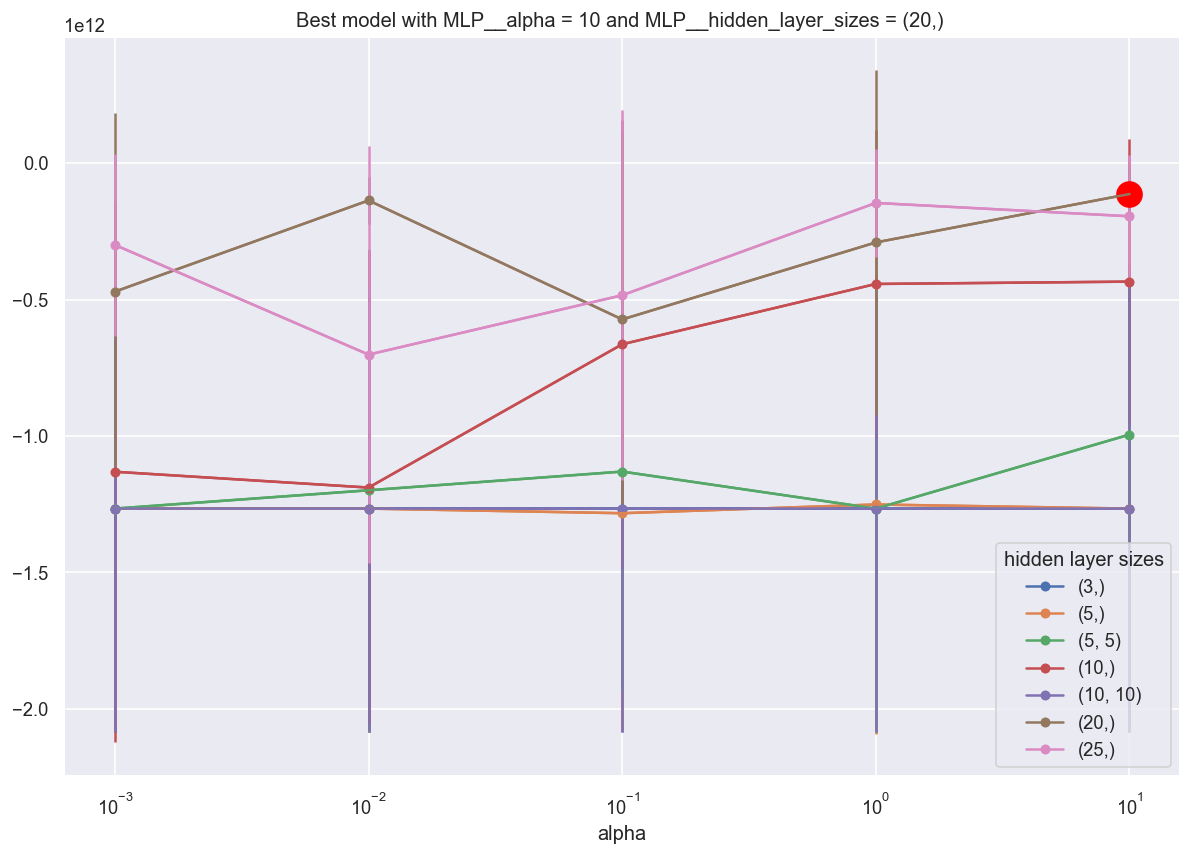

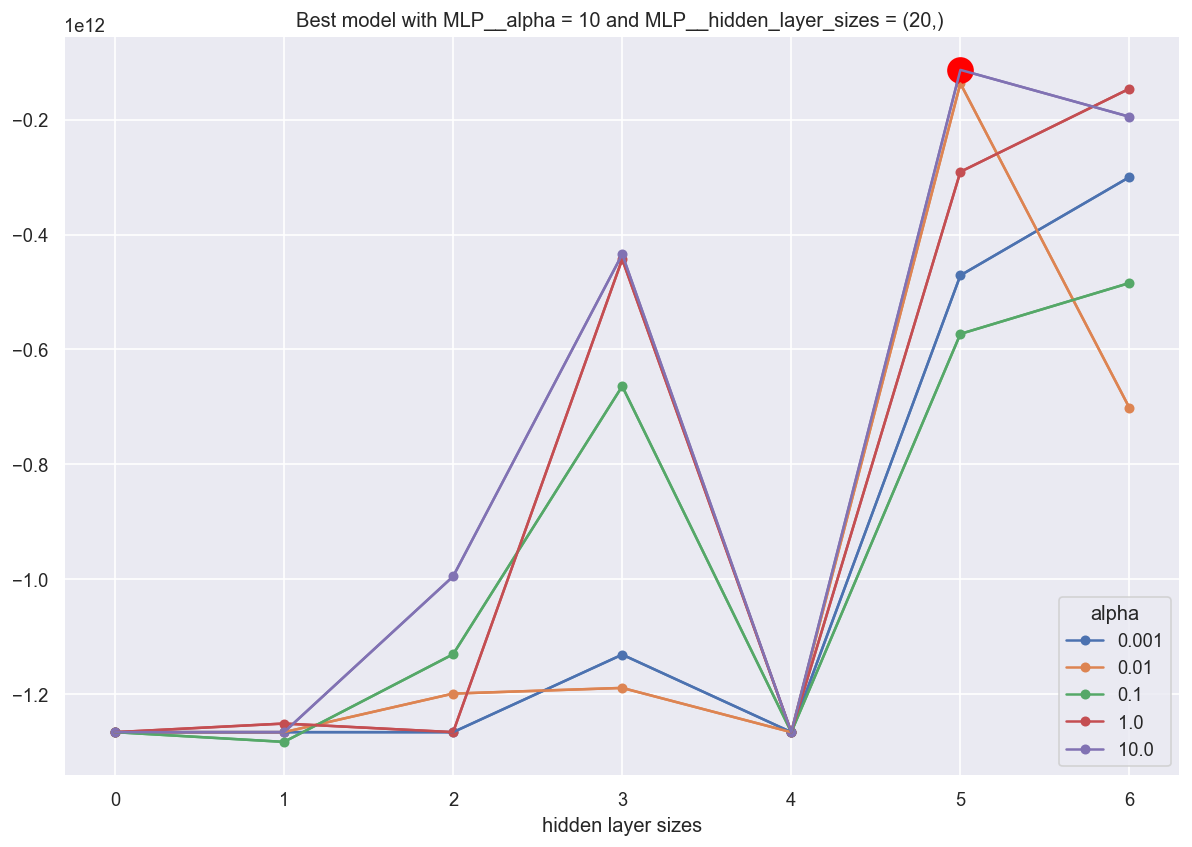

In [494]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [495]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train2) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train2, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [2, 20, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                         mean           std  mean_squared
num__TOTAL_lag1  3.832536e+06  5.422363e+07  5.435890e+07
cat__COVID_1     5.084787e+07  1.244499e+08  1.344369e+08


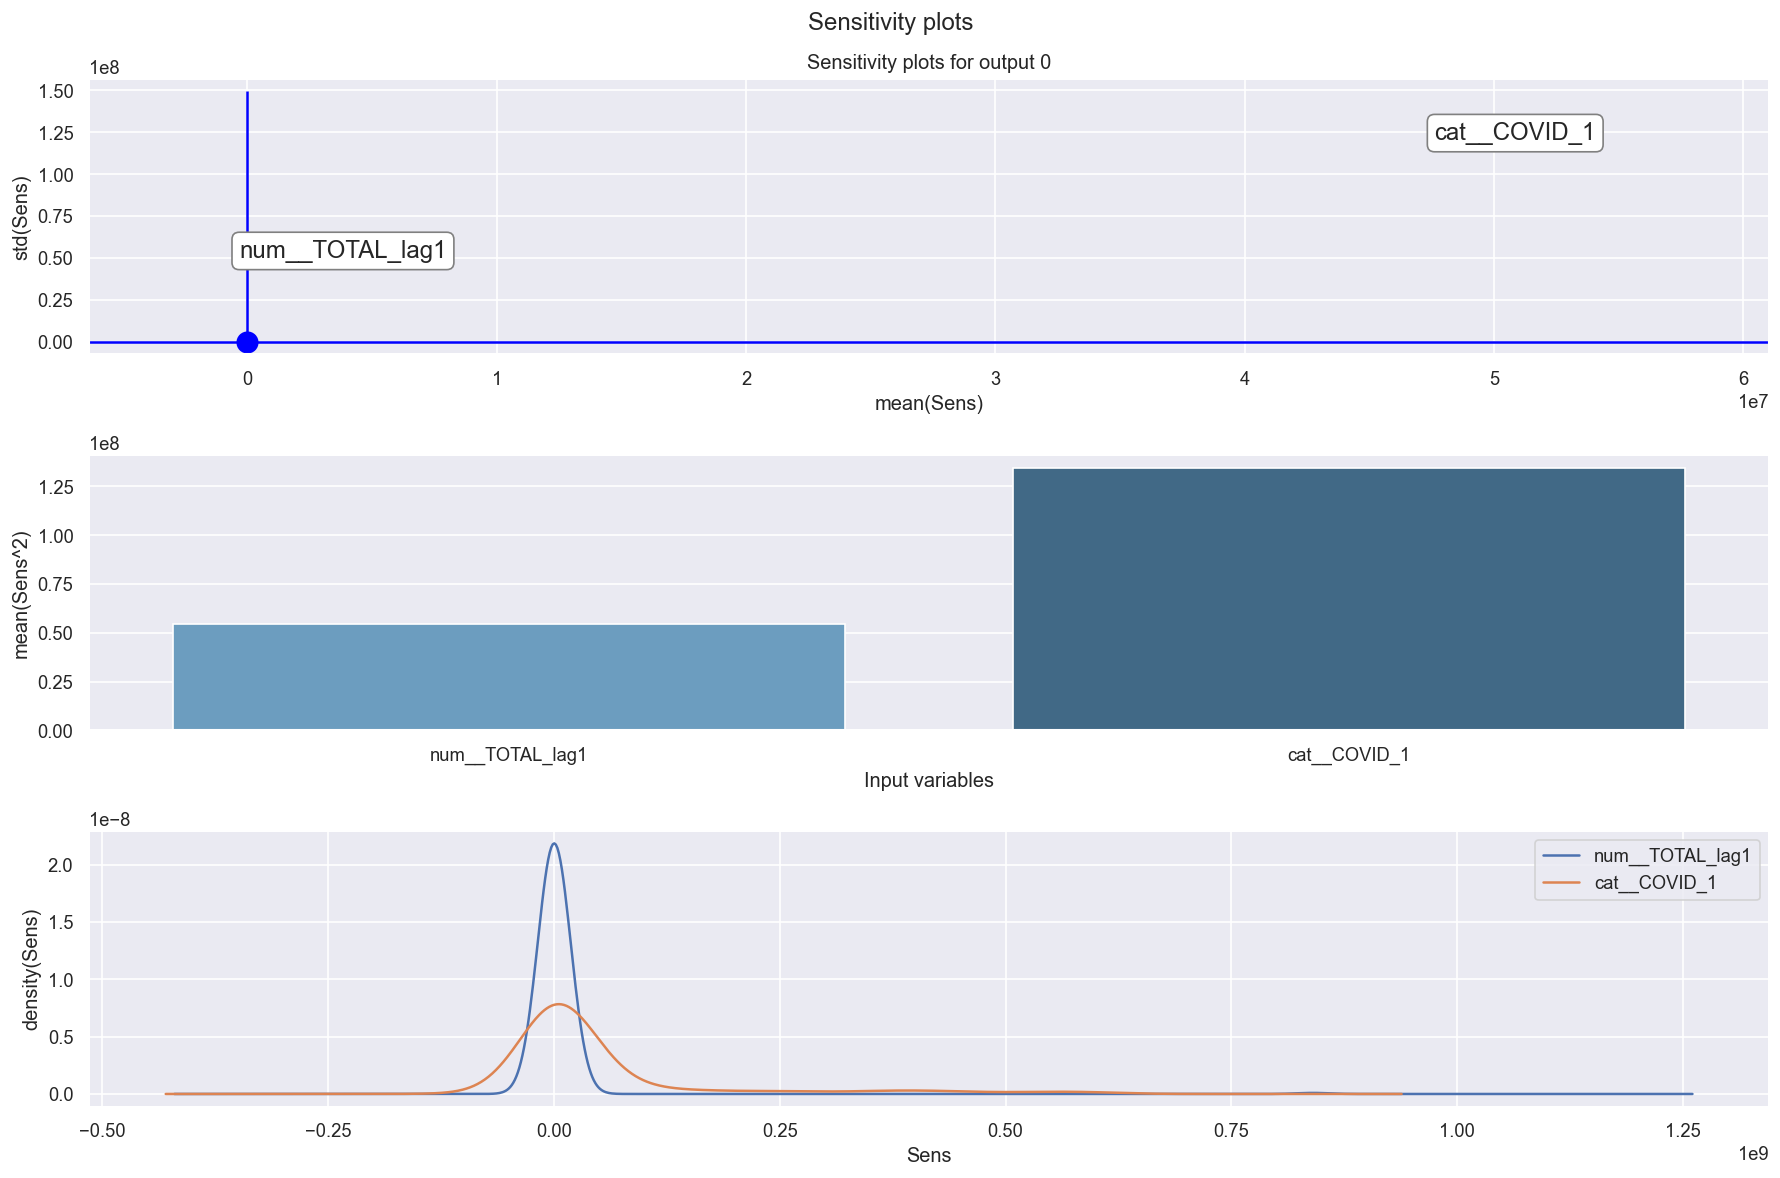

In [496]:
sensmlp.plot()

In [497]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train2)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test2)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))

#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 168273.5720418368
Test MAE: 154595.7282476066
Training RMSE: 205763.97454497073
Test RMSE: 181761.9614891743
Training R2: 0.959259876819017
Test R2: 0.717512945720295


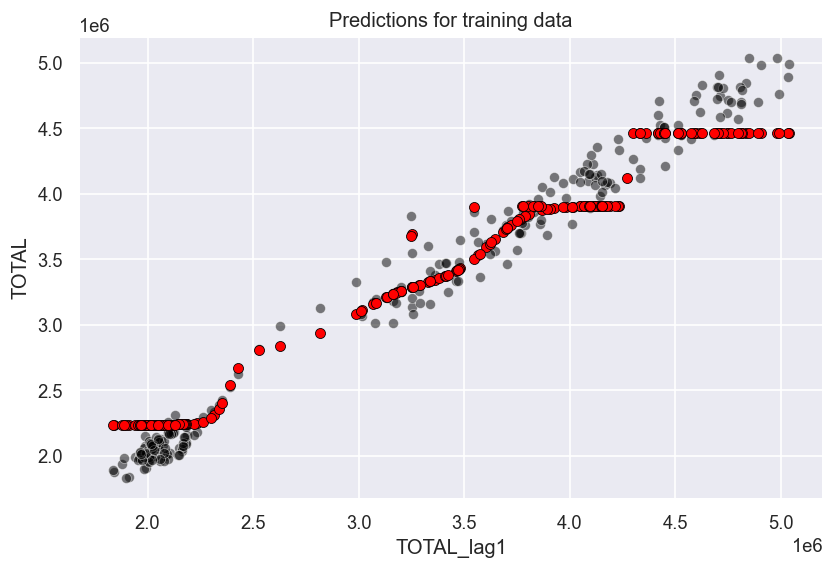

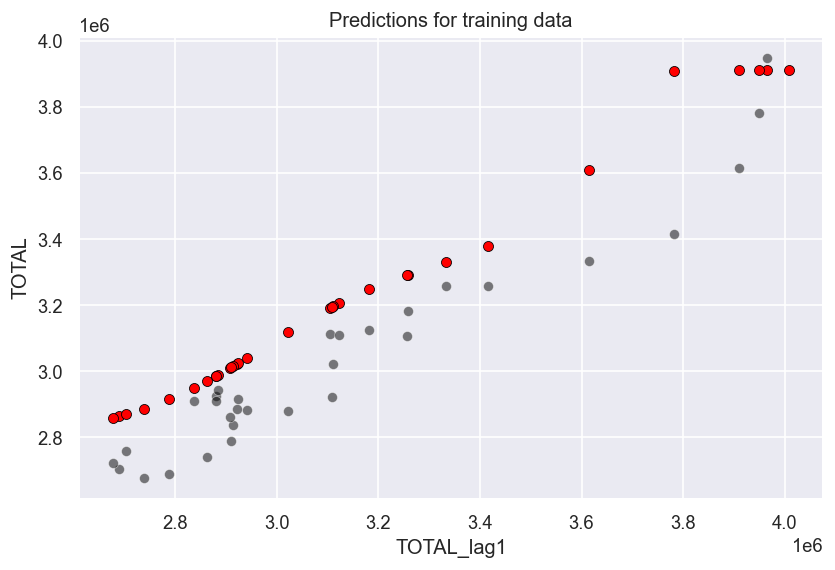

In [498]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

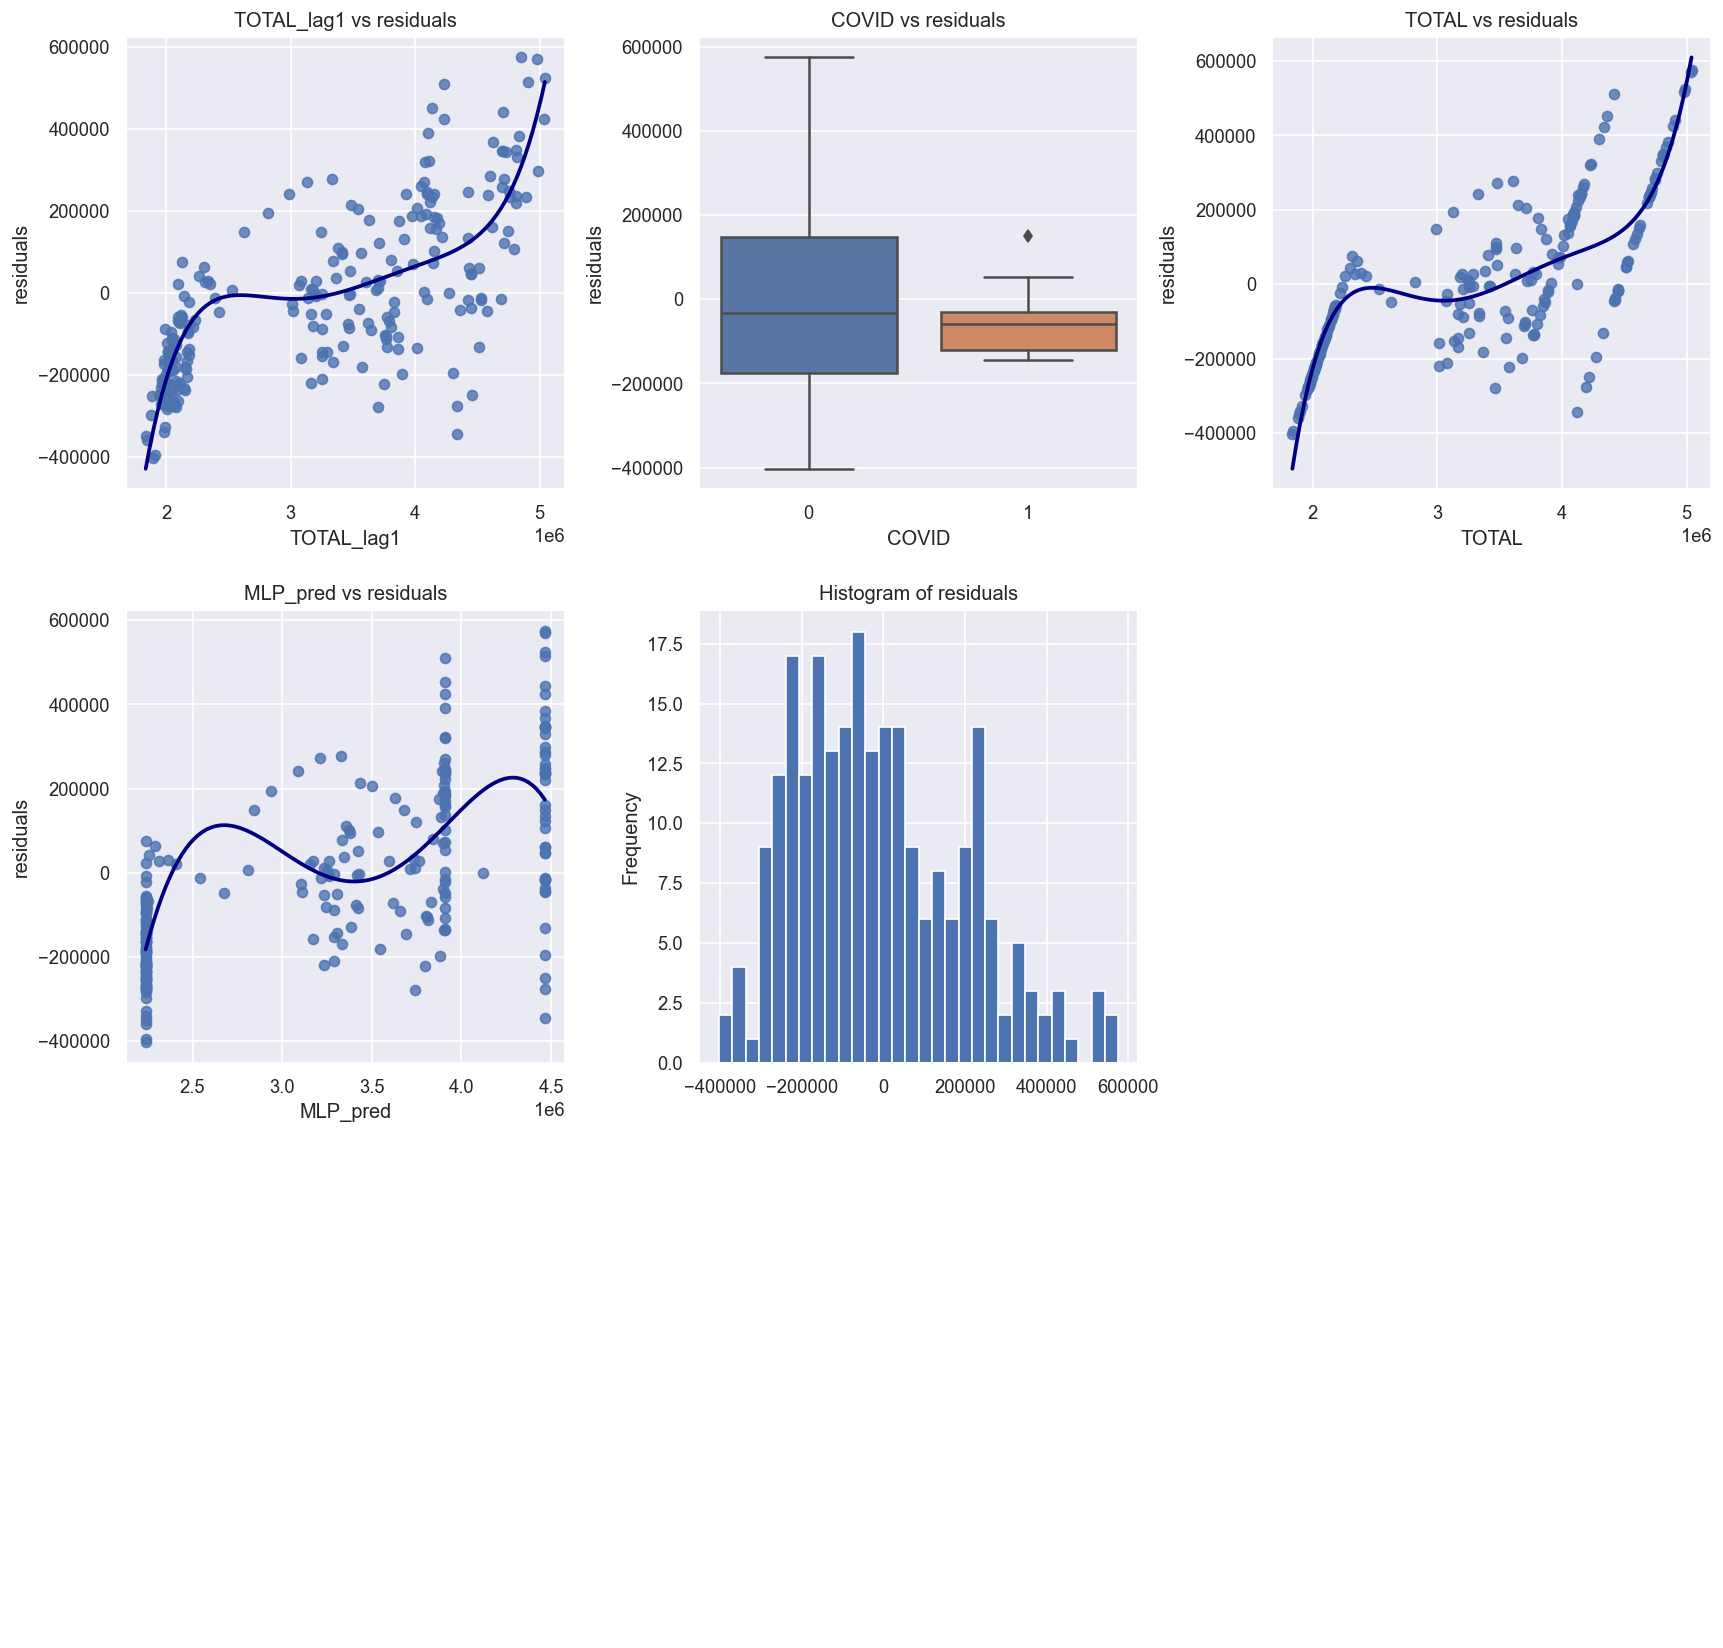

In [499]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

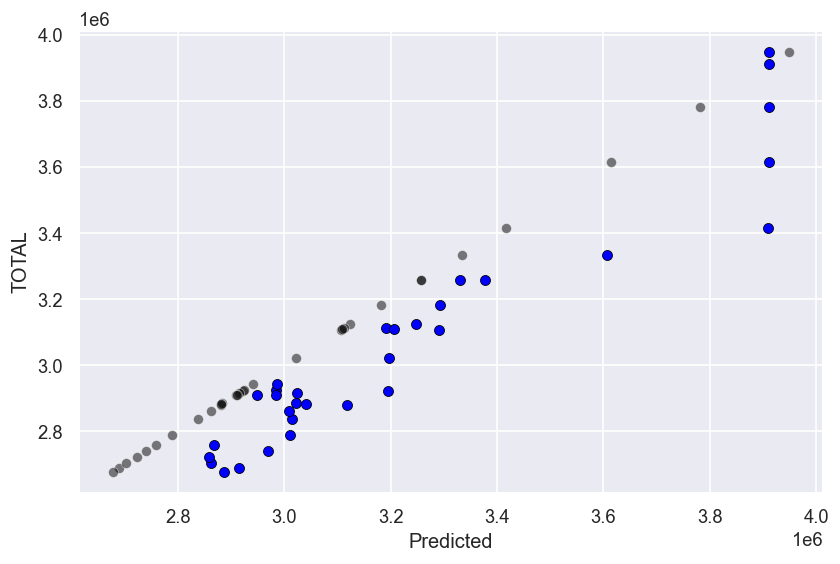

In [500]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 25 must be < 16.

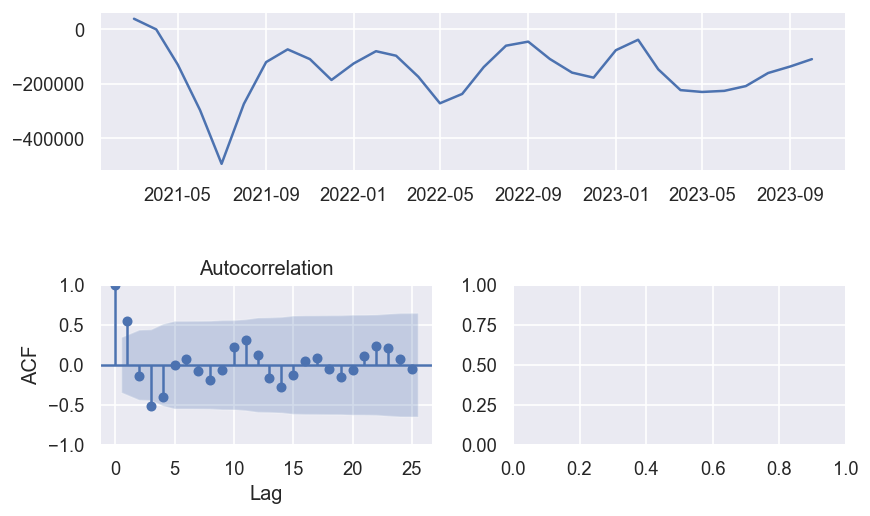

In [446]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'])

# Regresión Lineal

In [157]:
# Define input and output matrices
prop_train=0.88
dfT=df.copy()
dfT['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 dura
dfT.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1

dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(1)
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag12'] = dfT['TOTAL'].shift(12)
dfT['COVID'].astype('category')

# Remove missing
dfT.dropna(inplace=True)
dfT.head()
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag12','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2

TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  COVID
DATE                                                  
2002-01-01   1988716.0   1985857.0    2017389.0      0
2002-02-01   2075022.0   1988716.0    1993273.0      0
2002-03-01   2149907.0   2075022.0    1981006.0      0
2002-04-01   2083103.0   2149907.0    1910453.0      0
2002-05-01   2060069.0   2083103.0    1898285.0      0
...                ...         ...          ...    ...
2020-11-01   3826043.0   3776485.0    3198184.0      1
2020-12-01   3851312.0   3826043.0    3163605.0      1
2021-01-01   3888137.0   3851312.0    3253853.0      1
2021-02-01   3964353.0   3888137.0    3246047.0      1
2021-03-01   4008789.0   3964353.0    3548312.0      1

[231 rows x 4 columns]

In [152]:
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Assuming you already have X_train2 and y_train2

# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR_NUM = ['TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag12']
INPUTS_LR_CAT = ["COVID"]
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories DROPPING FIRST CATEGORY (DUMMY ENCODE)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM),
    ('cat', categorical_transformer, INPUTS_LR_CAT)
])

# Combine preprocessing and linear regression into a pipeline
pipe = Pipeline(steps=[
    ('Prep', preprocessor),  # Preprocess the variables when training the model
])

# Split the data into training and testing sets
 
# Apply the preprocessor to X_train
X_train_processed = preprocessor.fit_transform(X_train2)

# Add a constant for intercept term
X_train_processed = sm.add_constant(X_train2)

# Train the linear regression model with Statsmodels
model = sm.OLS(y_train2, X_train_processed).fit()

# Print the summary, including p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  TOTAL   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.619e+04
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          1.69e-276
Time:                        10:30:02   Log-Likelihood:                -2865.1
No. Observations:                 231   AIC:                             5740.
Df Residuals:                     226   BIC:                             5757.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.229e+04   1.35e+04      1.646      

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [153]:

print(X_train2)

# Add a constant for intercept term
X_train2_pred = sm.add_constant(X_train2)

# Make predictions
predictions_train = model.predict(X_train2_pred)

# Add a constant for intercept term
X_test2_pred = sm.add_constant(X_test2)

# Make predictions
predictions_test = model.predict(X_test2_pred)


# Print predictions
print("Predictions:", predictions_test)

dfTR_eval['LR_pred'] = predictions_train
dfTS_eval['LR_pred'] = predictions_test

            TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  COVID
DATE                                                  
2002-01-01   1988716.0   1985857.0    2017389.0      0
2002-02-01   2075022.0   1988716.0    1993273.0      0
2002-03-01   2149907.0   2075022.0    1981006.0      0
2002-04-01   2083103.0   2149907.0    1910453.0      0
2002-05-01   2060069.0   2083103.0    1898285.0      0
...                ...         ...          ...    ...
2020-11-01   3826043.0   3776485.0    3198184.0      1
2020-12-01   3851312.0   3826043.0    3163605.0      1
2021-01-01   3888137.0   3851312.0    3253853.0      1
2021-02-01   3964353.0   3888137.0    3246047.0      1
2021-03-01   4008789.0   3964353.0    3548312.0      1

[231 rows x 4 columns]
Predictions: DATE
2021-05-01    3.908950e+06
2021-06-01    3.731654e+06
2021-07-01    3.545393e+06
2021-08-01    3.310699e+06
2021-09-01    3.289255e+06
2021-10-01    3.216209e+06
2021-11-01    3.255206e+06
2021-12-01    3.141573e+06
2022-01-01    3.062988e+06


In [154]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))

Training MAE: 45908.65299798184
Test MAE: 43447.33295904504
Training RMSE: 58930.95069622369
Test RMSE: 55536.90079785366
Training R2: 0.9965219219280481
Test R2: 0.9569629446091603


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


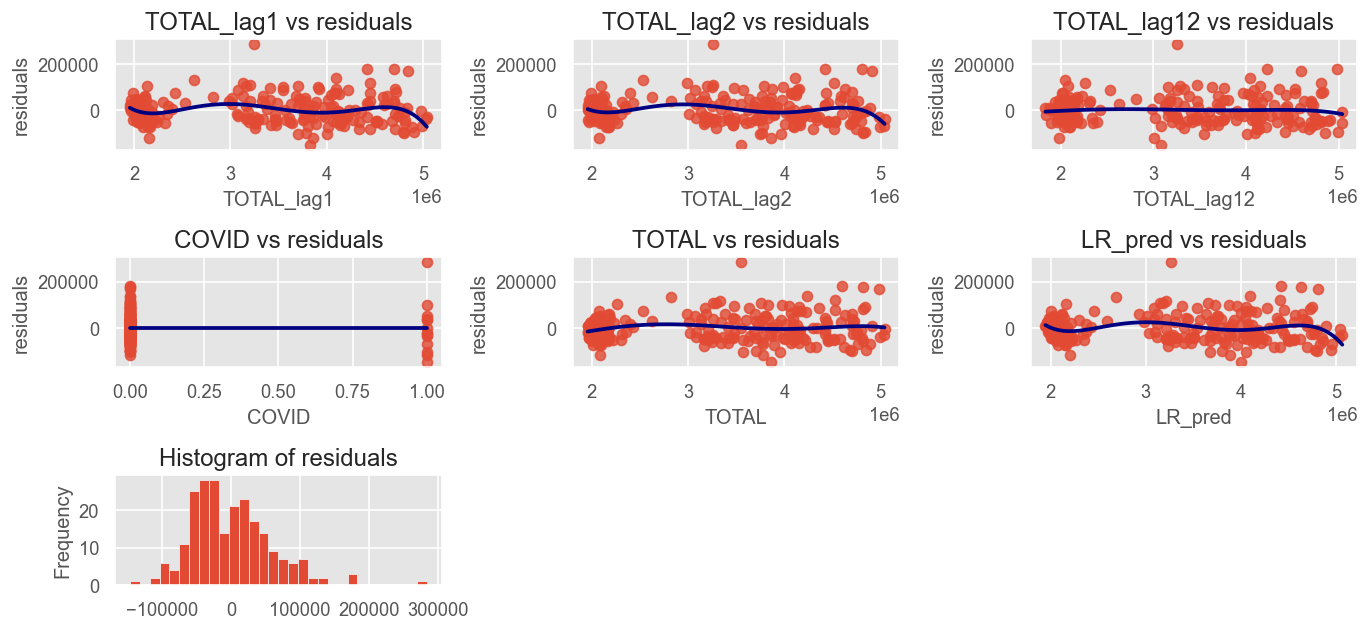

In [155]:
RT.plotModelDiagnosis(dfTR_eval, 'LR_pred', 'TOTAL') 

In [145]:
from scipy.stats import spearmanr

correlation, p_value = spearmanr(dfT['TOTAL_lag1'],dfT['TOTAL_lag2'] )

correlation

0.9936689618170438

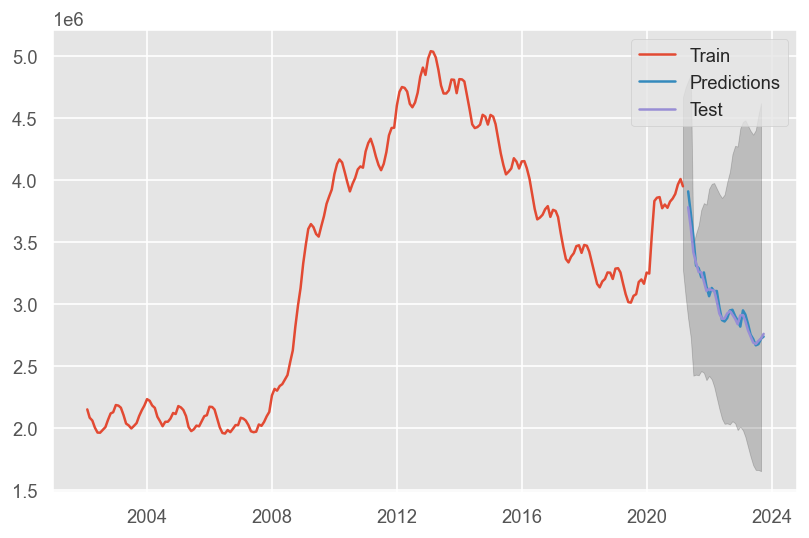

In [156]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

yhat = predictions_test

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()